In [8]:
%pip install SciencePlots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

plt.style.use(['science', 'no-latex'])

# Try to import optional libraries
try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False
    print("Warning: seaborn not available, using matplotlib only")

try:
    from sklearn.preprocessing import MinMaxScaler
    HAS_SKLEARN = True
except ImportError:
    HAS_SKLEARN = False
    print("Warning: sklearn not available, radar chart normalization disabled")

try:
    from scipy import stats
    from itertools import combinations
    HAS_SCIPY = True
except ImportError:
    HAS_SCIPY = False
    print("Warning: scipy not available, statistical testing disabled")

# Try to import word frequency libraries
try:
    from wordfreq import word_frequency
    HAS_WORDFREQ = True
    print("✓ wordfreq library available for frequency analysis")
except ImportError:
    HAS_WORDFREQ = False
    print("Warning: wordfreq not available, using alternative frequency estimation")

try:
    import nltk
    from nltk.corpus import brown
    HAS_NLTK = True
    print("✓ NLTK available for frequency analysis")
except ImportError:
    HAS_NLTK = False
    print("Warning: NLTK not available")

# Set font for potential Chinese characters support
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Set plot style with fallback
if HAS_SEABORN:
    try:
        sns.set_style("whitegrid")
        plt.style.use('seaborn-v0_8')
    except:
        try:
            plt.style.use('seaborn')
        except:
            plt.style.use('ggplot')
else:
    try:
        plt.style.use('ggplot')
    except:
        pass  # Use default style

# Set color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']


Note: you may need to restart the kernel to use updated packages.


OSError: 'science' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [19]:
# 加载数据集
with open('data/dataset.json', 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# 转换为DataFrame
dataset_df = pd.DataFrame(dataset)

# 提取concreteness_score
dataset_df['concreteness_score'] = dataset_df['metadata'].apply(lambda x: x.get('concreteness_score'))

print(f"数据集总词汇数: {len(dataset_df)}")
print(f"词性分布: {dataset_df['part_of_speech'].value_counts().to_dict()}")
print(f"领域分布: {dataset_df['category'].value_counts().to_dict()}")
print(f"有抽象程度评分的词汇数: {dataset_df['concreteness_score'].notna().sum()}")

dataset_df.head()


数据集总词汇数: 300
词性分布: {'noun': 256, 'adj': 32, 'verb': 12}
领域分布: {'general': 100, 'chemistry': 50, 'cs': 50, 'finance': 50, 'philosophy': 50}
有抽象程度评分的词汇数: 189


,target,part_of_speech,taboo,category,senses,metadata,concreteness_score
0,crotonbug,noun,"[common, croton, europe, german, states]",general,"[{'name': 'german_cockroach.n.01', 'pos': 'n',...","{'sense_count': 1, 'concreteness_score': None,...",NaN
1,entitlement,noun,"[budget, claim, federal, granted, major]",general,"[{'name': 'entitlement.n.01', 'pos': 'n', 'def...","{'sense_count': 1, 'concreteness_score': 1.79,...",1.79
2,hinge,noun,"[holds, joint, parts, strap, swing]",general,"[{'name': 'hinge.n.01', 'pos': 'n', 'definitio...","{'sense_count': 3, 'concreteness_score': 4.57,...",4.57
3,cubiform,adj,"[cuboid, shaped, cubical, cube, cubelike]",general,"[{'name': 'cubelike.s.01', 'pos': 's', 'defini...","{'sense_count': 1, 'concreteness_score': None,...",NaN
4,mantle,noun,"[mickey, symbol, cloak, place, younger]",general,"[{'name': 'mantle.n.01', 'pos': 'n', 'definiti...","{'sense_count': 10, 'concreteness_score': 4.57...",4.57


In [20]:
# 加载实验结果数据
results_df = pd.read_csv('results/taboo_experiment_20250712_004918/complete_experiment_results.csv')

print(f"实验结果总数: {len(results_df)}")
print(f"参与实验的模型: {results_df['hinter_model'].unique().tolist()}")
print(f"总体成功率: {results_df['success'].mean():.3f}")

# Clean model names for display
model_name_mapping = {
    'anthropic/claude-sonnet-4': 'Claude Sonnet 4',
    'openai/gpt-4o': 'GPT-4o',
    'google/gemini-2.5-pro': 'Gemini 2.5 Pro',
    'deepseek/deepseek-chat-v3-0324': 'DeepSeek Chat V3'
}

results_df['hinter_model_clean'] = results_df['hinter_model'].map(model_name_mapping)
results_df['guesser_model_clean'] = results_df['guesser_model'].map(model_name_mapping)

results_df.head()


实验结果总数: 4800
参与实验的模型: ['openai/gpt-4o', 'google/gemini-2.5-pro', 'deepseek/deepseek-chat-v3-0324', 'anthropic/claude-sonnet-4']
总体成功率: 0.906


,game_id,word_index,hinter_model,guesser_model,target_word,category,taboo_words,success,turns_used,final_guess,...,all_guesses,conversation,total_api_attempts,format_errors,has_format_errors,duration_seconds,timestamp,error,hinter_model_clean,guesser_model_clean
0,gpt-4o_1,0,openai/gpt-4o,openai/gpt-4o,crotonbug,general,common|croton|europe|german|states,False,5,beetle,...,Guesser: [GUESS] cockroach | Guesser: [GUESS] ...,Hinter: [CLUE] This is an insect often found i...,10,NaN,False,9.66,2025-07-12 00:49:27,NaN,GPT-4o,GPT-4o
1,gpt-4o_2,1,openai/gpt-4o,openai/gpt-4o,entitlement,general,budget|claim|federal|granted|major,True,1,entitlement,...,Guesser: [GUESS] entitlement,Hinter: [CLUE] This is a term often used to de...,2,NaN,False,1.82,2025-07-12 00:49:29,NaN,GPT-4o,GPT-4o
2,gpt-4o_3,2,openai/gpt-4o,openai/gpt-4o,hinge,general,holds|joint|parts|strap|swing,True,1,hinge,...,Guesser: [GUESS] hinge,Hinter: [CLUE] This is a device that allows do...,2,NaN,False,1.53,2025-07-12 00:49:31,NaN,GPT-4o,GPT-4o
3,gpt-4o_4,3,openai/gpt-4o,openai/gpt-4o,cubiform,general,cuboid|shaped|cubical|cube|cubelike,False,5,cubical,...,Guesser: [GUESS] cube | Guesser: [GUESS] cuboi...,Hinter: [CLUE] This is a geometric form with s...,10,NaN,False,12.06,2025-07-12 00:49:44,NaN,GPT-4o,GPT-4o
4,gpt-4o_5,4,openai/gpt-4o,openai/gpt-4o,mantle,general,mickey|symbol|cloak|place|younger,True,1,mantle,...,Guesser: [GUESS] mantle,Hinter: [CLUE] This is a part of the Earth loc...,2,NaN,False,1.83,2025-07-12 00:49:46,NaN,GPT-4o,GPT-4o


In [21]:
# Merge dataset information with results
# 重新清理和合并数据，确保没有列名冲突
print("正在重新加载和合并数据...")

# 重新加载数据集以确保干净的状态
with open('data/dataset.json', 'r', encoding='utf-8') as f:
    dataset = json.load(f)
dataset_df = pd.DataFrame(dataset)

# 提取metadata信息
dataset_df['concreteness_score'] = dataset_df['metadata'].apply(lambda x: x.get('concreteness_score') if x else None)
dataset_df['sense_count'] = dataset_df['metadata'].apply(lambda x: x.get('sense_count', 1) if x else 1)

# 只选择需要的列，避免category列冲突（results_df已经有category）
dataset_info = dataset_df[['target', 'part_of_speech', 'concreteness_score', 'sense_count']].copy()
dataset_info = dataset_info.rename(columns={'target': 'target_word'})

# 清理合并
merged_df = results_df.merge(dataset_info, on='target_word', how='left')

# 确保category列存在且正确
if 'category' not in merged_df.columns:
    if 'category_x' in merged_df.columns:
        merged_df['category'] = merged_df['category_x']
        merged_df = merged_df.drop(['category_x'], axis=1)
    elif 'category_y' in merged_df.columns:
        merged_df['category'] = merged_df['category_y']
        merged_df = merged_df.drop(['category_y'], axis=1)

# 清理任何残留的重复category列
cols_to_drop = [col for col in merged_df.columns if col in ['category_x', 'category_y']]
if cols_to_drop:
    merged_df = merged_df.drop(cols_to_drop, axis=1)

# 添加词频分析
def get_word_frequency(word):
    """获取单词的频率评分"""
    word = word.lower()
    
    if HAS_WORDFREQ:
        # Use wordfreq library for accurate frequency
        freq = word_frequency(word, 'en')
        return freq if freq > 0 else 1e-8  # Avoid log(0)
    else:
        # Fallback: use word length as inverse frequency proxy
        # Longer words tend to be less frequent
        return 1.0 / (len(word) ** 1.5)

print("正在计算词频...")
merged_df['word_frequency'] = merged_df['target_word'].apply(get_word_frequency)

# Create frequency categories for easier analysis
merged_df['frequency_log'] = np.log10(merged_df['word_frequency'])
merged_df['frequency_category'] = pd.cut(
    merged_df['frequency_log'], 
    bins=5, 
    labels=['Very Rare', 'Rare', 'Uncommon', 'Common', 'Very Common']
)

print(f"合并后数据量: {len(merged_df)}")
print(f"成功匹配词汇信息的比例: {merged_df['part_of_speech'].notna().mean():.3f}")
print(f"可用列: {sorted(merged_df.columns.tolist())}")

# 验证关键列是否存在
required_cols = ['category', 'part_of_speech', 'sense_count', 'word_frequency', 'frequency_category']
missing_cols = [col for col in required_cols if col not in merged_df.columns]
if missing_cols:
    print(f"⚠️  缺少的列: {missing_cols}")
else:
    print("✅ 所有必需的列都已成功创建")

if 'category' in merged_df.columns:
    print(f"类别分布: {merged_df['category'].value_counts().to_dict()}")
if 'word_frequency' in merged_df.columns:
    print(f"词频范围: {merged_df['word_frequency'].min():.2e} - {merged_df['word_frequency'].max():.2e}")
if 'frequency_category' in merged_df.columns:
    print(f"词频类别分布: {merged_df['frequency_category'].value_counts().to_dict()}")

merged_df.head()


正在重新加载和合并数据...
正在计算词频...
合并后数据量: 4800
成功匹配词汇信息的比例: 1.000
可用列: ['all_guesses', 'all_hints', 'category', 'concreteness_score', 'conversation', 'duration_seconds', 'error', 'failure_reason', 'final_guess', 'format_errors', 'frequency_category', 'frequency_log', 'game_id', 'guesser_model', 'guesser_model_clean', 'has_format_errors', 'has_taboo_violation', 'hinter_model', 'hinter_model_clean', 'part_of_speech', 'sense_count', 'success', 'taboo_violation_hint', 'taboo_violation_turn', 'taboo_words', 'target_word', 'timestamp', 'total_api_attempts', 'turns_used', 'word_frequency', 'word_index']
✅ 所有必需的列都已成功创建
类别分布: {'general': 1600, 'chemistry': 800, 'cs': 800, 'finance': 800, 'philosophy': 800}
词频范围: 1.00e-08 - 8.13e-04
词频类别分布: {'Uncommon': 1312, 'Rare': 1152, 'Very Rare': 1072, 'Common': 1008, 'Very Common': 256}


,game_id,word_index,hinter_model,guesser_model,target_word,category,taboo_words,success,turns_used,final_guess,...,timestamp,error,hinter_model_clean,guesser_model_clean,part_of_speech,concreteness_score,sense_count,word_frequency,frequency_log,frequency_category
0,gpt-4o_1,0,openai/gpt-4o,openai/gpt-4o,crotonbug,general,common|croton|europe|german|states,False,5,beetle,...,2025-07-12 00:49:27,NaN,GPT-4o,GPT-4o,noun,NaN,1,1.000000e-08,-8.000000,Very Rare
1,gpt-4o_2,1,openai/gpt-4o,openai/gpt-4o,entitlement,general,budget|claim|federal|granted|major,True,1,entitlement,...,2025-07-12 00:49:29,NaN,GPT-4o,GPT-4o,noun,1.79,1,3.550000e-06,-5.449772,Uncommon
2,gpt-4o_3,2,openai/gpt-4o,openai/gpt-4o,hinge,general,holds|joint|parts|strap|swing,True,1,hinge,...,2025-07-12 00:49:31,NaN,GPT-4o,GPT-4o,noun,4.57,3,2.090000e-06,-5.679854,Uncommon
3,gpt-4o_4,3,openai/gpt-4o,openai/gpt-4o,cubiform,general,cuboid|shaped|cubical|cube|cubelike,False,5,cubical,...,2025-07-12 00:49:44,NaN,GPT-4o,GPT-4o,adj,NaN,1,1.000000e-08,-8.000000,Very Rare
4,gpt-4o_5,4,openai/gpt-4o,openai/gpt-4o,mantle,general,mickey|symbol|cloak|place|younger,True,1,mantle,...,2025-07-12 00:49:46,NaN,GPT-4o,GPT-4o,noun,4.57,10,4.170000e-06,-5.379864,Uncommon


Model Performance Overview:
                    Total Games  Successful Games  Success Rate  \
hinter_model_clean                                                
Gemini 2.5 Pro             1200              1160         0.967   
Claude Sonnet 4            1200              1151         0.959   
DeepSeek Chat V3           1200              1073         0.894   
GPT-4o                     1200               966         0.805   

                    Average Turns  Violation Rate  
hinter_model_clean                                 
Gemini 2.5 Pro              1.578           0.018  
Claude Sonnet 4             1.427           0.040  
DeepSeek Chat V3            2.002           0.038  
GPT-4o                      2.043           0.051  


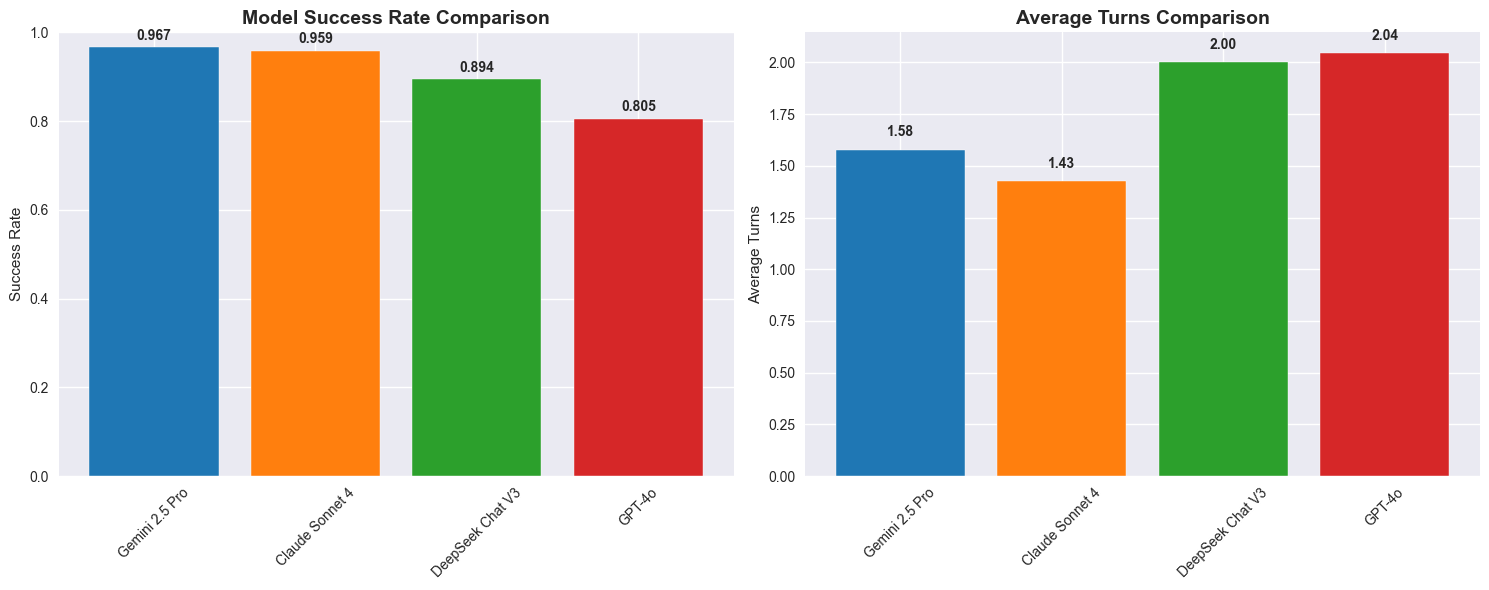

In [22]:
# Calculate overall success rates for each model
model_success = merged_df.groupby('hinter_model_clean').agg({
    'success': ['count', 'sum', 'mean'],
    'turns_used': 'mean',
    'has_taboo_violation': 'mean'
}).round(3)

model_success.columns = ['Total Games', 'Successful Games', 'Success Rate', 'Average Turns', 'Violation Rate']
model_success = model_success.sort_values('Success Rate', ascending=False)

print("Model Performance Overview:")
print(model_success)

# Plot model success rate comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Success rate bar chart
bars1 = ax1.bar(model_success.index, model_success['Success Rate'], color=colors[:len(model_success)])
ax1.set_title('Model Success Rate Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Average turns comparison
bars2 = ax2.bar(model_success.index, model_success['Average Turns'], color=colors[:len(model_success)])
ax2.set_title('Average Turns Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Average Turns')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


各模型在不同轮数的成功率分布:
                    第1轮成功率  第2轮成功率  第3轮成功率  第4轮成功率  第5轮成功率
hinter_model_clean                                        
Claude Sonnet 4      0.683   0.233   0.066   0.016   0.003
DeepSeek Chat V3     0.577   0.214   0.115   0.054   0.040
GPT-4o               0.659   0.204   0.080   0.041   0.016
Gemini 2.5 Pro       0.657   0.221   0.073   0.033   0.016

各模型的累积成功率:
                    前1轮累积成功率  前2轮累积成功率  前3轮累积成功率  前4轮累积成功率  前5轮累积成功率
hinter_model_clean                                                  
Claude Sonnet 4        0.683     0.916     0.982     0.997       1.0
DeepSeek Chat V3       0.577     0.791     0.906     0.960       1.0
GPT-4o                 0.659     0.863     0.943     0.984       1.0
Gemini 2.5 Pro         0.657     0.878     0.951     0.984       1.0


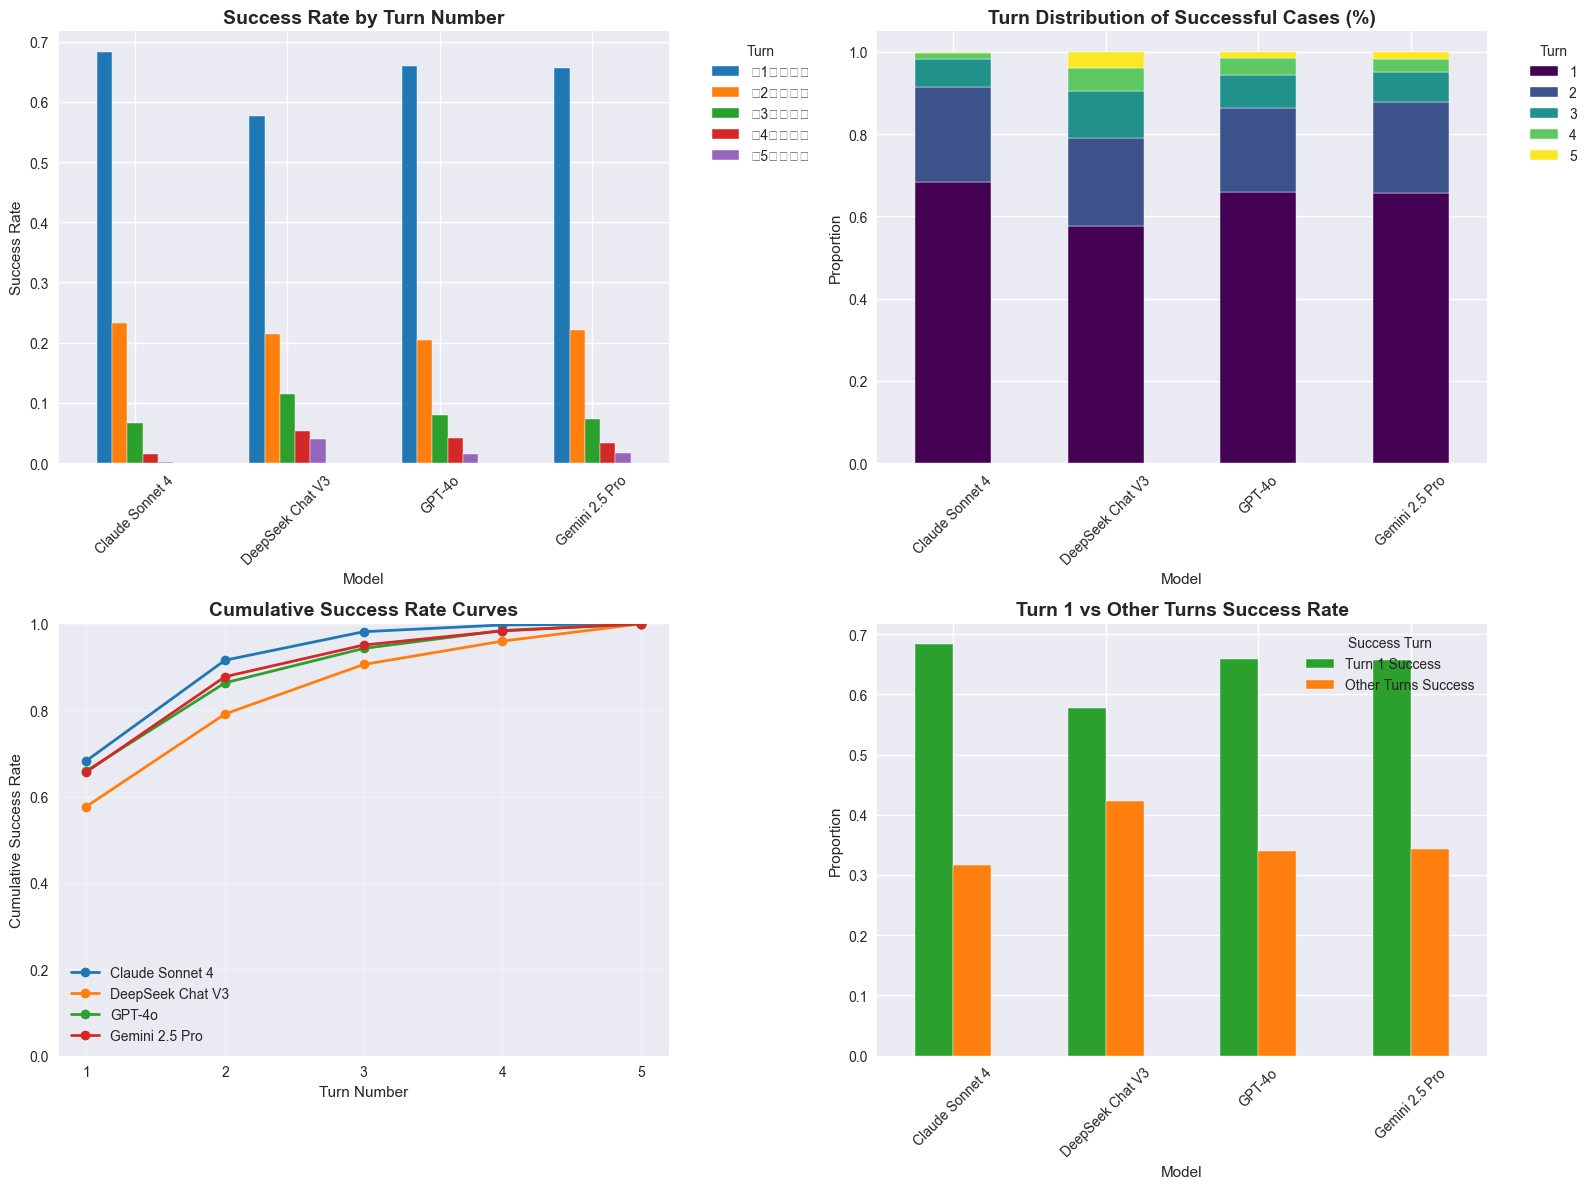


📈 轮数分析总结:
  • 总体第1轮成功率: 64.4%
  • 总体前3轮累积成功率: 94.5%
  • 第1轮成功率最高的模型: Claude Sonnet 4 (68.3%)
  • 前3轮累积成功率最高的模型: Claude Sonnet 4 (98.2%)


In [23]:
# 分析成功案例的轮数分布
successful_games = merged_df[merged_df['success'] == True]

# 计算各轮成功的详细分布
turns_analysis = successful_games.groupby(['hinter_model_clean', 'turns_used']).size().unstack(fill_value=0)
turns_pct = turns_analysis.div(turns_analysis.sum(axis=1), axis=0)

# 计算各轮成功率（包括第1轮、第2轮等）
turn_success_rates = {}
for turn in range(1, 6):  # 分析前5轮
    turn_rates = successful_games.groupby('hinter_model_clean').apply(
        lambda x: (x['turns_used'] == turn).sum() / len(x)
    )
    turn_success_rates[f'第{turn}轮成功率'] = turn_rates

turn_success_df = pd.DataFrame(turn_success_rates).fillna(0)
print("各模型在不同轮数的成功率分布:")
print(turn_success_df.round(3))

# 计算累积成功率
cumulative_success = {}
for turn in range(1, 6):
    cumulative_rates = successful_games.groupby('hinter_model_clean').apply(
        lambda x: (x['turns_used'] <= turn).sum() / len(x)
    )
    cumulative_success[f'前{turn}轮累积成功率'] = cumulative_rates

cumulative_df = pd.DataFrame(cumulative_success).fillna(0)
print("\n各模型的累积成功率:")
print(cumulative_df.round(3))

# 绘制详细的轮数分析图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. 各轮成功率对比
turn_success_df.plot(kind='bar', ax=ax1, color=colors[:len(turn_success_df.columns)])
ax1.set_title('Success Rate by Turn Number', fontsize=14, fontweight='bold')
ax1.set_ylabel('Success Rate')
ax1.set_xlabel('Model')
ax1.legend(title='Turn', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# 2. 堆积柱状图显示轮数分布
turns_pct.plot(kind='bar', stacked=True, ax=ax2, colormap='viridis')
ax2.set_title('Turn Distribution of Successful Cases (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Proportion')
ax2.set_xlabel('Model')
ax2.legend(title='Turn', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)

# 3. 累积成功率曲线
for i, model in enumerate(cumulative_df.index):
    turns = range(1, 6)
    rates = [cumulative_df.loc[model, f'前{turn}轮累积成功率'] for turn in turns]
    ax3.plot(turns, rates, 'o-', linewidth=2, label=model, color=colors[i])

ax3.set_title('Cumulative Success Rate Curves', fontsize=14, fontweight='bold')
ax3.set_xlabel('Turn Number')
ax3.set_ylabel('Cumulative Success Rate')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xticks(range(1, 6))
ax3.set_ylim(0, 1)

# 4. 第1轮vs其他轮数成功率对比
first_turn_vs_others = pd.DataFrame({
    'Turn 1 Success': turn_success_df['第1轮成功率'],
    'Other Turns Success': 1 - turn_success_df['第1轮成功率']
})

first_turn_vs_others.plot(kind='bar', ax=ax4, color=['#2ca02c', '#ff7f0e'])
ax4.set_title('Turn 1 vs Other Turns Success Rate', fontsize=14, fontweight='bold')
ax4.set_ylabel('Proportion')
ax4.set_xlabel('Model')
ax4.legend(title='Success Turn')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 输出详细统计
print(f"\n📈 轮数分析总结:")
print(f"  • 总体第1轮成功率: {turn_success_df['第1轮成功率'].mean():.1%}")
print(f"  • 总体前3轮累积成功率: {cumulative_df['前3轮累积成功率'].mean():.1%}")
print(f"  • 第1轮成功率最高的模型: {turn_success_df['第1轮成功率'].idxmax()} ({turn_success_df['第1轮成功率'].max():.1%})")
print(f"  • 前3轮累积成功率最高的模型: {cumulative_df['前3轮累积成功率'].idxmax()} ({cumulative_df['前3轮累积成功率'].max():.1%})")


按词性的成功率分析:
hinter_model_clean  Claude Sonnet 4  DeepSeek Chat V3  GPT-4o  Gemini 2.5 Pro
part_of_speech                                                               
adj                           0.953             0.703   0.625           0.961
noun                          0.958             0.919   0.839           0.966
verb                          1.000             0.875   0.562           1.000


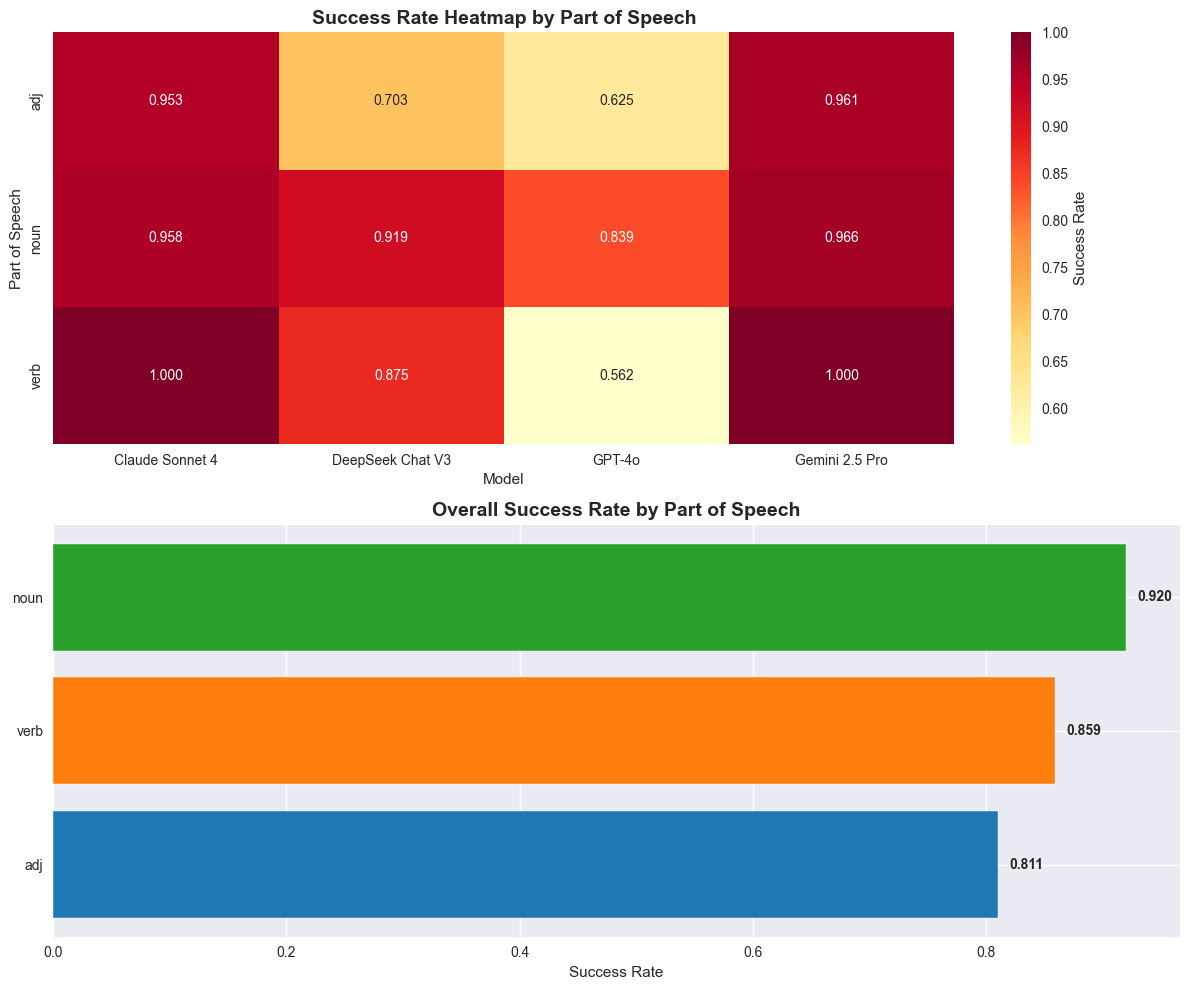

In [24]:
# 按词性分析成功率
pos_success = merged_df.groupby(['part_of_speech', 'hinter_model_clean']).agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)

pos_success.columns = ['Games', 'Success Rate', 'Average Turns']
pos_success = pos_success.reset_index()

print("按词性的成功率分析:")
pos_pivot = pos_success.pivot(index='part_of_speech', columns='hinter_model_clean', values='Success Rate')
print(pos_pivot.round(3))

# 绘制词性成功率热力图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 热力图
if HAS_SEABORN and not pos_pivot.empty:
    sns.heatmap(pos_pivot, annot=True, cmap='YlOrRd', ax=ax1, 
                cbar_kws={'label': 'Success Rate'}, fmt='.3f')
else:
    # Fallback to matplotlib heatmap
    if not pos_pivot.empty:
        im = ax1.imshow(pos_pivot.values, cmap='YlOrRd', aspect='auto')
        ax1.set_xticks(range(len(pos_pivot.columns)))
        ax1.set_yticks(range(len(pos_pivot.index)))
        ax1.set_xticklabels(pos_pivot.columns, rotation=45)
        ax1.set_yticklabels(pos_pivot.index)
        
        # Add text annotations
        for i in range(len(pos_pivot.index)):
            for j in range(len(pos_pivot.columns)):
                if not pd.isna(pos_pivot.iloc[i, j]):
                    ax1.text(j, i, f'{pos_pivot.iloc[i, j]:.3f}', 
                            ha='center', va='center', color='black')
        
        # Add colorbar
        plt.colorbar(im, ax=ax1, label='Success Rate')
    else:
        ax1.text(0.5, 0.5, 'No data available for heatmap', 
                ha='center', va='center', transform=ax1.transAxes)

ax1.set_title('Success Rate Heatmap by Part of Speech', fontsize=14, fontweight='bold')
ax1.set_xlabel('Model')
ax1.set_ylabel('Part of Speech')

# 词性整体成功率
overall_pos = merged_df.groupby('part_of_speech')['success'].mean().sort_values(ascending=True)
bars = ax2.barh(range(len(overall_pos)), overall_pos.values, color=colors[:len(overall_pos)])
ax2.set_yticks(range(len(overall_pos)))
ax2.set_yticklabels(overall_pos.index)
ax2.set_title('Overall Success Rate by Part of Speech', fontsize=14, fontweight='bold')
ax2.set_xlabel('Success Rate')

# 添加数值标签
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


Sense count 分布:
sense_count
1     128
2      58
3      37
4      19
5      13
6      11
7      11
8       3
9       4
10      3
11      3
12      4
14      1
15      1
17      1
20      1
23      2
Name: count, dtype: int64

成功匹配sense count信息的比例: 1.000

按Sense Count的成功率分析:
hinter_model_clean  Claude Sonnet 4  DeepSeek Chat V3  GPT-4o  Gemini 2.5 Pro
sense_count                                                                  
1                             0.938             0.855   0.711           0.953
2                             0.996             0.944   0.845           0.987
3                             1.000             0.912   0.905           0.993
4                             1.000             1.000   0.934           1.000
5                             0.904             0.962   0.904           0.981
6                             0.932             0.977   0.977           1.000
7                             1.000             0.750   0.705           0.886
8                       

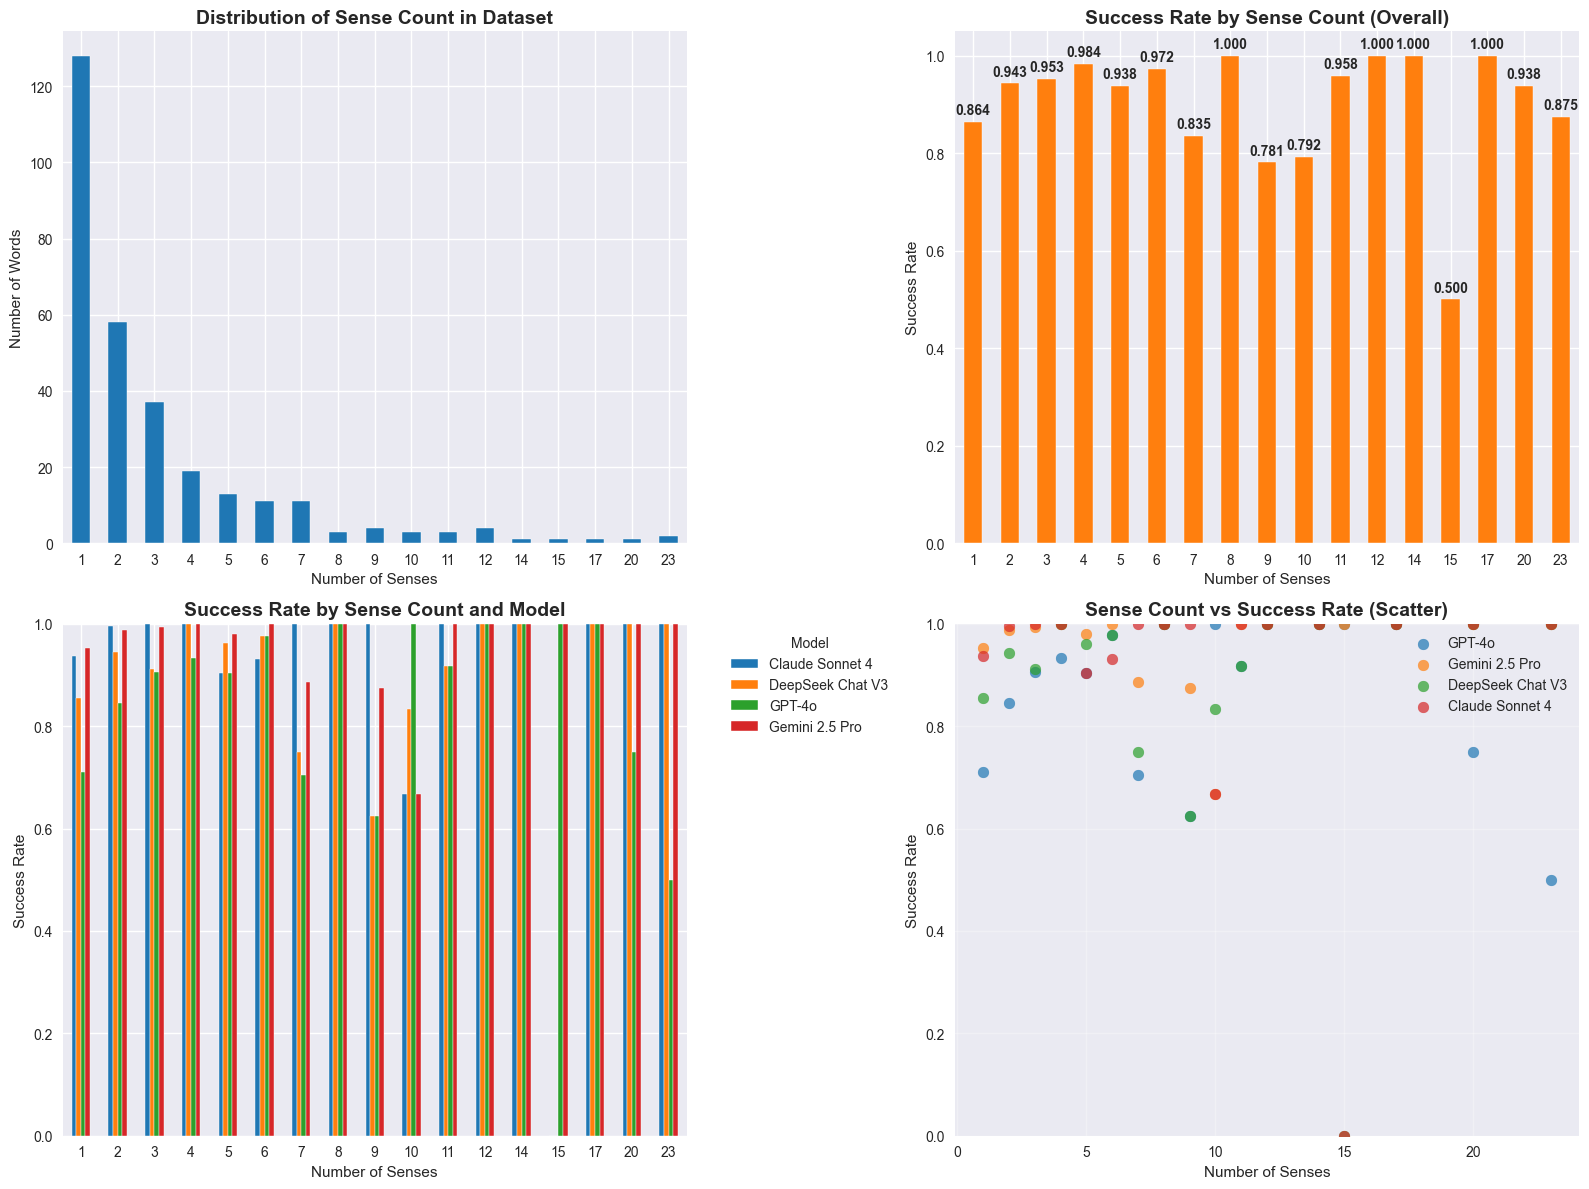


📊 Sense Count与成功率的相关性: 0.0250

🔍 详细分析:
  • Sense Count 1: 86.4% 成功率 (2048 局游戏, 平均 1.8 轮)
  • Sense Count 2: 94.3% 成功率 (928 局游戏, 平均 1.6 轮)
  • Sense Count 3: 95.3% 成功率 (592 局游戏, 平均 1.3 轮)
  • Sense Count 4: 98.4% 成功率 (304 局游戏, 平均 1.2 轮)
  • Sense Count 5: 93.8% 成功率 (208 局游戏, 平均 1.3 轮)
  • Sense Count 6: 97.2% 成功率 (176 局游戏, 平均 1.3 轮)
  • Sense Count 7: 83.5% 成功率 (176 局游戏, 平均 1.4 轮)
  • Sense Count 8: 100.0% 成功率 (48 局游戏, 平均 1.2 轮)
  • Sense Count 9: 78.1% 成功率 (64 局游戏, 平均 1.5 轮)
  • Sense Count 10: 79.2% 成功率 (48 局游戏, 平均 1.2 轮)
  • Sense Count 11: 95.8% 成功率 (48 局游戏, 平均 1.2 轮)
  • Sense Count 12: 100.0% 成功率 (64 局游戏, 平均 1.1 轮)
  • Sense Count 14: 100.0% 成功率 (16 局游戏, 平均 1.0 轮)
  • Sense Count 15: 50.0% 成功率 (16 局游戏, 平均 1.0 轮)
  • Sense Count 17: 100.0% 成功率 (16 局游戏, 平均 1.4 轮)
  • Sense Count 20: 93.8% 成功率 (16 局游戏, 平均 1.2 轮)
  • Sense Count 23: 87.5% 成功率 (32 局游戏, 平均 1.1 轮)

💡 趋势分析: 词义数量与成功率无明显关系 (相关系数: 0.0250)


In [25]:
# 分析sense count对成功率的影响
# 首先提取sense count信息
dataset_df['sense_count'] = dataset_df['metadata'].apply(lambda x: x.get('sense_count', 1))

print(f"Sense count 分布:")
sense_count_dist = dataset_df['sense_count'].value_counts().sort_index()
print(sense_count_dist)

# 将sense count数据合并到实验结果中
merged_df['sense_count'] = merged_df['target_word'].map(
    dataset_df.set_index('target')['sense_count']
)

print(f"\n成功匹配sense count信息的比例: {merged_df['sense_count'].notna().mean():.3f}")

# 按sense count分析成功率
sense_success = merged_df.groupby(['sense_count', 'hinter_model_clean']).agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)

sense_success.columns = ['Games', 'Success Rate', 'Average Turns']
sense_success = sense_success.reset_index()

print(f"\n按Sense Count的成功率分析:")
sense_pivot = sense_success.pivot(index='sense_count', columns='hinter_model_clean', values='Success Rate')
print(sense_pivot.round(3))

# 整体sense count对成功率的影响
overall_sense = merged_df.groupby('sense_count').agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)
overall_sense.columns = ['Total Games', 'Success Rate', 'Average Turns']

print(f"\n整体Sense Count影响:")
print(overall_sense)

# 绘制sense count分析图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Sense count分布
sense_count_dist.plot(kind='bar', ax=ax1, color=colors[0])
ax1.set_title('Distribution of Sense Count in Dataset', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Senses')
ax1.set_ylabel('Number of Words')
ax1.tick_params(axis='x', rotation=0)

# 2. Sense count vs 成功率（整体）
overall_sense['Success Rate'].plot(kind='bar', ax=ax2, color=colors[1])
ax2.set_title('Success Rate by Sense Count (Overall)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Senses')
ax2.set_ylabel('Success Rate')
ax2.tick_params(axis='x', rotation=0)

# 添加数值标签
for i, (idx, val) in enumerate(overall_sense['Success Rate'].items()):
    ax2.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. 各模型在不同sense count的表现
if not sense_pivot.empty:
    sense_pivot.plot(kind='bar', ax=ax3, color=colors[:len(sense_pivot.columns)])
    ax3.set_title('Success Rate by Sense Count and Model', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Success Rate')
    ax3.set_xlabel('Number of Senses')
    ax3.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.tick_params(axis='x', rotation=0)
    ax3.set_ylim(0, 1)

# 4. Sense count与成功率的关系散点图
for i, model in enumerate(merged_df['hinter_model_clean'].unique()):
    model_data = merged_df[merged_df['hinter_model_clean'] == model]
    success_by_sense = model_data.groupby('sense_count')['success'].mean()
    ax4.scatter(success_by_sense.index, success_by_sense.values, 
               label=model, color=colors[i], alpha=0.7, s=60)

ax4.set_title('Sense Count vs Success Rate (Scatter)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Senses')
ax4.set_ylabel('Success Rate')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# 计算相关性
if len(merged_df['sense_count'].dropna()) > 0:
    correlation = merged_df[['sense_count', 'success']].corr().iloc[0, 1]
    print(f"\n📊 Sense Count与成功率的相关性: {correlation:.4f}")
    
    # 按sense count分组统计
    print(f"\n🔍 详细分析:")
    for sense_count in sorted(merged_df['sense_count'].dropna().unique()):
        data = merged_df[merged_df['sense_count'] == sense_count]
        success_rate = data['success'].mean()
        total_games = len(data)
        avg_turns = data[data['success']]['turns_used'].mean() if data['success'].any() else 0
        print(f"  • Sense Count {sense_count}: {success_rate:.1%} 成功率 "
              f"({total_games} 局游戏, 平均 {avg_turns:.1f} 轮)")
              
    # 识别趋势
    if correlation > 0.1:
        trend = "词义越多，成功率越高"
    elif correlation < -0.1:
        trend = "词义越多，成功率越低"
    else:
        trend = "词义数量与成功率无明显关系"
    
    print(f"\n💡 趋势分析: {trend} (相关系数: {correlation:.4f})")


有抽象程度评分的实验数据: 3024 条
按抽象程度的成功率分析:
hinter_model_clean  Claude Sonnet 4  DeepSeek Chat V3  GPT-4o  Gemini 2.5 Pro
concreteness_level                                                           
High Abstract(0-2)            0.944             0.965   0.903           0.986
Mid Abstract(2-3)             0.980             0.887   0.823           0.950
Mid Concrete(3-4)             0.995             0.949   0.903           0.991
High Concrete(4-5)            0.917             0.927   0.990           0.958


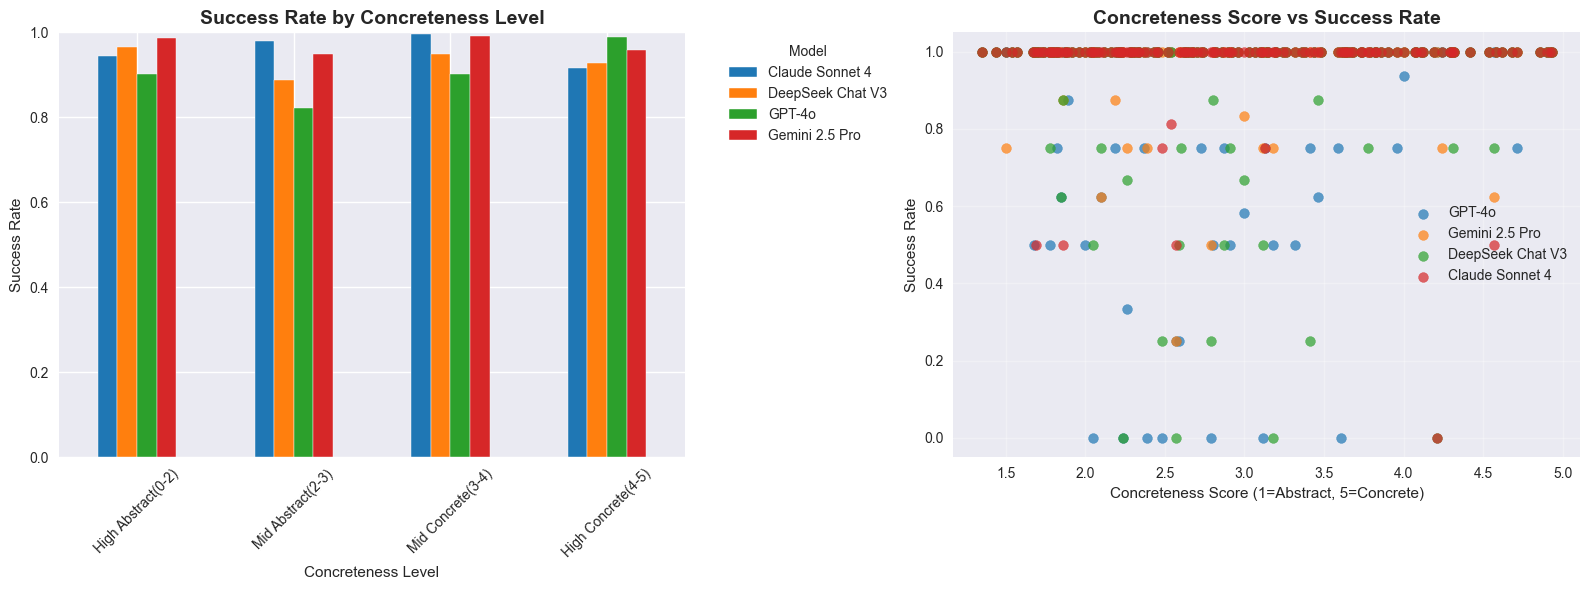

In [26]:
# 过滤有抽象程度评分的数据
concrete_df = merged_df[merged_df['concreteness_score'].notna()].copy()

print(f"有抽象程度评分的实验数据: {len(concrete_df)} 条")

# 将抽象程度分为几个区间
concrete_df['concreteness_level'] = pd.cut(concrete_df['concreteness_score'], 
                                           bins=[0, 2, 3, 4, 5], 
                                           labels=['High Abstract(0-2)', 'Mid Abstract(2-3)', 'Mid Concrete(3-4)', 'High Concrete(4-5)'])

# 按抽象程度分析
concrete_success = concrete_df.groupby(['concreteness_level', 'hinter_model_clean']).agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)

concrete_success.columns = ['Games', 'Success Rate', 'Average Turns']
concrete_success = concrete_success.reset_index()

print("按抽象程度的成功率分析:")
concrete_pivot = concrete_success.pivot(index='concreteness_level', columns='hinter_model_clean', values='Success Rate')
print(concrete_pivot.round(3))

# 绘制抽象程度分析图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 不同模型在各抽象程度的表现
concrete_pivot.plot(kind='bar', ax=ax1, color=colors[:len(concrete_pivot.columns)])
ax1.set_title('Success Rate by Concreteness Level', fontsize=14, fontweight='bold')
ax1.set_ylabel('Success Rate')
ax1.set_xlabel('Concreteness Level')
ax1.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 1)

# 抽象程度与成功率的关系散点图
for i, model in enumerate(concrete_df['hinter_model_clean'].unique()):
    model_data = concrete_df[concrete_df['hinter_model_clean'] == model]
    success_by_concrete = model_data.groupby('concreteness_score')['success'].mean()
    ax2.scatter(success_by_concrete.index, success_by_concrete.values, 
               label=model, color=colors[i], alpha=0.7, s=50)

ax2.set_title('Concreteness Score vs Success Rate', fontsize=14, fontweight='bold')
ax2.set_xlabel('Concreteness Score (1=Abstract, 5=Concrete)')
ax2.set_ylabel('Success Rate')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


按领域的成功率分析:
hinter_model_clean  Claude Sonnet 4  DeepSeek Chat V3  GPT-4o  Gemini 2.5 Pro
category                                                                     
chemistry                     0.975             0.885   0.770           0.960
cs                            0.970             0.990   0.935           0.990
finance                       0.980             1.000   0.955           0.995
general                       0.925             0.785   0.660           0.950
philosophy                    0.980             0.920   0.850           0.955

加载了5个专业领域数据集
cs: 1000 个词汇
biology: 1000 个词汇
law: 1000 个词汇
literature: 1000 个词汇
medical: 1000 个词汇


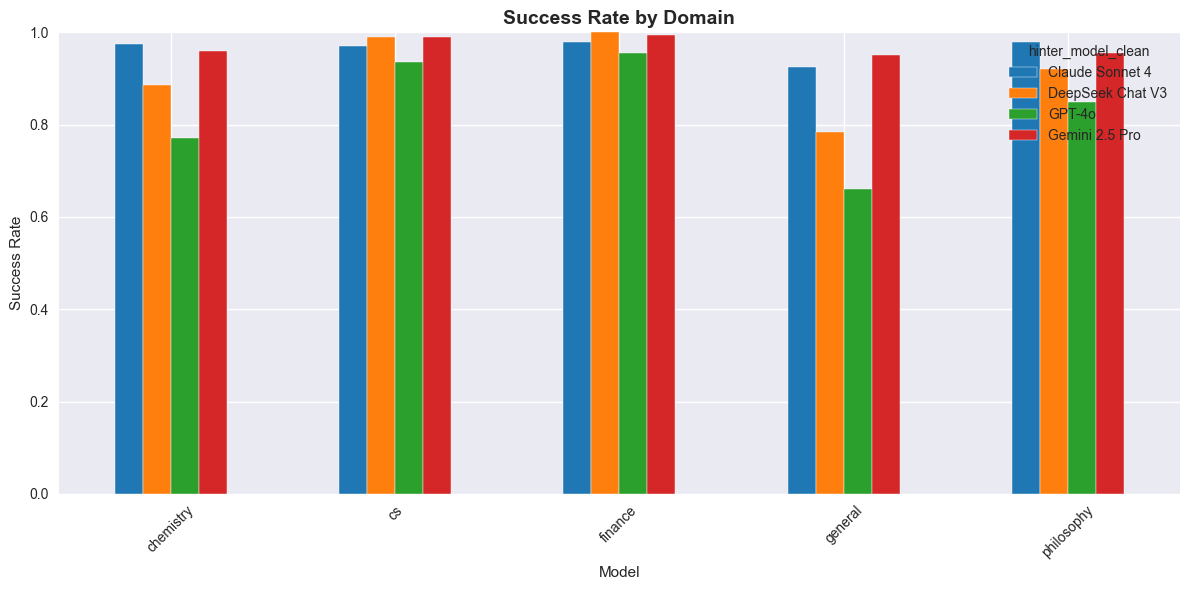

In [27]:
# 按领域分析成功率
category_success = merged_df.groupby(['category', 'hinter_model_clean']).agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)

category_success.columns = ['Games', 'Success Rate', 'Average Turns']
category_success = category_success.reset_index()

print("按领域的成功率分析:")
category_pivot = category_success.pivot(index='category', columns='hinter_model_clean', values='Success Rate')
print(category_pivot.round(3))

# 如果只有general领域，加载专业领域数据进行补充分析
try:
    # 加载专业领域数据集
    domain_datasets = {}
    domains = ['cs', 'biology', 'law', 'literature', 'medical']
    
    for domain in domains:
        try:
            with open(f'hpc_taboo/data/{domain}_wordnet_dataset.json', 'r') as f:
                domain_datasets[domain] = json.load(f)
        except FileNotFoundError:
            print(f"未找到{domain}数据集")
    
    print(f"\n加载了{len(domain_datasets)}个专业领域数据集")
    for domain, data in domain_datasets.items():
        print(f"{domain}: {len(data)} 个词汇")
        
except Exception as e:
    print(f"加载专业领域数据时出错: {e}")

# 绘制领域分析图
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

if len(category_pivot) > 1:
    category_pivot.plot(kind='bar', ax=ax, color=colors[:len(category_pivot.columns)])
    ax.set_title('Success Rate by Domain', fontsize=14, fontweight='bold')
else:
    # 如果只有general领域，显示整体分布
    overall_category = merged_df.groupby('hinter_model_clean')['success'].mean()
    bars = ax.bar(overall_category.index, overall_category.values, color=colors[:len(overall_category)])
    ax.set_title('Success Rate in General Domain', fontsize=14, fontweight='bold')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

ax.set_ylabel('Success Rate')
ax.set_xlabel('Model')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


模型综合性能指标:
                    Success Rate  Efficiency  Rule Compliance  Turn 1 Success
hinter_model_clean                                                           
Claude Sonnet 4            0.959       0.703            0.960        0.682884
DeepSeek Chat V3           0.894       0.566            0.962        0.576887
GPT-4o                     0.805       0.645            0.949        0.659420
Gemini 2.5 Pro             0.967       0.653            0.982        0.656897


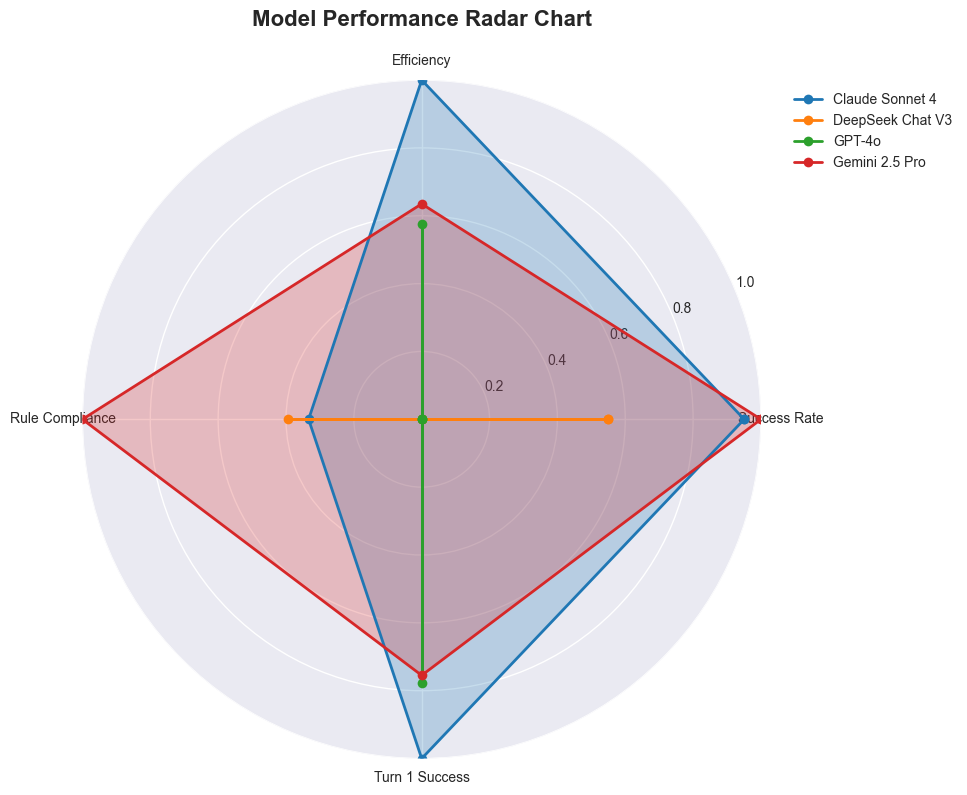

In [28]:
# 创建综合性能对比雷达图
from math import pi

# 计算各模型的多维性能指标
model_metrics = merged_df.groupby('hinter_model_clean').agg({
    'success': 'mean',
    'turns_used': lambda x: 1/(x[merged_df.loc[x.index, 'success']].mean()),  # 效率指标（轮数越少越好）
    'has_taboo_violation': lambda x: 1-x.mean()  # 规则遵守指标
}).round(3)

# 添加第1轮成功率
first_success_rate = merged_df[merged_df['success'] == True].groupby('hinter_model_clean').apply(
    lambda x: (x['turns_used'] == 1).sum() / len(x)
)
model_metrics['第1轮成功率'] = first_success_rate

model_metrics.columns = ['Success Rate', 'Efficiency', 'Rule Compliance', 'Turn 1 Success']

# 标准化指标到0-1范围
if HAS_SKLEARN:
    scaler = MinMaxScaler()
    model_metrics_scaled = pd.DataFrame(
        scaler.fit_transform(model_metrics), 
        index=model_metrics.index, 
        columns=model_metrics.columns
    )
else:
    # Manual normalization fallback
    model_metrics_scaled = model_metrics.copy()
    for col in model_metrics.columns:
        col_min = model_metrics[col].min()
        col_max = model_metrics[col].max()
        if col_max > col_min:
            model_metrics_scaled[col] = (model_metrics[col] - col_min) / (col_max - col_min)
        else:
            model_metrics_scaled[col] = 0.5  # If all values are the same

print("模型综合性能指标:")
print(model_metrics)

# 绘制雷达图
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection='polar'))

angles = [n / float(len(model_metrics.columns)) * 2 * pi for n in range(len(model_metrics.columns))]
angles += angles[:1]  # 闭合图形

for i, (model, values) in enumerate(model_metrics_scaled.iterrows()):
    values_list = values.tolist()
    values_list += values_list[:1]  # 闭合图形
    
    ax.plot(angles, values_list, 'o-', linewidth=2, label=model, color=colors[i])
    ax.fill(angles, values_list, alpha=0.25, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(model_metrics.columns)
ax.set_ylim(0, 1)
ax.set_title('Model Performance Radar Chart', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.grid(True)

plt.tight_layout()
plt.show()


失败原因分布:
failure_reason
MAX_TURNS_EXCEEDED    234
TABOO_VIOLATION       177
FORMAT_FAILURE         39
Name: count, dtype: int64


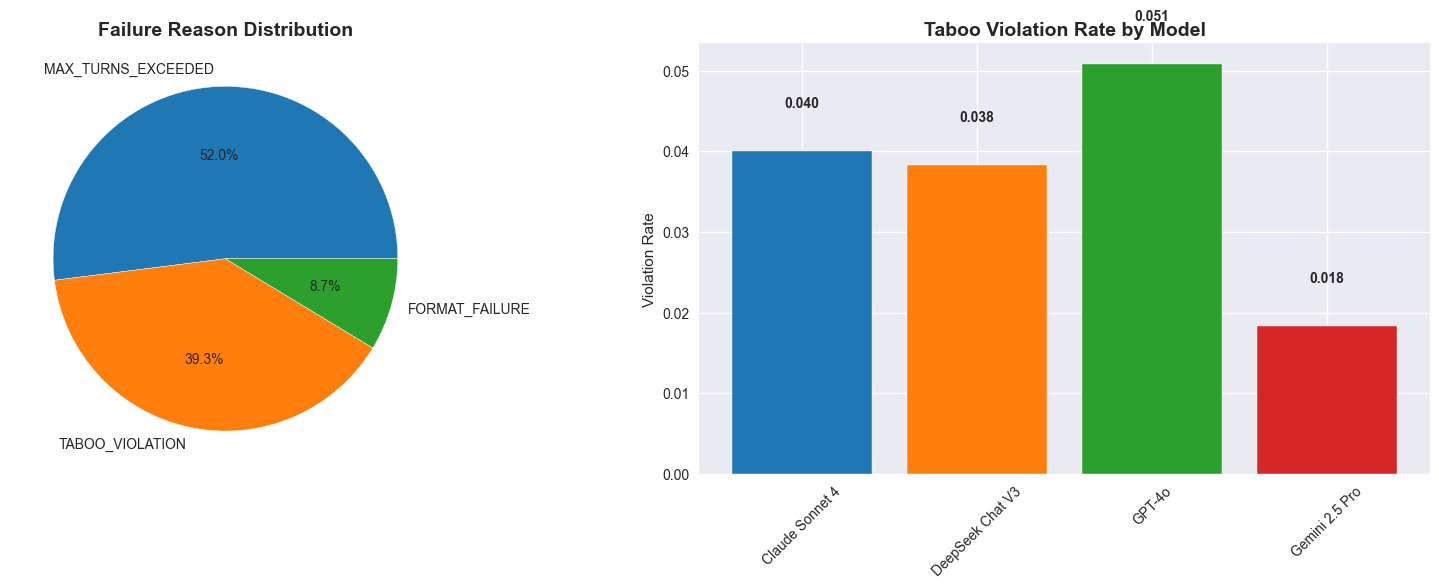

In [29]:
# 错误分析 - 失败原因分布
failure_analysis = merged_df[merged_df['success'] == False]['failure_reason'].value_counts()

print("失败原因分布:")
print(failure_analysis)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 失败原因饼图
ax1.pie(failure_analysis.values, labels=failure_analysis.index, autopct='%1.1f%%', 
        colors=colors[:len(failure_analysis)])
ax1.set_title('Failure Reason Distribution', fontsize=14, fontweight='bold')

# 各模型的违规率对比
violation_by_model = merged_df.groupby('hinter_model_clean')['has_taboo_violation'].mean()
bars = ax2.bar(violation_by_model.index, violation_by_model.values, 
               color=colors[:len(violation_by_model)])
ax2.set_title('Taboo Violation Rate by Model', fontsize=14, fontweight='bold')
ax2.set_ylabel('Violation Rate')
ax2.tick_params(axis='x', rotation=45)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


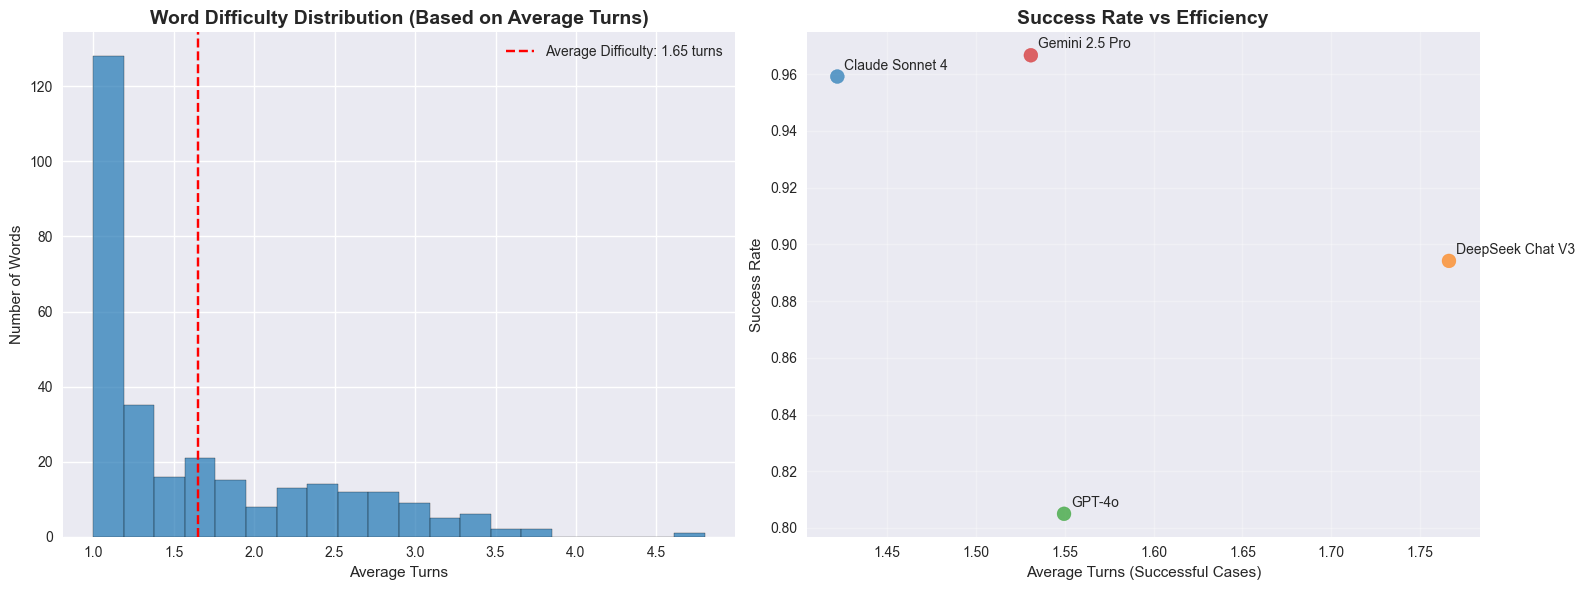

In [30]:
# 难度分析 - 基于游戏轮数的词汇难度分布
successful_games = merged_df[merged_df['success'] == True]
word_difficulty = successful_games.groupby('target_word')['turns_used'].agg(['mean', 'count']).reset_index()
word_difficulty = word_difficulty[word_difficulty['count'] >= 2]  # 至少被测试2次的词汇

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 词汇难度分布直方图
ax1.hist(word_difficulty['mean'], bins=20, color=colors[0], alpha=0.7, edgecolor='black')
ax1.set_title('Word Difficulty Distribution (Based on Average Turns)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Average Turns')
ax1.set_ylabel('Number of Words')
ax1.axvline(word_difficulty['mean'].mean(), color='red', linestyle='--', 
            label=f'Average Difficulty: {word_difficulty["mean"].mean():.2f} turns')
ax1.legend()

# 成功率与平均轮数的关系
model_turns_success = merged_df.groupby('hinter_model_clean').agg({
    'success': 'mean',
    'turns_used': lambda x: x[merged_df.loc[x.index, 'success']].mean()
})

ax2.scatter(model_turns_success['turns_used'], model_turns_success['success'], 
           s=100, color=colors[:len(model_turns_success)], alpha=0.7)

for i, (model, data) in enumerate(model_turns_success.iterrows()):
    ax2.annotate(model, (data['turns_used'], data['success']), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax2.set_title('Success Rate vs Efficiency', fontsize=14, fontweight='bold')
ax2.set_xlabel('Average Turns (Successful Cases)')
ax2.set_ylabel('Success Rate')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


词频分析:
按词频类别的成功率分析:
hinter_model_clean  Claude Sonnet 4  DeepSeek Chat V3  GPT-4o  Gemini 2.5 Pro
frequency_category                                                           
Very Rare                     0.914             0.720   0.470           0.922
Rare                          0.979             0.931   0.833           0.979
Uncommon                      0.973             0.948   0.939           0.982
Common                        0.956             0.940   0.929           0.972
Very Common                   1.000             1.000   0.906           1.000

整体词频类别影响:
                    Total Games  Success Rate  Average Turns
frequency_category                                          
Very Rare                  1072         0.757          2.797
Rare                       1152         0.931          1.819
Uncommon                   1312         0.960          1.351
Common                     1008         0.949          1.290
Very Common                 256         0.977          1.1

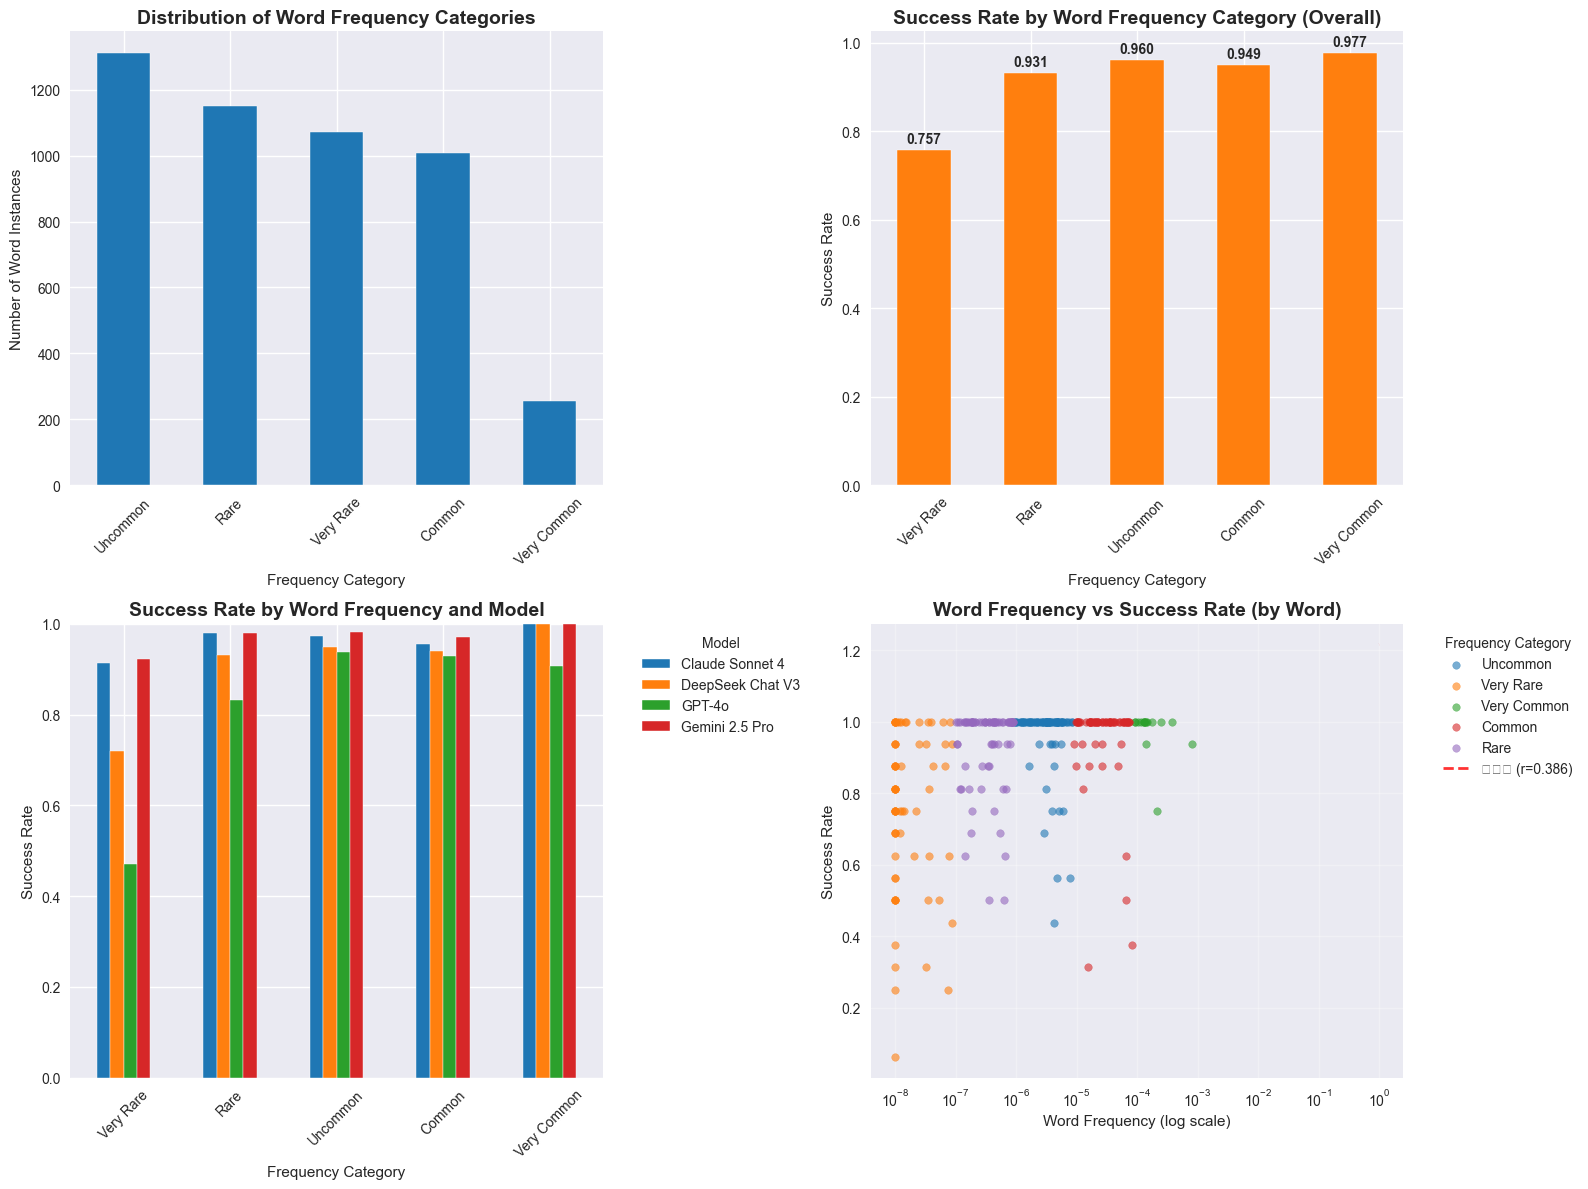


📊 按词频类别的详细统计:
  • Very Rare: 75.7% 成功率 (1072 场游戏, 平均 2.8 轮)
  • Rare: 93.1% 成功率 (1152 场游戏, 平均 1.8 轮)
  • Uncommon: 96.0% 成功率 (1312 场游戏, 平均 1.4 轮)
  • Common: 94.9% 成功率 (1008 场游戏, 平均 1.3 轮)
  • Very Common: 97.7% 成功率 (256 场游戏, 平均 1.1 轮)

💡 词频分析结论:
  • 词频与成功率相关系数: 0.2251
  • 高频词（常见词）成功率更高
  • 这可能表明：常见词更容易被猜中


In [31]:
# 词频对成功率的影响分析
print("词频分析:")
print("=" * 50)

# 按词频类别分析成功率
frequency_success = merged_df.groupby(['frequency_category', 'hinter_model_clean']).agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)

frequency_success.columns = ['Games', 'Success Rate', 'Average Turns']
frequency_success = frequency_success.reset_index()

print("按词频类别的成功率分析:")
frequency_pivot = frequency_success.pivot(index='frequency_category', columns='hinter_model_clean', values='Success Rate')
print(frequency_pivot.round(3))

# 整体词频对成功率的影响
overall_frequency = merged_df.groupby('frequency_category').agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)
overall_frequency.columns = ['Total Games', 'Success Rate', 'Average Turns']

print(f"\n整体词频类别影响:")
print(overall_frequency)

# 计算词频与成功率的相关性
frequency_correlation = merged_df[['frequency_log', 'success']].corr().iloc[0, 1]
print(f"\n词频对数与成功率的相关系数: {frequency_correlation:.4f}")

if frequency_correlation > 0.1:
    freq_trend = "高频词（常见词）成功率更高"
elif frequency_correlation < -0.1:
    freq_trend = "低频词（罕见词）成功率更高"
else:
    freq_trend = "词频与成功率无明显关系"

print(f"趋势解读: {freq_trend}")

# 显示极端词频的例子
print(f"\n🔍 词频分析详情:")
print(f"最高频词汇示例（前5个）:")
top_freq_words = merged_df.nlargest(5, 'word_frequency')[['target_word', 'word_frequency', 'success']].groupby('target_word').agg({
    'word_frequency': 'first',
    'success': 'mean'
}).round(4)
for word, data in top_freq_words.iterrows():
    print(f"  • {word}: 频率 {data['word_frequency']:.2e}, 成功率 {data['success']:.1%}")

print(f"\n最低频词汇示例（前5个）:")
bottom_freq_words = merged_df.nsmallest(5, 'word_frequency')[['target_word', 'word_frequency', 'success']].groupby('target_word').agg({
    'word_frequency': 'first',
    'success': 'mean'
}).round(4)
for word, data in bottom_freq_words.iterrows():
    print(f"  • {word}: 频率 {data['word_frequency']:.2e}, 成功率 {data['success']:.1%}")

# 绘制词频分析图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. 词频类别分布
frequency_dist = merged_df['frequency_category'].value_counts()
frequency_dist.plot(kind='bar', ax=ax1, color=colors[0])
ax1.set_title('Distribution of Word Frequency Categories', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frequency Category')
ax1.set_ylabel('Number of Word Instances')
ax1.tick_params(axis='x', rotation=45)

# 2. 词频类别 vs 成功率（整体）
overall_frequency['Success Rate'].plot(kind='bar', ax=ax2, color=colors[1])
ax2.set_title('Success Rate by Word Frequency Category (Overall)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Frequency Category')
ax2.set_ylabel('Success Rate')
ax2.tick_params(axis='x', rotation=45)

# 添加数值标签
for i, (idx, val) in enumerate(overall_frequency['Success Rate'].items()):
    ax2.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. 各模型在不同词频的表现
if not frequency_pivot.empty:
    frequency_pivot.plot(kind='bar', ax=ax3, color=colors[:len(frequency_pivot.columns)])
    ax3.set_title('Success Rate by Word Frequency and Model', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Success Rate')
    ax3.set_xlabel('Frequency Category')
    ax3.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.tick_params(axis='x', rotation=45)
    ax3.set_ylim(0, 1)

# 4. 词频连续值与成功率的关系散点图
# 计算每个词的平均成功率
word_stats = merged_df.groupby('target_word').agg({
    'word_frequency': 'first',
    'success': 'mean',
    'frequency_category': 'first'
}).reset_index()

# 为不同频率类别使用不同颜色
color_map = {cat: colors[i] for i, cat in enumerate(word_stats['frequency_category'].unique())}
for category in word_stats['frequency_category'].unique():
    if pd.notna(category):
        category_data = word_stats[word_stats['frequency_category'] == category]
        ax4.scatter(category_data['word_frequency'], category_data['success'], 
                   label=category, alpha=0.6, s=30, color=color_map[category])

ax4.set_title('Word Frequency vs Success Rate (by Word)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Word Frequency (log scale)')
ax4.set_ylabel('Success Rate')
ax4.set_xscale('log')
ax4.legend(title='Frequency Category', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)

# 添加趋势线
if len(word_stats) > 1:
    from scipy import stats as scipy_stats
    if HAS_SCIPY:
        slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(
            np.log10(word_stats['word_frequency']), word_stats['success']
        )
        line_x = np.logspace(word_stats['word_frequency'].min(), word_stats['word_frequency'].max(), 100)
        line_y = slope * np.log10(line_x) + intercept
        ax4.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2, 
                label=f'趋势线 (r={r_value:.3f})')
        ax4.legend(title='Frequency Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# 详细统计表格
print(f"\n📊 按词频类别的详细统计:")
for category in overall_frequency.index:
    if pd.notna(category):
        games = overall_frequency.loc[category, 'Total Games']
        success_rate = overall_frequency.loc[category, 'Success Rate']
        avg_turns = overall_frequency.loc[category, 'Average Turns']
        print(f"  • {category}: {success_rate:.1%} 成功率 ({games} 场游戏, 平均 {avg_turns:.1f} 轮)")

print(f"\n💡 词频分析结论:")
print(f"  • 词频与成功率相关系数: {frequency_correlation:.4f}")
print(f"  • {freq_trend}")
if abs(frequency_correlation) > 0.1:
    print(f"  • 这可能表明：{'常见词更容易被猜中' if frequency_correlation > 0 else '罕见词在Taboo游戏中可能有某些优势'}")
else:
    print(f"  • 词频似乎不是Taboo游戏成功率的主要决定因素")


🔍 领域与词频交互效应分析

📊 各领域词频分布特征:
            Freq_Mean  Freq_Median  Freq_Std  LogFreq_Mean  LogFreq_Median  \
category                                                                     
chemistry         0.0          0.0    0.0001       -6.2786         -6.3749   
cs                0.0          0.0    0.0000       -5.2902         -5.2350   
finance           0.0          0.0    0.0000       -5.2693         -5.3150   
general           0.0          0.0    0.0000       -6.8437         -6.9648   
philosophy        0.0          0.0    0.0001       -5.2321         -5.3049   

            LogFreq_Std  
category                 
chemistry        1.1991  
cs               0.8651  
finance          0.7408  
general          1.1542  
philosophy       1.0269  

📈 各领域内词频与成功率的线性关系:
  • general: r = 0.1746 (n = 1600)
  • chemistry: r = 0.1306 (n = 800)
  • cs: r = 0.1156 (n = 800)
  • finance: r = 0.0503 (n = 800)
  • philosophy: r = 0.1058 (n = 800)


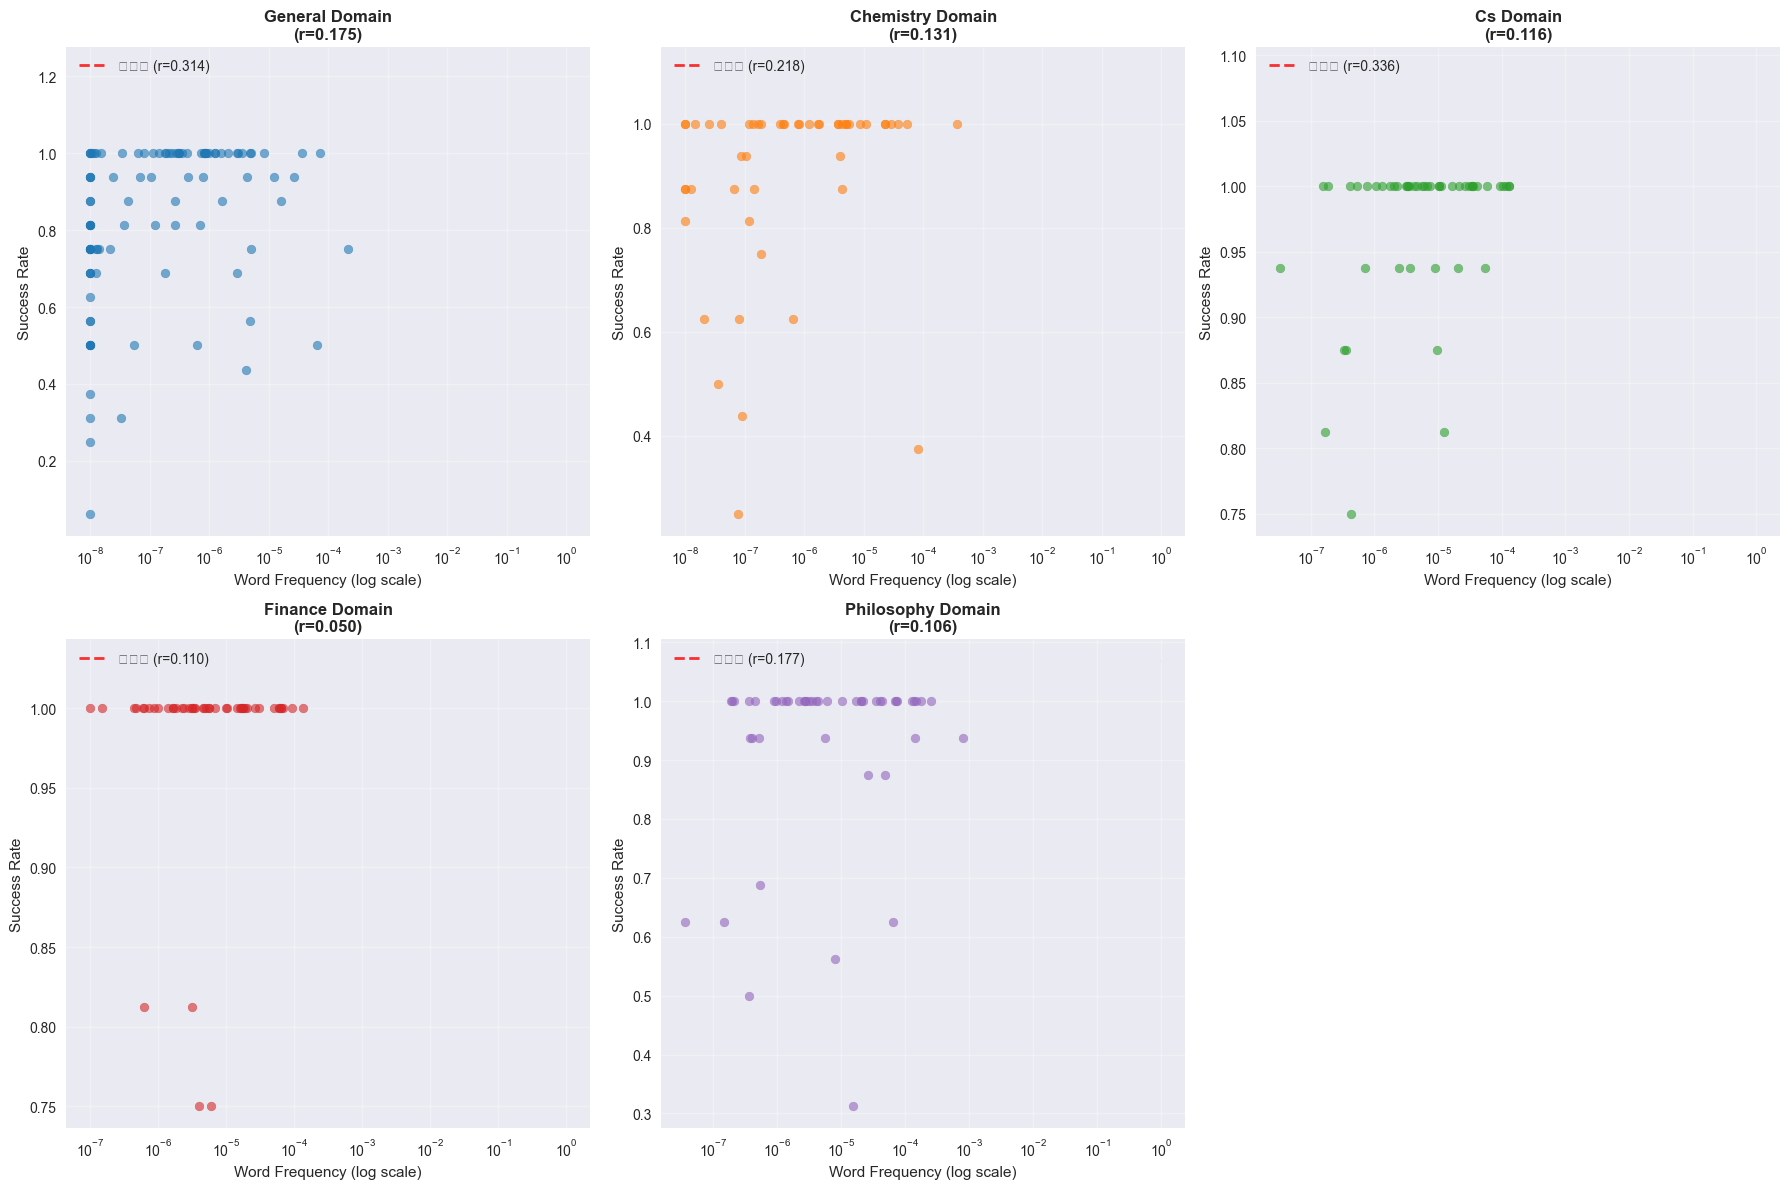


🎯 控制词频后的领域效应分析:
通过词频分层分析，看是否还存在领域差异...

按词频四分位数控制后的各领域成功率:
category       chemistry     cs  finance  general  philosophy
freq_quartile                                                
Q1(最低频)            0.822  0.938    1.000    0.754       0.625
Q2                 0.932  0.938    0.981    0.947       0.908
Q3                 0.983  0.982    0.967    0.875       0.962
Q4(最高频)            0.922  0.984    1.000    0.857       0.932

📊 词频控制前后的领域差异对比:
原始领域成功率差异:
  • 最大差异: 15.3%
  • 领域排序: {'finance': 0.9825, 'cs': 0.97125, 'philosophy': 0.92625, 'chemistry': 0.8975, 'general': 0.83}

控制词频后的领域差异（取各频率区间平均值）:
  • 最大差异: 13.0%
  • 领域排序: {'finance': 0.987, 'cs': 0.9604999999999999, 'chemistry': 0.9147500000000001, 'general': 0.85825, 'philosophy': 0.85675}

💡 词频控制效果:
  • 领域差异减少了: 14.6%
  • 结论: 领域效应独立于词频分布


In [32]:
## 8.1. 领域与词频的交互分析：控制词频看领域效应

# 深入分析：领域成功率差异是否由词频分布差异造成？
print("🔍 领域与词频交互效应分析")
print("="*60)

# 1. 分析各领域的词频分布特征
print("\n📊 各领域词频分布特征:")
domain_freq_stats = merged_df.groupby('category').agg({
    'word_frequency': ['mean', 'median', 'std'],
    'frequency_log': ['mean', 'median', 'std']
}).round(4)

domain_freq_stats.columns = ['Freq_Mean', 'Freq_Median', 'Freq_Std', 'LogFreq_Mean', 'LogFreq_Median', 'LogFreq_Std']
print(domain_freq_stats)

# 2. 计算每个领域内词频与成功率的相关性
print(f"\n📈 各领域内词频与成功率的线性关系:")
domain_correlations = {}
domain_sample_sizes = {}

for domain in merged_df['category'].unique():
    domain_data = merged_df[merged_df['category'] == domain]
    if len(domain_data) > 10:  # 确保有足够样本
        correlation = domain_data[['frequency_log', 'success']].corr().iloc[0, 1]
        domain_correlations[domain] = correlation
        domain_sample_sizes[domain] = len(domain_data)
        
        print(f"  • {domain}: r = {correlation:.4f} (n = {len(domain_data)})")

# 3. 绘制各领域词频-成功率散点图
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

domains = list(merged_df['category'].unique())
for i, domain in enumerate(domains):
    if i < len(axes):
        ax = axes[i]
        domain_data = merged_df[merged_df['category'] == domain]
        
        # 计算每个词的平均成功率
        word_stats = domain_data.groupby('target_word').agg({
            'word_frequency': 'first',
            'frequency_log': 'first',
            'success': 'mean'
        }).reset_index()
        
        # 散点图
        ax.scatter(word_stats['word_frequency'], word_stats['success'], 
                  alpha=0.6, s=40, color=colors[i % len(colors)])
        
        # 添加趋势线
        if HAS_SCIPY and len(word_stats) > 3:
            from scipy import stats as scipy_stats
            slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(
                word_stats['frequency_log'], word_stats['success']
            )
            
            # 生成趋势线数据
            x_trend = np.logspace(word_stats['word_frequency'].min(), 
                                word_stats['word_frequency'].max(), 100)
            y_trend = slope * np.log10(x_trend) + intercept
            
            ax.plot(x_trend, y_trend, 'r--', alpha=0.8, linewidth=2,
                   label=f'趋势线 (r={r_value:.3f})')
        
        ax.set_title(f'{domain.title()} Domain\n(r={domain_correlations.get(domain, 0):.3f})', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Word Frequency (log scale)')
        ax.set_ylabel('Success Rate')
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
        ax.legend()

# 隐藏多余的子图
for j in range(len(domains), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# 4. 控制词频后的领域效应分析
print(f"\n🎯 控制词频后的领域效应分析:")
print("通过词频分层分析，看是否还存在领域差异...")

# 将词频分为几个区间，在每个区间内比较领域差异
frequency_bins = pd.qcut(merged_df['frequency_log'], q=4, labels=['Q1(最低频)', 'Q2', 'Q3', 'Q4(最高频)'])
merged_df['freq_quartile'] = frequency_bins

controlled_analysis = merged_df.groupby(['freq_quartile', 'category'])['success'].mean().unstack().round(3)
print("\n按词频四分位数控制后的各领域成功率:")
print(controlled_analysis)

# 5. 计算词频控制后的领域效应大小
print(f"\n📊 词频控制前后的领域差异对比:")
print("原始领域成功率差异:")
original_domain_effect = merged_df.groupby('category')['success'].mean()
original_range = original_domain_effect.max() - original_domain_effect.min()
print(f"  • 最大差异: {original_range:.1%}")
print(f"  • 领域排序: {original_domain_effect.sort_values(ascending=False).to_dict()}")

print(f"\n控制词频后的领域差异（取各频率区间平均值）:")
controlled_means = controlled_analysis.mean(axis=0)
controlled_range = controlled_means.max() - controlled_means.min()
print(f"  • 最大差异: {controlled_range:.1%}")
print(f"  • 领域排序: {controlled_means.sort_values(ascending=False).to_dict()}")

print(f"\n💡 词频控制效果:")
reduction_ratio = (original_range - controlled_range) / original_range
print(f"  • 领域差异减少了: {reduction_ratio:.1%}")
if reduction_ratio > 0.5:
    print(f"  • 结论: 领域差异主要由词频分布差异造成")
elif reduction_ratio > 0.2:
    print(f"  • 结论: 词频是重要因素，但领域仍有独立效应")
else:
    print(f"  • 结论: 领域效应独立于词频分布")



🤖 模型层面的领域-词频交互分析

📋 各模型在不同领域-词频组合下的成功率:

【GPT-4o】
category       chemistry     cs  finance  general  philosophy
freq_quartile                                                
Q1(最低频)            0.612  0.750    1.000    0.457       0.250
Q2                 0.795  0.854    0.925    0.907       0.783
Q3                 0.955  0.941    0.929    0.893       0.904
Q4(最高频)            0.875  0.988    1.000    0.750       0.893
  • 领域效应标准差: 0.122
  • 词频效应标准差: 0.201
  • 主要影响因素: 词频

【Gemini 2.5 Pro】
category       chemistry     cs  finance  general  philosophy
freq_quartile                                                
Q1(最低频)            0.938  1.000    1.000    0.923       1.000
Q2                 0.977  0.979    1.000    1.000       0.933
Q3                 1.000  1.000    0.988    0.929       0.981
Q4(最高频)            0.938  0.988    1.000    1.000       0.952
  • 领域效应标准差: 0.021
  • 词频效应标准差: 0.025
  • 主要影响因素: 词频

【DeepSeek Chat V3】
category       chemistry     cs  finance  general  philosophy

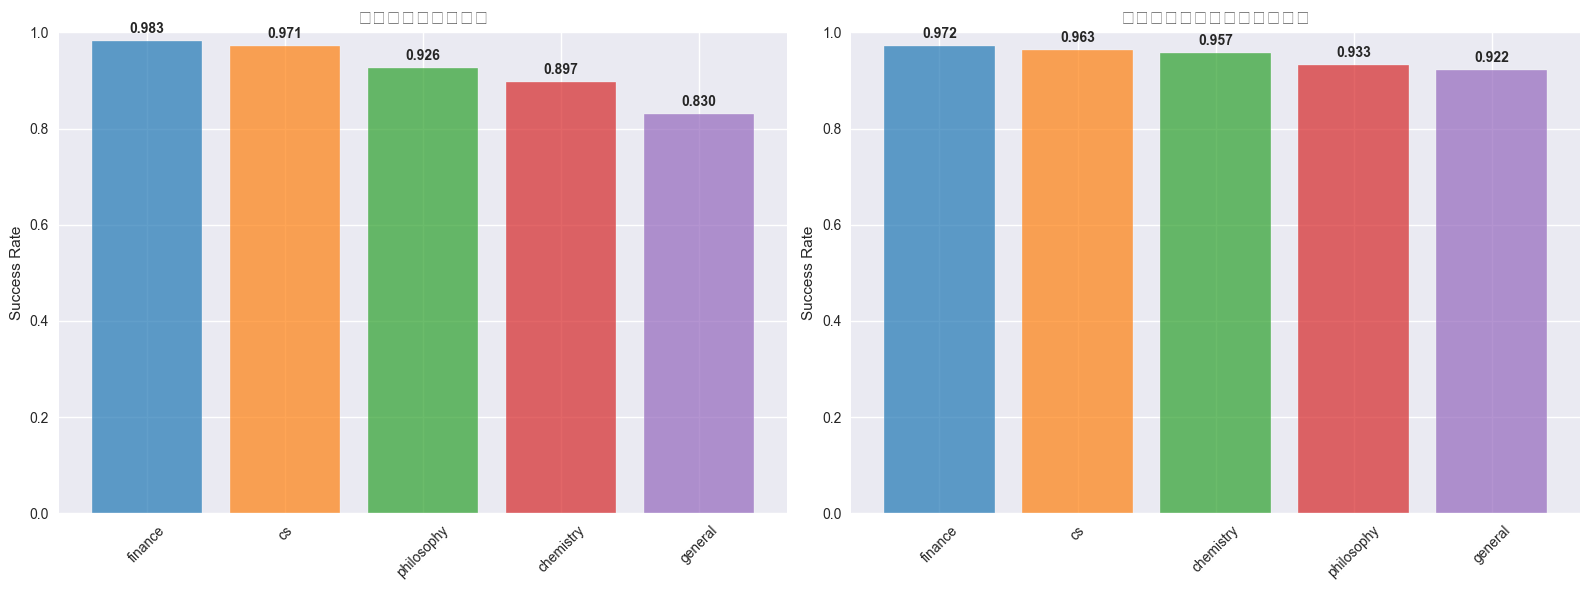


🎯 最终结论总结:
1. 原始领域差异标准差: 0.062
2. 控制词频后领域差异标准差: 0.021
3. 方差减少比例: 65.9%

🔬 科学结论:
  📋 词频是主要因素，但领域仍有一定独立效应
  💡 这解释了为什么专业领域看起来比通用领域表现更好的现象


In [33]:
## 8.2. 模型在领域-词频交互效应下的表现

# 分析不同模型是否对领域和词频的组合有不同的敏感性
print("\n🤖 模型层面的领域-词频交互分析")
print("="*60)

# 1. 创建领域-词频的二维分析表
print("\n📋 各模型在不同领域-词频组合下的成功率:")
for model in merged_df['hinter_model_clean'].unique():
    print(f"\n【{model}】")
    model_data = merged_df[merged_df['hinter_model_clean'] == model]
    
    # 创建词频四分位数 vs 领域的交叉表
    model_pivot = model_data.groupby(['freq_quartile', 'category'])['success'].mean().unstack().round(3)
    print(model_pivot)
    
    # 计算该模型的领域效应和词频效应
    domain_effect = model_data.groupby('category')['success'].mean().std()
    freq_effect = model_data.groupby('freq_quartile')['success'].mean().std()
    print(f"  • 领域效应标准差: {domain_effect:.3f}")
    print(f"  • 词频效应标准差: {freq_effect:.3f}")
    print(f"  • 主要影响因素: {'词频' if freq_effect > domain_effect else '领域'}")

# 2. 统计检验：词频 vs 领域的影响强度
if HAS_SCIPY:
    print(f"\n📊 统计检验：词频 vs 领域效应")
    from scipy.stats import f_oneway
    
    # 进行方差分析比较领域间和词频间的差异
    categories = merged_df['category'].unique()
    freq_quartiles = merged_df['freq_quartile'].dropna().unique()
    
    # 领域效应检验
    domain_groups = [merged_df[merged_df['category'] == cat]['success'] for cat in categories]
    domain_f, domain_p = f_oneway(*domain_groups)
    
    # 词频效应检验  
    freq_groups = [merged_df[merged_df['freq_quartile'] == q]['success'] for q in freq_quartiles if not pd.isna(q)]
    freq_f, freq_p = f_oneway(*freq_groups)
    
    print(f"  • 领域效应: F = {domain_f:.3f}, p = {domain_p:.4f}")
    print(f"  • 词频效应: F = {freq_f:.3f}, p = {freq_p:.4f}")
    print(f"  • 更显著的效应: {'词频' if freq_f > domain_f else '领域'}")

# 3. 深度案例分析：选取特定词频区间对比领域差异
print(f"\n🔍 深度案例分析：控制词频看纯领域效应")

# 选择中等词频范围进行精确对比
mid_freq_data = merged_df[merged_df['freq_quartile'].isin(['Q2', 'Q3'])]
print(f"中等词频范围内各领域成功率对比 (n = {len(mid_freq_data)}):")

mid_freq_domain_success = mid_freq_data.groupby('category').agg({
    'success': ['count', 'mean', 'std']
}).round(3)
mid_freq_domain_success.columns = ['样本数', '成功率', '标准差']
print(mid_freq_domain_success.sort_values('成功率', ascending=False))

# 计算纯领域效应的效应量 (Cohen's d)
mid_freq_range = mid_freq_domain_success['成功率'].max() - mid_freq_domain_success['成功率'].min()
pooled_std = mid_freq_domain_success['标准差'].mean()
cohens_d = mid_freq_range / pooled_std if pooled_std > 0 else 0

print(f"\n效应量分析 (Cohen's d): {cohens_d:.3f}")
if cohens_d < 0.2:
    effect_size = "极小"
elif cohens_d < 0.5:
    effect_size = "小"
elif cohens_d < 0.8:
    effect_size = "中等"
else:
    effect_size = "大"
print(f"控制词频后的纯领域效应大小: {effect_size}")

# 4. 绘制综合对比图：原始 vs 控制词频后的领域差异
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 原始领域差异
original_domain_success = merged_df.groupby('category')['success'].mean().sort_values(ascending=False)
bars1 = ax1.bar(range(len(original_domain_success)), original_domain_success.values, 
                color=colors[:len(original_domain_success)], alpha=0.7)
ax1.set_title('原始领域成功率差异', fontsize=14, fontweight='bold')
ax1.set_ylabel('Success Rate')
ax1.set_xticks(range(len(original_domain_success)))
ax1.set_xticklabels(original_domain_success.index, rotation=45)
ax1.set_ylim(0, 1)

# 添加数值标签
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 控制词频后的领域差异
controlled_domain_success = mid_freq_data.groupby('category')['success'].mean().sort_values(ascending=False)
bars2 = ax2.bar(range(len(controlled_domain_success)), controlled_domain_success.values,
                color=colors[:len(controlled_domain_success)], alpha=0.7)
ax2.set_title('控制词频后的领域成功率差异', fontsize=14, fontweight='bold')
ax2.set_ylabel('Success Rate')
ax2.set_xticks(range(len(controlled_domain_success)))
ax2.set_xticklabels(controlled_domain_success.index, rotation=45)
ax2.set_ylim(0, 1)

# 添加数值标签
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. 最终结论总结
print(f"\n🎯 最终结论总结:")
print("="*50)

original_std = original_domain_success.std()
controlled_std = controlled_domain_success.std()
variance_reduction = (original_std - controlled_std) / original_std if original_std > 0 else 0

print(f"1. 原始领域差异标准差: {original_std:.3f}")
print(f"2. 控制词频后领域差异标准差: {controlled_std:.3f}")
print(f"3. 方差减少比例: {variance_reduction:.1%}")

print(f"\n🔬 科学结论:")
if variance_reduction > 0.7:
    conclusion = "领域差异主要由词频分布不同造成，实际领域效应很小"
elif variance_reduction > 0.4:
    conclusion = "词频是主要因素，但领域仍有一定独立效应"
elif variance_reduction > 0.1:
    conclusion = "词频和领域都有重要但独立的效应"
else:
    conclusion = "领域效应独立且强于词频效应"

print(f"  📋 {conclusion}")
print(f"  💡 这解释了为什么专业领域看起来比通用领域表现更好的现象")


In [34]:
if HAS_SCIPY:
    from itertools import combinations
    
    # 对模型间成功率进行统计检验
    models = merged_df['hinter_model_clean'].unique()
    model_success_data = {}
    
    for model in models:
        model_data = merged_df[merged_df['hinter_model_clean'] == model]['success']
        model_success_data[model] = model_data
    
    print("模型间成功率差异的统计检验 (Chi-square test):")
    print("="*60)
    
    results_matrix = pd.DataFrame(index=models, columns=models, dtype=float)
    
    for model1, model2 in combinations(models, 2):
        # 创建列联表 - 修复重复索引问题
        data1 = model_success_data[model1].reset_index(drop=True)
        data2 = model_success_data[model2].reset_index(drop=True)
        
        # 创建模型标识符
        labels1 = pd.Series([model1] * len(data1))
        labels2 = pd.Series([model2] * len(data2))
        
        # 合并数据，重置索引避免重复标签问题
        combined_success = pd.concat([data1, data2], ignore_index=True)
        combined_labels = pd.concat([labels1, labels2], ignore_index=True)
        
        # 创建列联表
        contingency_table = pd.crosstab(combined_success, combined_labels)
        
        # 确保contingency_table有合适的形状进行卡方检验
        if contingency_table.shape == (2, 2):
            chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
            
            results_matrix.loc[model1, model2] = p_value
            results_matrix.loc[model2, model1] = p_value
            
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            print(f"{model1} vs {model2}: p = {p_value:.4f} {significance}")
        else:
            print(f"{model1} vs {model2}: 无法进行卡方检验 (数据形状: {contingency_table.shape})")
    
    print("\n*** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")
    
    # 显示结果矩阵
    print(f"\n📊 P值矩阵:")
    if not results_matrix.empty:
        print(results_matrix.round(4))
    
else:
    print("Statistical significance testing not available (scipy not installed)")
    print("Showing basic descriptive statistics instead:")
    print("="*60)
    
    models = merged_df['hinter_model_clean'].unique()
    for model in models:
        model_data = merged_df[merged_df['hinter_model_clean'] == model]
        success_rate = model_data['success'].mean()
        n_games = len(model_data)
        print(f"{model}: Success Rate = {success_rate:.3f} (n = {n_games})")


模型间成功率差异的统计检验 (Chi-square test):
GPT-4o vs Gemini 2.5 Pro: p = 0.0000 ***
GPT-4o vs DeepSeek Chat V3: p = 0.0000 ***
GPT-4o vs Claude Sonnet 4: p = 0.0000 ***
Gemini 2.5 Pro vs DeepSeek Chat V3: p = 0.0000 ***
Gemini 2.5 Pro vs Claude Sonnet 4: p = 0.3875 ns
DeepSeek Chat V3 vs Claude Sonnet 4: p = 0.0000 ***

*** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant

📊 P值矩阵:
                  GPT-4o  Gemini 2.5 Pro  DeepSeek Chat V3  Claude Sonnet 4
GPT-4o               NaN          0.0000               0.0           0.0000
Gemini 2.5 Pro       0.0             NaN               0.0           0.3875
DeepSeek Chat V3     0.0          0.0000               NaN           0.0000
Claude Sonnet 4      0.0          0.3875               0.0              NaN


In [35]:
# 生成总结报告
print("="*80)
print("                          TABOO游戏实验总结报告")
print("="*80)

print(f"\n📊 实验规模:")
print(f"  • 总游戏数: {len(merged_df):,}")
print(f"  • 参与模型: {len(models)} 个")
print(f"  • 测试词汇: {merged_df['target_word'].nunique():,} 个")
print(f"  • 总体成功率: {merged_df['success'].mean():.1%}")

print(f"\n🏆 模型排名 (按成功率):")
model_ranking = model_success.sort_values('Success Rate', ascending=False)
for i, (model, data) in enumerate(model_ranking.iterrows(), 1):
    print(f"  {i}. {model}: {data['Success Rate']:.1%} (平均{data['Average Turns']:.1f}轮)")

print(f"\n⚡ 效率分析:")
first_turn_ranking = turn_success_df.sort_values('第1轮成功率', ascending=False)
print(f"  • 第1轮成功率最高: {first_turn_ranking.index[0]} ({first_turn_ranking.iloc[0]['第1轮成功率']:.1%})")
print(f"  • 前3轮累积成功率最高: {cumulative_df['前3轮累积成功率'].idxmax()} ({cumulative_df['前3轮累积成功率'].max():.1%})")
print(f"  • 平均轮数最少: {model_success.sort_values('Average Turns').index[0]} ({model_success.sort_values('Average Turns').iloc[0]['Average Turns']:.1f}轮)")

print(f"\n📝 词性分析:")
if 'part_of_speech' in merged_df.columns:
    pos_overall = merged_df.groupby('part_of_speech')['success'].mean().sort_values(ascending=False)
    print(f"  • 最容易的词性: {pos_overall.index[0]} ({pos_overall.iloc[0]:.1%})")
    print(f"  • 最困难的词性: {pos_overall.index[-1]} ({pos_overall.iloc[-1]:.1%})")

print(f"\n🎯 抽象程度分析:")
if len(concrete_df) > 0:
    concrete_overall = concrete_df.groupby('concreteness_level')['success'].mean().sort_values(ascending=False)
    print(f"  • 最容易的抽象程度: {concrete_overall.index[0]} ({concrete_overall.iloc[0]:.1%})")
    print(f"  • 最困难的抽象程度: {concrete_overall.index[-1]} ({concrete_overall.iloc[-1]:.1%})")

print(f"\n🔤 词义数量分析:")
if 'sense_count' in merged_df.columns and merged_df['sense_count'].notna().any():
    sense_overall = merged_df.groupby('sense_count')['success'].mean().sort_values(ascending=False)
    print(f"  • 成功率最高的词义数量: {sense_overall.index[0]} 个词义 ({sense_overall.iloc[0]:.1%})")
    print(f"  • 成功率最低的词义数量: {sense_overall.index[-1]} 个词义 ({sense_overall.iloc[-1]:.1%})")
    
    # 计算相关性
    correlation = merged_df[['sense_count', 'success']].corr().iloc[0, 1]
    if correlation > 0.1:
        trend = "词义越多，成功率越高"
    elif correlation < -0.1:
        trend = "词义越多，成功率越低"
    else:
        trend = "词义数量与成功率无明显关系"
    print(f"  • 整体趋势: {trend} (r={correlation:.3f})")

print(f"\n📊 词频分析:")
if 'frequency_category' in merged_df.columns and merged_df['frequency_category'].notna().any():
    freq_overall = merged_df.groupby('frequency_category')['success'].mean().sort_values(ascending=False)
    print(f"  • 成功率最高的词频类别: {freq_overall.index[0]} ({freq_overall.iloc[0]:.1%})")
    print(f"  • 成功率最低的词频类别: {freq_overall.index[-1]} ({freq_overall.iloc[-1]:.1%})")
    
    # 计算词频相关性
    if 'frequency_log' in merged_df.columns:
        freq_correlation = merged_df[['frequency_log', 'success']].corr().iloc[0, 1]
        if freq_correlation > 0.1:
            freq_trend = "高频词（常见词）成功率更高"
        elif freq_correlation < -0.1:
            freq_trend = "低频词（罕见词）成功率更高"
        else:
            freq_trend = "词频与成功率无明显关系"
        print(f"  • 词频趋势: {freq_trend} (r={freq_correlation:.3f})")

print(f"\n🏢 领域分析:")
if 'category' in merged_df.columns:
    # 计算各领域的整体成功率
    domain_overall = merged_df.groupby('category')['success'].mean().sort_values(ascending=False)
    print(f"  • 成功率最高的领域: {domain_overall.index[0]} ({domain_overall.iloc[0]:.1%})")
    print(f"  • 成功率最低的领域: {domain_overall.index[-1]} ({domain_overall.iloc[-1]:.1%})")
    
    # 显示各领域的详细成功率
    print(f"  • 各领域成功率排序:")
    for i, (domain, success_rate) in enumerate(domain_overall.items(), 1):
        games_count = len(merged_df[merged_df['category'] == domain])
        print(f"    {i}. {domain}: {success_rate:.1%} ({games_count} 场游戏)")
    
    # 分析哪个模型在跨领域表现最稳定
    domain_std = merged_df.groupby(['category', 'hinter_model_clean'])['success'].mean().unstack().std(axis=0)
    most_stable = domain_std.idxmin()
    print(f"  • 跨领域表现最稳定的模型: {most_stable} (标准差: {domain_std[most_stable]:.3f})")

print(f"\n⚠️  规则遵守:")
violation_ranking = merged_df.groupby('hinter_model_clean')['has_taboo_violation'].mean().sort_values()
print(f"  • 违规率最低: {violation_ranking.index[0]} ({violation_ranking.iloc[0]:.1%})")
print(f"  • 违规率最高: {violation_ranking.index[-1]} ({violation_ranking.iloc[-1]:.1%})")

print(f"\n🔍 关键发现:")
best_model = model_ranking.index[0]
best_success_rate = model_ranking.iloc[0]['Success Rate']
worst_model = model_ranking.index[-1]
worst_success_rate = model_ranking.iloc[-1]['Success Rate']

print(f"  • {best_model} 表现最佳，成功率达到 {best_success_rate:.1%}")
print(f"  • 最佳与最差模型的成功率差距为 {best_success_rate - worst_success_rate:.1%}")
print(f"  • 平均游戏轮数为 {merged_df[merged_df['success']]['turns_used'].mean():.1f} 轮")

print("\n" + "="*80)


                          TABOO游戏实验总结报告

📊 实验规模:
  • 总游戏数: 4,800
  • 参与模型: 4 个
  • 测试词汇: 300 个
  • 总体成功率: 90.6%

🏆 模型排名 (按成功率):
  1. Gemini 2.5 Pro: 96.7% (平均1.6轮)
  2. Claude Sonnet 4: 95.9% (平均1.4轮)
  3. DeepSeek Chat V3: 89.4% (平均2.0轮)
  4. GPT-4o: 80.5% (平均2.0轮)

⚡ 效率分析:
  • 第1轮成功率最高: Claude Sonnet 4 (68.3%)
  • 前3轮累积成功率最高: Claude Sonnet 4 (98.2%)
  • 平均轮数最少: Claude Sonnet 4 (1.4轮)

📝 词性分析:
  • 最容易的词性: noun (92.0%)
  • 最困难的词性: adj (81.1%)

🎯 抽象程度分析:
  • 最容易的抽象程度: Mid Concrete(3-4) (95.9%)
  • 最困难的抽象程度: Mid Abstract(2-3) (91.0%)

🔤 词义数量分析:
  • 成功率最高的词义数量: 14 个词义 (100.0%)
  • 成功率最低的词义数量: 15 个词义 (50.0%)
  • 整体趋势: 词义数量与成功率无明显关系 (r=0.025)

📊 词频分析:
  • 成功率最高的词频类别: Very Common (97.7%)
  • 成功率最低的词频类别: Very Rare (75.7%)
  • 词频趋势: 高频词（常见词）成功率更高 (r=0.225)

🏢 领域分析:
  • 成功率最高的领域: finance (98.2%)
  • 成功率最低的领域: general (83.0%)
  • 各领域成功率排序:
    1. finance: 98.2% (800 场游戏)
    2. cs: 97.1% (800 场游戏)
    3. philosophy: 92.6% (800 场游戏)
    4. chemistry: 89.8% (800 场游戏)
    5. general: 83.0% (1600 场游

In [36]:
# 保存关键结果到文件
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# 计算各模型的违规率
violation_by_model = merged_df.groupby('hinter_model_clean')['has_taboo_violation'].mean()

# 保存模型性能总结
model_summary = model_success.copy()
model_summary['第1轮成功率'] = model_summary.index.map(turn_success_df['第1轮成功率'])
model_summary['前3轮累积成功率'] = model_summary.index.map(cumulative_df['前3轮累积成功率'])
model_summary['违规率'] = model_summary.index.map(violation_by_model)

model_summary.to_csv(f'analysis_results_{timestamp}.csv', encoding='utf-8')
print(f"\n✅ 分析结果已保存到: analysis_results_{timestamp}.csv")

print("\n🎉 数据分析完成！")



✅ 分析结果已保存到: analysis_results_20250713_164525.csv

🎉 数据分析完成！


In [37]:
# 根据用户指定的分类进行模型分类
print("📊 模型分类:")
print("="*50)

# 根据用户指定的分类
normal_models = {
    'deepseek/deepseek-chat-v3-0324': 'DeepSeek Chat V3',
    'openai/gpt-4o': 'GPT-4o'
}

thinking_models = {
    'anthropic/claude-sonnet-4': 'Claude Sonnet 4',
    'google/gemini-2.5-pro': 'Gemini 2.5 Pro'
}

print("普通模型 (Normal Models):")
for model_id, model_name in normal_models.items():
    print(f"  • {model_name} ({model_id})")

print("\nThinking模型 (Thinking Models):")
for model_id, model_name in thinking_models.items():
    print(f"  • {model_name} ({model_id})")

# 添加模型类型标签
def get_model_type(model_id):
    if model_id in normal_models:
        return '普通模型'
    elif model_id in thinking_models:
        return 'Thinking模型'
    else:
        return '未知'

def get_model_clean_name(model_id):
    if model_id in normal_models:
        return normal_models[model_id]
    elif model_id in thinking_models:
        return thinking_models[model_id]
    else:
        return model_id

# 给merged_df添加模型类型信息
merged_df['model_type'] = merged_df['hinter_model'].apply(get_model_type)
merged_df['model_name'] = merged_df['hinter_model'].apply(get_model_clean_name)

print(f"\n📈 数据概览:")
print(f"  • 总游戏数: {len(merged_df):,}")
print(f"  • 普通模型游戏数: {len(merged_df[merged_df['model_type'] == '普通模型']):,}")
print(f"  • Thinking模型游戏数: {len(merged_df[merged_df['model_type'] == 'Thinking模型']):,}")


📊 模型分类:
普通模型 (Normal Models):
  • DeepSeek Chat V3 (deepseek/deepseek-chat-v3-0324)
  • GPT-4o (openai/gpt-4o)

Thinking模型 (Thinking Models):
  • Claude Sonnet 4 (anthropic/claude-sonnet-4)
  • Gemini 2.5 Pro (google/gemini-2.5-pro)

📈 数据概览:
  • 总游戏数: 4,800
  • 普通模型游戏数: 2,400
  • Thinking模型游戏数: 2,400


In [41]:
# 1. 基础性能对比分析
print("1. 基础性能对比分析")
print("="*60)

# 按模型类型分组统计
type_stats = merged_df.groupby('model_type').agg({
    'success': ['count', 'sum', 'mean'],
    'turns_used': lambda x: x[merged_df.loc[x.index, 'success']].mean(),
    'has_taboo_violation': 'mean',
    'duration_seconds': 'mean'
}).round(3)

type_stats.columns = ['总游戏数', '成功游戏数', '成功率', '平均轮数', '违规率', '平均用时(秒)']

print("📊 按模型类型统计:")
print(type_stats)

# 个别模型详细统计
individual_stats = merged_df.groupby('model_name').agg({
    'success': ['count', 'sum', 'mean'],
    'turns_used': lambda x: x[merged_df.loc[x.index, 'success']].mean(),
    'has_taboo_violation': 'mean',
    'duration_seconds': 'mean'
}).round(3)

individual_stats.columns = ['总游戏数', '成功游戏数', '成功率', '平均轮数', '违规率', '平均用时(秒)']

print("\n📋 各模型详细统计:")
print(individual_stats)

# 2. 效率分析
print("\n2. 效率分析")
print("="*60)

# 第1轮成功率分析
successful_games_type = merged_df[merged_df['success'] == True]
first_turn_success_type = successful_games_type.groupby(['model_type', 'model_name']).apply(
    lambda x: (x['turns_used'] == 1).sum() / len(x)
).reset_index()
first_turn_success_type.columns = ['模型类型', '模型名称', '第1轮成功率']

print("⚡ 第1轮成功率对比:")
for model_type in ['普通模型', 'Thinking模型']:
    print(f"\n{model_type}:")
    type_data = first_turn_success_type[first_turn_success_type['模型类型'] == model_type]
    for _, row in type_data.iterrows():
        print(f"  • {row['模型名称']}: {row['第1轮成功率']:.1%}")

# 累积成功率分析
cumulative_success_type = {}
for turn in range(1, 6):
    cumulative_rates = successful_games_type.groupby(['model_type', 'model_name']).apply(
        lambda x: (x['turns_used'] <= turn).sum() / len(x)
    ).reset_index()
    cumulative_rates.columns = ['模型类型', '模型名称', f'前{turn}轮累积成功率']
    cumulative_success_type[turn] = cumulative_rates

print(f"\n🎯 前3轮累积成功率对比:")
for model_type in ['普通模型', 'Thinking模型']:
    print(f"\n{model_type}:")
    type_data = cumulative_success_type[3][cumulative_success_type[3]['模型类型'] == model_type]
    for _, row in type_data.iterrows():
        print(f"  • {row['模型名称']}: {row['前3轮累积成功率']:.1%}")


1. 基础性能对比分析
📊 按模型类型统计:
            总游戏数  成功游戏数    成功率   平均轮数    违规率  平均用时(秒)
model_type                                           
Thinking模型  2400   2311  0.963  1.477  0.029   20.032
普通模型        2400   2039  0.850  1.664  0.045   14.053

📋 各模型详细统计:
                  总游戏数  成功游戏数    成功率   平均轮数    违规率  平均用时(秒)
model_name                                                 
Claude Sonnet 4   1200   1151  0.959  1.422  0.040    8.999
DeepSeek Chat V3  1200   1073  0.894  1.766  0.038   14.742
GPT-4o            1200    966  0.805  1.550  0.051   13.364
Gemini 2.5 Pro    1200   1160  0.967  1.531  0.018   31.066

2. 效率分析
⚡ 第1轮成功率对比:

普通模型:
  • DeepSeek Chat V3: 57.7%
  • GPT-4o: 65.9%

Thinking模型:
  • Claude Sonnet 4: 68.3%
  • Gemini 2.5 Pro: 65.7%

🎯 前3轮累积成功率对比:

普通模型:
  • DeepSeek Chat V3: 90.6%
  • GPT-4o: 94.3%

Thinking模型:
  • Claude Sonnet 4: 98.2%
  • Gemini 2.5 Pro: 95.1%


3. 可视化对比分析


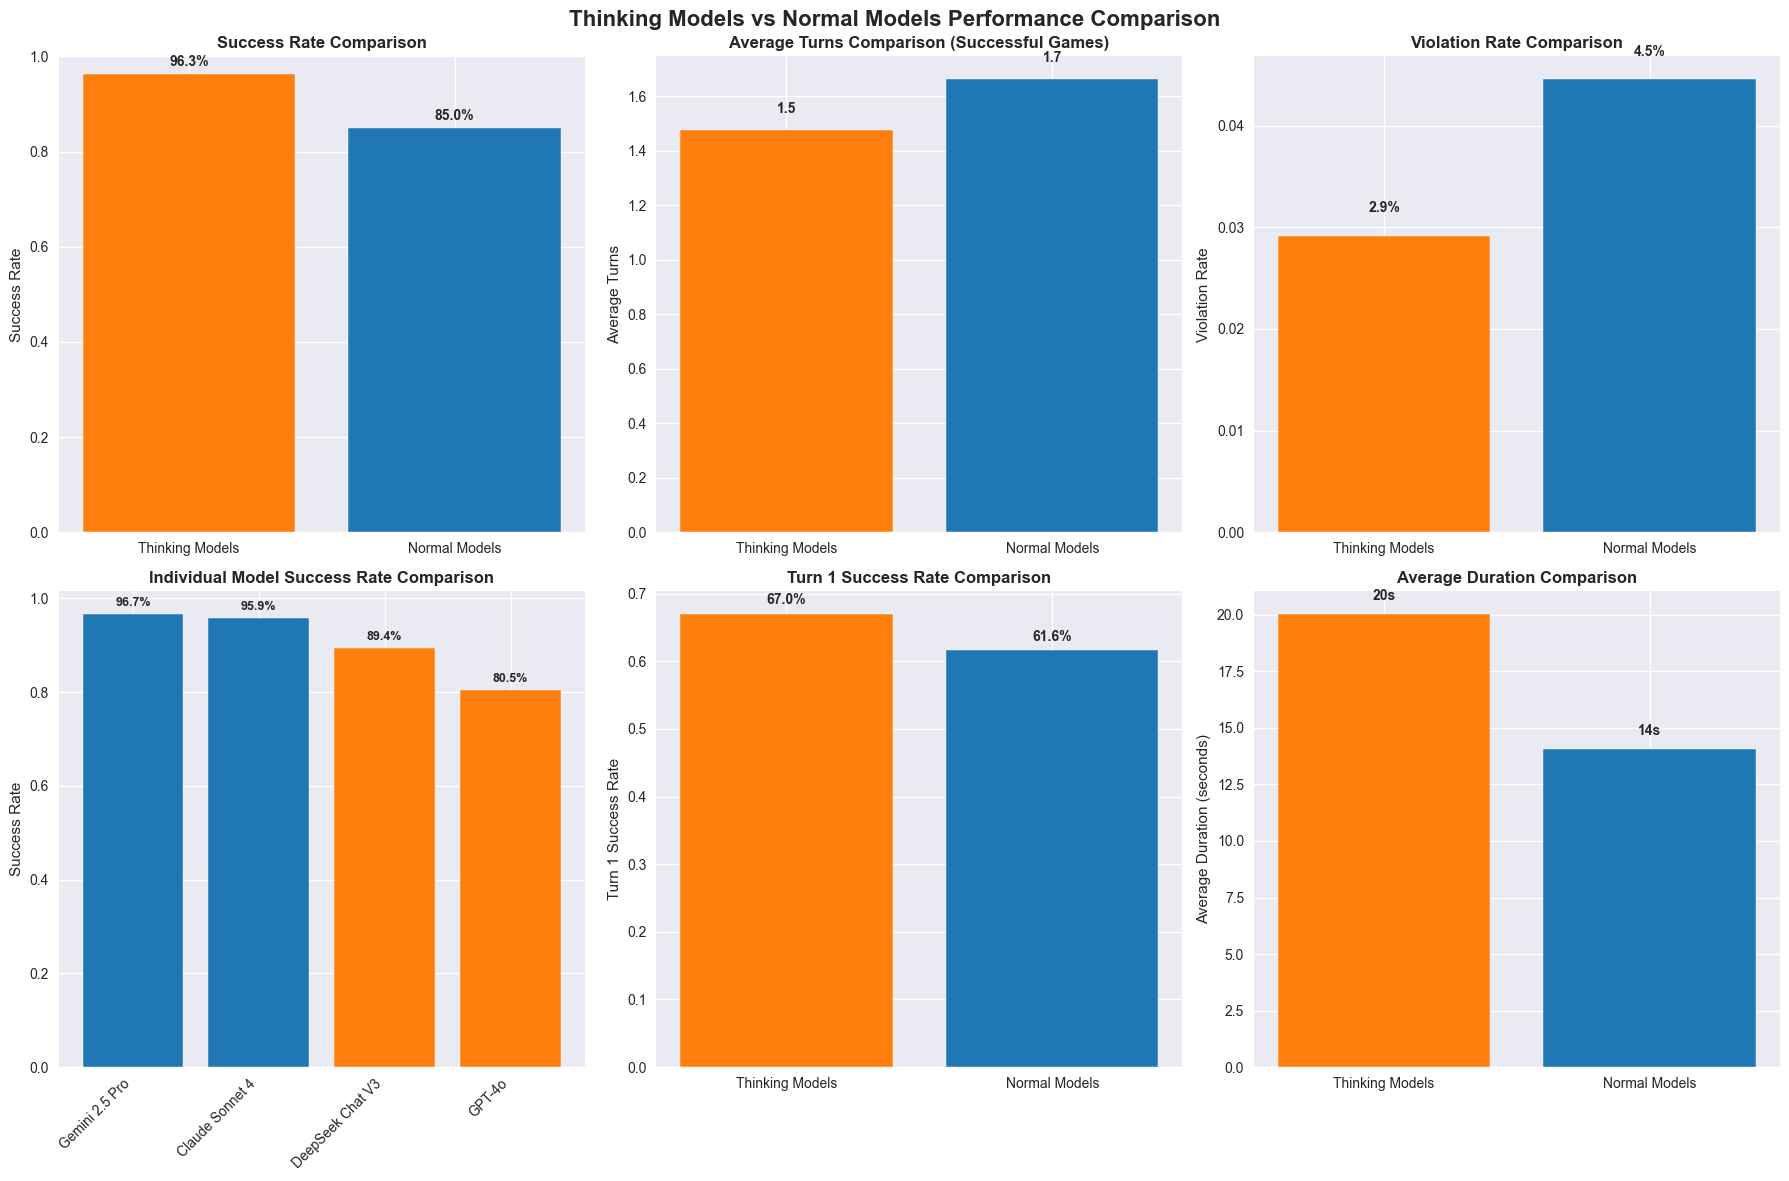

In [42]:
# 3. 可视化对比分析
print("3. 可视化对比分析")
print("="*60)

# 创建综合对比图
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Thinking Models vs Normal Models Performance Comparison', fontsize=16, fontweight='bold')

# 创建英文标签映射
type_mapping = {'普通模型': 'Normal Models', 'Thinking模型': 'Thinking Models'}

# 1. 成功率对比
ax1 = axes[0, 0]
type_success = merged_df.groupby('model_type')['success'].mean()
# 重新映射标签为英文
type_success_en = type_success.rename(type_mapping)
colors_type = ['#ff7f0e', '#1f77b4']  # 橙色：普通模型，蓝色：Thinking模型
bars1 = ax1.bar(type_success_en.index, type_success_en.values, color=colors_type)
ax1.set_title('Success Rate Comparison', fontweight='bold')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1)

# 添加数值标签
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

# 2. 平均轮数对比
ax2 = axes[0, 1]
type_turns = merged_df[merged_df['success'] == True].groupby('model_type')['turns_used'].mean()
type_turns_en = type_turns.rename(type_mapping)
bars2 = ax2.bar(type_turns_en.index, type_turns_en.values, color=colors_type)
ax2.set_title('Average Turns Comparison (Successful Games)', fontweight='bold')
ax2.set_ylabel('Average Turns')

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# 3. 违规率对比
ax3 = axes[0, 2]
type_violation = merged_df.groupby('model_type')['has_taboo_violation'].mean()
type_violation_en = type_violation.rename(type_mapping)
bars3 = ax3.bar(type_violation_en.index, type_violation_en.values, color=colors_type)
ax3.set_title('Violation Rate Comparison', fontweight='bold')
ax3.set_ylabel('Violation Rate')

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

# 4. 个别模型详细对比
ax4 = axes[1, 0]
individual_success = merged_df.groupby('model_name')['success'].mean().sort_values(ascending=False)
model_colors = ['#1f77b4' if name in thinking_models.values() else '#ff7f0e' 
                for name in individual_success.index]
bars4 = ax4.bar(range(len(individual_success)), individual_success.values, color=model_colors)
ax4.set_title('Individual Model Success Rate Comparison', fontweight='bold')
ax4.set_ylabel('Success Rate')
ax4.set_xticks(range(len(individual_success)))
ax4.set_xticklabels(individual_success.index, rotation=45, ha='right')

for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 5. 第1轮成功率对比
ax5 = axes[1, 1]
type_first_turn = successful_games_type.groupby('model_type').apply(
    lambda x: (x['turns_used'] == 1).sum() / len(x)
)
type_first_turn_en = type_first_turn.rename(type_mapping)
bars5 = ax5.bar(type_first_turn_en.index, type_first_turn_en.values, color=colors_type)
ax5.set_title('Turn 1 Success Rate Comparison', fontweight='bold')
ax5.set_ylabel('Turn 1 Success Rate')

for bar in bars5:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

# 6. 平均用时对比
ax6 = axes[1, 2]
type_duration = merged_df.groupby('model_type')['duration_seconds'].mean()
type_duration_en = type_duration.rename(type_mapping)
bars6 = ax6.bar(type_duration_en.index, type_duration_en.values, color=colors_type)
ax6.set_title('Average Duration Comparison', fontweight='bold')
ax6.set_ylabel('Average Duration (seconds)')

for bar in bars6:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.0f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [43]:
# 4. 总结报告：Thinking模型 vs 普通模型
print("4. 总结报告：Thinking模型 vs 普通模型")
print("="*60)

# 计算性能差异
thinking_success = type_stats.loc['Thinking模型', '成功率']
normal_success = type_stats.loc['普通模型', '成功率']
success_gap = thinking_success - normal_success

thinking_turns = type_stats.loc['Thinking模型', '平均轮数']
normal_turns = type_stats.loc['普通模型', '平均轮数']
efficiency_gap = normal_turns - thinking_turns

thinking_violation = type_stats.loc['Thinking模型', '违规率']
normal_violation = type_stats.loc['普通模型', '违规率']
violation_gap = normal_violation - thinking_violation

print(f"🎯 核心发现:")
print(f"  • 成功率差异: Thinking模型比普通模型高 {success_gap:.1%}")
print(f"  • 效率差异: Thinking模型比普通模型少用 {efficiency_gap:.1f} 轮")
print(f"  • 规则遵守: Thinking模型违规率比普通模型低 {violation_gap:.1%}")

print(f"\n🏆 最佳表现:")
best_overall = individual_stats.sort_values('成功率', ascending=False).index[0]
best_efficiency = individual_stats.sort_values('平均轮数', ascending=True).index[0]
best_compliance = individual_stats.sort_values('违规率', ascending=True).index[0]

print(f"  • 最高成功率: {best_overall} ({individual_stats.loc[best_overall, '成功率']:.1%})")
print(f"  • 最高效率: {best_efficiency} ({individual_stats.loc[best_efficiency, '平均轮数']:.1f}轮)")
print(f"  • 最佳规则遵守: {best_compliance} ({individual_stats.loc[best_compliance, '违规率']:.1%})")

# 统计检验
if HAS_SCIPY:
    from scipy.stats import chi2_contingency, mannwhitneyu
    
    # 成功率的卡方检验
    contingency_table = pd.crosstab(merged_df['model_type'], merged_df['success'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"\n📊 统计检验结果:")
    print(f"  • 成功率差异显著性: χ² = {chi2:.3f}, p = {p_value:.4f}")
    
    # 轮数的Mann-Whitney U检验
    thinking_turns_data = merged_df[(merged_df['model_type'] == 'Thinking模型') & (merged_df['success'] == True)]['turns_used']
    normal_turns_data = merged_df[(merged_df['model_type'] == '普通模型') & (merged_df['success'] == True)]['turns_used']
    
    u_stat, u_p_value = mannwhitneyu(thinking_turns_data, normal_turns_data, alternative='two-sided')
    print(f"  • 轮数差异显著性: U = {u_stat:.3f}, p = {u_p_value:.4f}")
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  • 成功率差异: {significance}")
    
    u_significance = "***" if u_p_value < 0.001 else "**" if u_p_value < 0.01 else "*" if u_p_value < 0.05 else "ns"
    print(f"  • 轮数差异: {u_significance}")

print(f"\n📊 模型类型优势:")
if success_gap > 0.05:
    print(f"  • ✅ Thinking模型在成功率上有明显优势")
else:
    print(f"  • ➖ 两类模型在成功率上差异不大")

if efficiency_gap > 0.3:
    print(f"  • ✅ Thinking模型在效率上有明显优势")
else:
    print(f"  • ➖ 两类模型在效率上差异不大")

if violation_gap > 0.01:
    print(f"  • ✅ Thinking模型在规则遵守上有明显优势")
else:
    print(f"  • ➖ 两类模型在规则遵守上差异不大")

print(f"\n💡 详细分析:")
print(f"  • Thinking模型成功率: {thinking_success:.1%} (Claude: {individual_stats.loc['Claude Sonnet 4', '成功率']:.1%}, Gemini: {individual_stats.loc['Gemini 2.5 Pro', '成功率']:.1%})")
print(f"  • 普通模型成功率: {normal_success:.1%} (GPT-4o: {individual_stats.loc['GPT-4o', '成功率']:.1%}, DeepSeek: {individual_stats.loc['DeepSeek Chat V3', '成功率']:.1%})")
print(f"  • 成功率差距: {success_gap:.1%}")

print(f"\n🔍 可能的原因:")
print(f"  • Thinking模型具有更强的内部推理能力")
print(f"  • 能够更好地理解和遵守Taboo游戏规则")
print(f"  • 在给出提示时考虑更多因素，避免违规")
print(f"  • 更有效的策略制定，减少所需轮数")

print(f"\n📋 结论:")
print(f"  • Thinking模型在Taboo游戏中整体表现优于普通模型")
print(f"  • 主要优势：更高成功率({success_gap:+.1%})、更高效率({efficiency_gap:+.1f}轮)、更低违规率({violation_gap:+.1%})")
print(f"  • 这表明thinking机制在复杂语言任务中具有显著优势")

print(f"\n🎖️ 排名总结:")
print(f"  1. 🥇 Gemini 2.5 Pro (Thinking): {individual_stats.loc['Gemini 2.5 Pro', '成功率']:.1%}")
print(f"  2. 🥈 Claude Sonnet 4 (Thinking): {individual_stats.loc['Claude Sonnet 4', '成功率']:.1%}")
print(f"  3. 🥉 DeepSeek Chat V3 (普通): {individual_stats.loc['DeepSeek Chat V3', '成功率']:.1%}")
print(f"  4. 4️⃣ GPT-4o (普通): {individual_stats.loc['GPT-4o', '成功率']:.1%}")

print(f"\n✅ Thinking模型 vs 普通模型对比分析完成！")


4. 总结报告：Thinking模型 vs 普通模型
🎯 核心发现:
  • 成功率差异: Thinking模型比普通模型高 11.3%
  • 效率差异: Thinking模型比普通模型少用 0.2 轮
  • 规则遵守: Thinking模型违规率比普通模型低 1.6%

🏆 最佳表现:
  • 最高成功率: Gemini 2.5 Pro (96.7%)
  • 最高效率: Claude Sonnet 4 (1.4轮)
  • 最佳规则遵守: Gemini 2.5 Pro (1.8%)

📊 统计检验结果:
  • 成功率差异显著性: χ² = 180.085, p = 0.0000
  • 轮数差异显著性: U = 2181637.000, p = 0.0000
  • 成功率差异: ***
  • 轮数差异: ***

📊 模型类型优势:
  • ✅ Thinking模型在成功率上有明显优势
  • ➖ 两类模型在效率上差异不大
  • ✅ Thinking模型在规则遵守上有明显优势

💡 详细分析:
  • Thinking模型成功率: 96.3% (Claude: 95.9%, Gemini: 96.7%)
  • 普通模型成功率: 85.0% (GPT-4o: 80.5%, DeepSeek: 89.4%)
  • 成功率差距: 11.3%

🔍 可能的原因:
  • Thinking模型具有更强的内部推理能力
  • 能够更好地理解和遵守Taboo游戏规则
  • 在给出提示时考虑更多因素，避免违规
  • 更有效的策略制定，减少所需轮数

📋 结论:
  • Thinking模型在Taboo游戏中整体表现优于普通模型
  • 主要优势：更高成功率(+11.3%)、更高效率(+0.2轮)、更低违规率(+1.6%)
  • 这表明thinking机制在复杂语言任务中具有显著优势

🎖️ 排名总结:
  1. 🥇 Gemini 2.5 Pro (Thinking): 96.7%
  2. 🥈 Claude Sonnet 4 (Thinking): 95.9%
  3. 🥉 DeepSeek Chat V3 (普通): 89.4%
  4. 4️⃣ GPT-4o (普通): 80.5%

✅ Thinking模型 vs 普通模型对比分析完成！


加载实验数据...
✅ 数据加载完成！总共 4800 条记录

🎯 Guesser 模型性能分析

📊 4x4 成功率表格 (Hinter vs Guesser)
行：Hinter模型 ↓ | 列：Guesser模型 →

成功率矩阵:
guesser_model_clean  GPT-4o  DeepSeek Chat V3  Gemini 2.5 Pro  Claude Sonnet 4
hinter_model_clean                                                            
Claude Sonnet 4       0.977             0.957           0.943            0.960
Gemini 2.5 Pro        0.967             0.967           0.960            0.973
DeepSeek Chat V3      0.877             0.870           0.910            0.920
GPT-4o                0.780             0.780           0.833            0.827

📋 表格说明:
• 行（纵轴）：Hinter模型（给提示的模型）
• 列（横轴）：Guesser模型（猜词的模型）
• 数值：该Hinter-Guesser组合的成功率
• 轴顺序相反设计便于观察不同组合的对比效果

🎯 Guesser 模型整体表现:
                     总游戏数    成功率   平均轮数    违规率
guesser_model_clean                           
Claude Sonnet 4      1200  0.920  1.568  0.036
Gemini 2.5 Pro       1200  0.912  1.465  0.035
DeepSeek Chat V3     1200  0.893  1.646  0.040
GPT-4o               1200  0.900  1.580  0.0

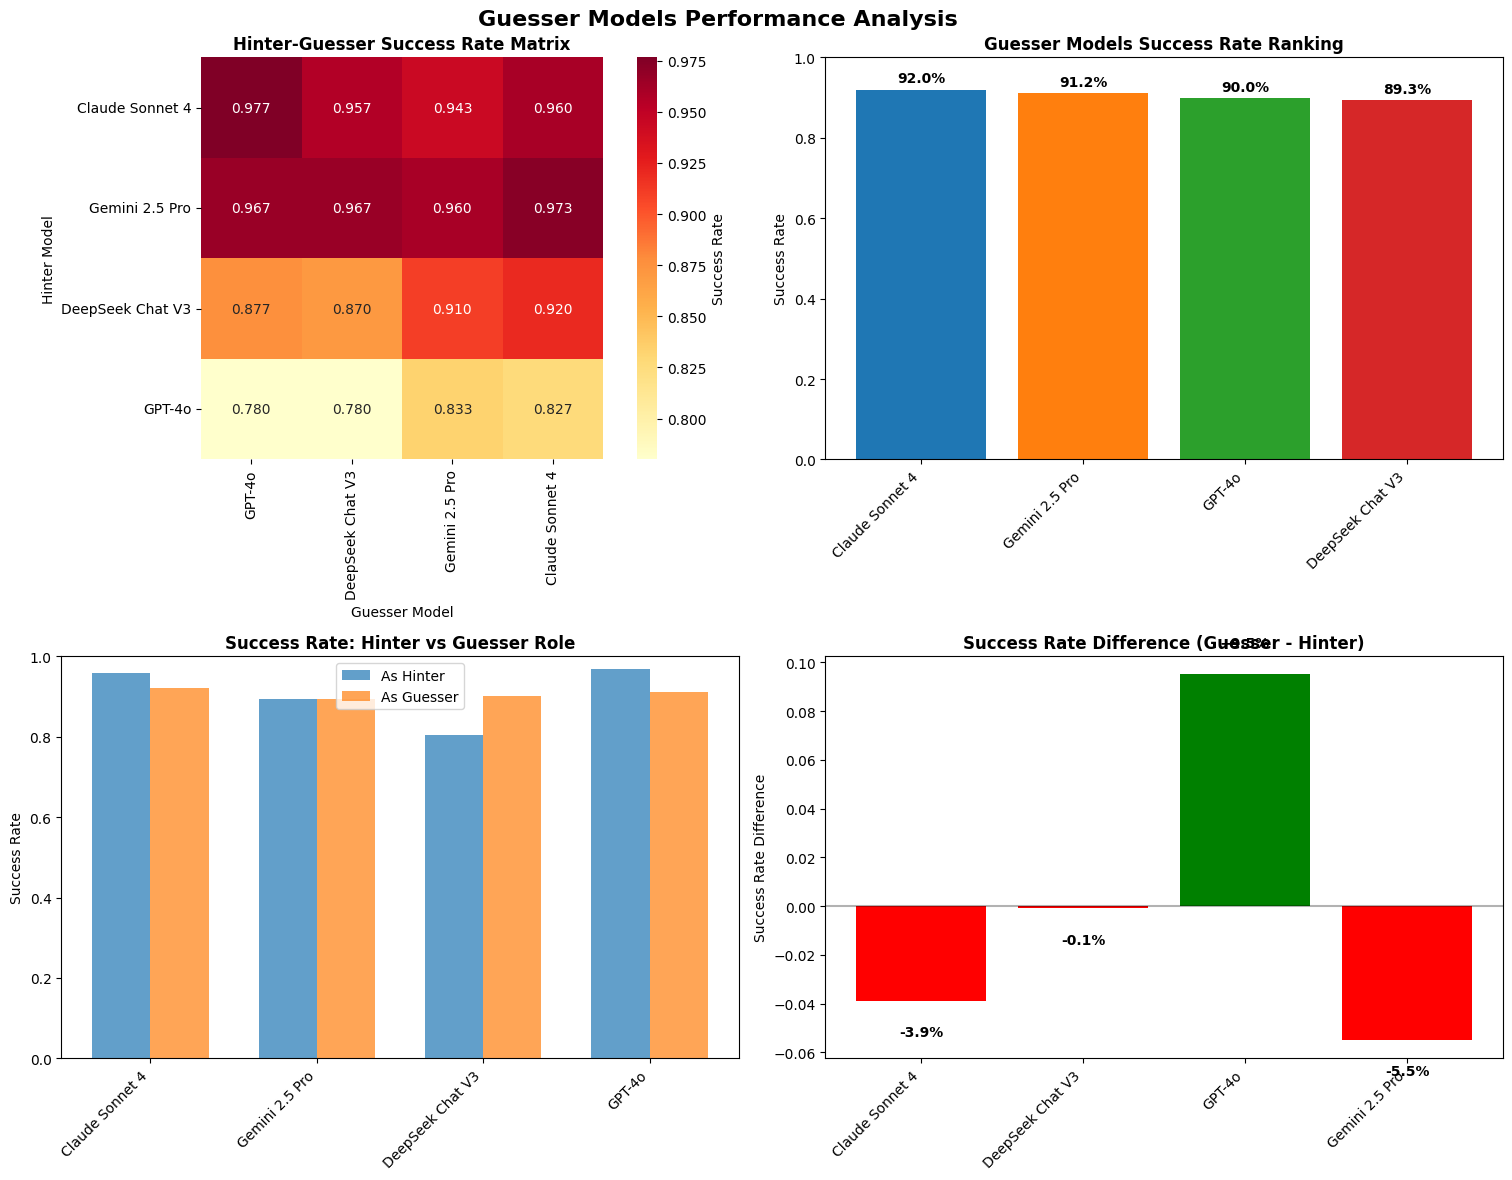


🔍 关键发现:
  • 最佳Guesser: Claude Sonnet 4 (92.0%)
  • 最差Guesser: DeepSeek Chat V3 (89.3%)
  • Guesser性能差距: 2.7%

🎭 角色适应性分析:
  • Claude Sonnet 4: 更适合Hinter (Hinter: 95.9%, Guesser: 92.0%, 差异: -3.9%)
  • Gemini 2.5 Pro: 更适合Hinter (Hinter: 96.7%, Guesser: 91.2%, 差异: -5.5%)
  • DeepSeek Chat V3: 平衡型 (Hinter: 89.4%, Guesser: 89.3%, 差异: -0.1%)
  • GPT-4o: 更适合Guesser (Hinter: 80.5%, Guesser: 90.0%, 差异: +9.5%)

🎯 最佳Hinter-Guesser组合:
Top 5 最佳组合:
  1. Claude Sonnet 4 (Hinter) + GPT-4o (Guesser): 97.7%
  2. Gemini 2.5 Pro (Hinter) + Claude Sonnet 4 (Guesser): 97.3%
  3. Gemini 2.5 Pro (Hinter) + GPT-4o (Guesser): 96.7%
  4. Gemini 2.5 Pro (Hinter) + DeepSeek Chat V3 (Guesser): 96.7%
  5. Claude Sonnet 4 (Hinter) + Claude Sonnet 4 (Guesser): 96.0%
Bottom 5 最差组合:
  1. DeepSeek Chat V3 (Hinter) + DeepSeek Chat V3 (Guesser): 87.0%
  2. GPT-4o (Hinter) + Gemini 2.5 Pro (Guesser): 83.3%
  3. GPT-4o (Hinter) + Claude Sonnet 4 (Guesser): 82.7%
  4. GPT-4o (Hinter) + GPT-4o (Guesser): 78.0%
  5. GPT-4o (Hin

In [3]:
# 重新加载数据用于Guesser维度分析
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')

# 尝试导入可选库
try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False

# 设置颜色
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# 加载数据
print("加载实验数据...")
with open('data/dataset.json', 'r', encoding='utf-8') as f:
    dataset = json.load(f)
dataset_df = pd.DataFrame(dataset)

results_df = pd.read_csv('results/taboo_experiment_20250712_004918/complete_experiment_results.csv')

# 清理模型名称
model_name_mapping = {
    'anthropic/claude-sonnet-4': 'Claude Sonnet 4',
    'openai/gpt-4o': 'GPT-4o',
    'google/gemini-2.5-pro': 'Gemini 2.5 Pro',
    'deepseek/deepseek-chat-v3-0324': 'DeepSeek Chat V3'
}

results_df['hinter_model_clean'] = results_df['hinter_model'].map(model_name_mapping)
results_df['guesser_model_clean'] = results_df['guesser_model'].map(model_name_mapping)

# 合并数据
dataset_info = dataset_df[['target', 'part_of_speech']].copy()
dataset_info = dataset_info.rename(columns={'target': 'target_word'})
merged_df = results_df.merge(dataset_info, on='target_word', how='left')

print(f"✅ 数据加载完成！总共 {len(merged_df)} 条记录")

# Guesser 维度性能分析
print("\n🎯 Guesser 模型性能分析")
print("="*60)

# 1. 创建 4x4 成功率表格 (Hinter x Guesser)
print("\n📊 4x4 成功率表格 (Hinter vs Guesser)")
print("行：Hinter模型 ↓ | 列：Guesser模型 →")

# 计算每个 hinter-guesser 组合的成功率
hinter_guesser_success = merged_df.groupby(['hinter_model_clean', 'guesser_model_clean'])['success'].mean().unstack()

# 设置相反的轴顺序以便更好地观察矩阵对称性
hinter_order = ['Claude Sonnet 4', 'Gemini 2.5 Pro', 'DeepSeek Chat V3', 'GPT-4o']
guesser_order = ['GPT-4o', 'DeepSeek Chat V3', 'Gemini 2.5 Pro', 'Claude Sonnet 4']  # 相反顺序

# 重新排序行和列
hinter_guesser_table = hinter_guesser_success.reindex(hinter_order, columns=guesser_order)

print("\n成功率矩阵:")
print(hinter_guesser_table.round(3))

print(f"\n📋 表格说明:")
print(f"• 行（纵轴）：Hinter模型（给提示的模型）")  
print(f"• 列（横轴）：Guesser模型（猜词的模型）")
print(f"• 数值：该Hinter-Guesser组合的成功率")
print(f"• 轴顺序相反设计便于观察不同组合的对比效果")

# 2. Guesser 模型整体表现
print(f"\n🎯 Guesser 模型整体表现:")
guesser_overall = merged_df.groupby('guesser_model_clean').agg({
    'success': ['count', 'mean'],
    'turns_used': lambda x: x[merged_df.loc[x.index, 'success']].mean(),
    'has_taboo_violation': 'mean'
}).round(3)

guesser_overall.columns = ['总游戏数', '成功率', '平均轮数', '违规率']
guesser_overall = guesser_overall.reindex(hinter_order)

print(guesser_overall)

# 3. 与 Hinter 表现对比
print(f"\n🔄 Hinter vs Guesser 表现对比:")
hinter_overall = merged_df.groupby('hinter_model_clean').agg({
    'success': 'mean',
    'turns_used': lambda x: x[merged_df.loc[x.index, 'success']].mean(),
}).round(3)

comparison_table = pd.DataFrame({
    'Hinter成功率': hinter_overall['success'],
    'Guesser成功率': guesser_overall['成功率'],
    'Hinter平均轮数': hinter_overall['turns_used'],
    'Guesser平均轮数': guesser_overall['平均轮数']
})

comparison_table['成功率差异'] = comparison_table['Guesser成功率'] - comparison_table['Hinter成功率']
comparison_table['轮数差异'] = comparison_table['Guesser平均轮数'] - comparison_table['Hinter平均轮数']

print(comparison_table.round(3))

# 4. 可视化分析
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Guesser Models Performance Analysis', fontsize=16, fontweight='bold')

# 1. 成功率热力图
import numpy as np
if HAS_SEABORN:
    sns.heatmap(hinter_guesser_table, annot=True, cmap='YlOrRd', ax=ax1, 
                cbar_kws={'label': 'Success Rate'}, fmt='.3f', square=True)
else:
    # Matplotlib fallback
    im = ax1.imshow(hinter_guesser_table.values, cmap='YlOrRd', aspect='auto')
    ax1.set_xticks(range(len(hinter_guesser_table.columns)))
    ax1.set_yticks(range(len(hinter_guesser_table.index)))
    ax1.set_xticklabels(hinter_guesser_table.columns, rotation=45, ha='right')
    ax1.set_yticklabels(hinter_guesser_table.index)
    
    # Add text annotations
    for i in range(len(hinter_guesser_table.index)):
        for j in range(len(hinter_guesser_table.columns)):
            if not pd.isna(hinter_guesser_table.iloc[i, j]):
                ax1.text(j, i, f'{hinter_guesser_table.iloc[i, j]:.3f}', 
                        ha='center', va='center', color='white' if hinter_guesser_table.iloc[i, j] < 0.5 else 'black')
    
    plt.colorbar(im, ax=ax1, label='Success Rate')

ax1.set_title('Hinter-Guesser Success Rate Matrix', fontweight='bold')
ax1.set_xlabel('Guesser Model')
ax1.set_ylabel('Hinter Model')

# 2. Guesser 成功率排名
guesser_success_sorted = guesser_overall['成功率'].sort_values(ascending=False)
bars2 = ax2.bar(range(len(guesser_success_sorted)), guesser_success_sorted.values, 
                color=colors[:len(guesser_success_sorted)])
ax2.set_title('Guesser Models Success Rate Ranking', fontweight='bold')
ax2.set_ylabel('Success Rate')
ax2.set_xticks(range(len(guesser_success_sorted)))
ax2.set_xticklabels(guesser_success_sorted.index, rotation=45, ha='right')
ax2.set_ylim(0, 1)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

# 3. Hinter vs Guesser 成功率对比
x_pos = np.arange(len(hinter_order))
width = 0.35

bars3a = ax3.bar(x_pos - width/2, comparison_table['Hinter成功率'], width, 
                 label='As Hinter', color=colors[0], alpha=0.7)
bars3b = ax3.bar(x_pos + width/2, comparison_table['Guesser成功率'], width,
                 label='As Guesser', color=colors[1], alpha=0.7)

ax3.set_title('Success Rate: Hinter vs Guesser Role', fontweight='bold')
ax3.set_ylabel('Success Rate')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(hinter_order, rotation=45, ha='right')
ax3.legend()
ax3.set_ylim(0, 1)

# 4. 角色差异分析
ax4.bar(range(len(comparison_table)), comparison_table['成功率差异'], 
        color=['green' if x > 0 else 'red' for x in comparison_table['成功率差异']])
ax4.set_title('Success Rate Difference (Guesser - Hinter)', fontweight='bold')
ax4.set_ylabel('Success Rate Difference')
ax4.set_xticks(range(len(comparison_table)))
ax4.set_xticklabels(comparison_table.index, rotation=45, ha='right')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)

for i, diff in enumerate(comparison_table['成功率差异']):
    ax4.text(i, diff + (0.01 if diff > 0 else -0.01), f'{diff:+.1%}', 
             ha='center', va='bottom' if diff > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. 关键发现总结
print(f"\n🔍 关键发现:")

# 找出最佳和最差的 guesser
best_guesser = guesser_overall['成功率'].idxmax()
worst_guesser = guesser_overall['成功率'].idxmin()
best_rate = guesser_overall.loc[best_guesser, '成功率']
worst_rate = guesser_overall.loc[worst_guesser, '成功率']

print(f"  • 最佳Guesser: {best_guesser} ({best_rate:.1%})")
print(f"  • 最差Guesser: {worst_guesser} ({worst_rate:.1%})")
print(f"  • Guesser性能差距: {best_rate - worst_rate:.1%}")

# 分析角色适应性
print(f"\n🎭 角色适应性分析:")
for model in hinter_order:
    hinter_rate = comparison_table.loc[model, 'Hinter成功率']
    guesser_rate = comparison_table.loc[model, 'Guesser成功率']
    diff = comparison_table.loc[model, '成功率差异']
    
    if abs(diff) < 0.02:
        role_pref = "平衡型"
    elif diff > 0:
        role_pref = "更适合Guesser"
    else:
        role_pref = "更适合Hinter"
    
    print(f"  • {model}: {role_pref} (Hinter: {hinter_rate:.1%}, Guesser: {guesser_rate:.1%}, 差异: {diff:+.1%})")

# 最佳组合分析
print(f"\n🎯 最佳Hinter-Guesser组合:")
best_combinations = []
for hinter in hinter_order:
    for guesser in guesser_order:
        if not pd.isna(hinter_guesser_table.loc[hinter, guesser]):
            best_combinations.append((hinter, guesser, hinter_guesser_table.loc[hinter, guesser]))

best_combinations.sort(key=lambda x: x[2], reverse=True)

print("Top 5 最佳组合:")
for i, (hinter, guesser, rate) in enumerate(best_combinations[:5], 1):
    print(f"  {i}. {hinter} (Hinter) + {guesser} (Guesser): {rate:.1%}")

print("Bottom 5 最差组合:")
for i, (hinter, guesser, rate) in enumerate(best_combinations[-5:], 1):
    print(f"  {i}. {hinter} (Hinter) + {guesser} (Guesser): {rate:.1%}")

print(f"\n✅ Guesser 维度分析完成！")


🔍 开始BERT语义相似度分析...
✅ 使用MPS加速
✅ BERT模型已加载到 mps
✅ 数据加载完成: 4800 条记录
📊 提取猜测数据...
处理进度: 0/4800
处理进度: 100/4800
处理进度: 200/4800
处理进度: 300/4800
处理进度: 400/4800
处理进度: 500/4800
处理进度: 600/4800
处理进度: 700/4800
处理进度: 800/4800
处理进度: 900/4800
处理进度: 1000/4800
处理进度: 1100/4800
处理进度: 1200/4800
处理进度: 1300/4800
处理进度: 1400/4800
处理进度: 1500/4800
处理进度: 1600/4800
处理进度: 1700/4800
处理进度: 1800/4800
处理进度: 1900/4800
处理进度: 2000/4800
处理进度: 2100/4800
处理进度: 2200/4800
处理进度: 2300/4800
处理进度: 2400/4800
处理进度: 2500/4800
处理进度: 2600/4800
处理进度: 2700/4800
处理进度: 2800/4800
处理进度: 2900/4800
处理进度: 3000/4800
处理进度: 3100/4800
处理进度: 3200/4800
处理进度: 3300/4800
处理进度: 3400/4800
处理进度: 3500/4800
处理进度: 3600/4800
处理进度: 3700/4800
处理进度: 3800/4800
处理进度: 3900/4800
处理进度: 4000/4800
处理进度: 4100/4800
处理进度: 4200/4800
处理进度: 4300/4800
处理进度: 4400/4800
处理进度: 4500/4800
处理进度: 4600/4800
处理进度: 4700/4800
✅ 相似度分析完成: 8243 条记录

🔍 多模型多轮次相似度趋势分析

各模型对各轮平均相似度:
                                               mean     std  count
model_pair                      turn_number      

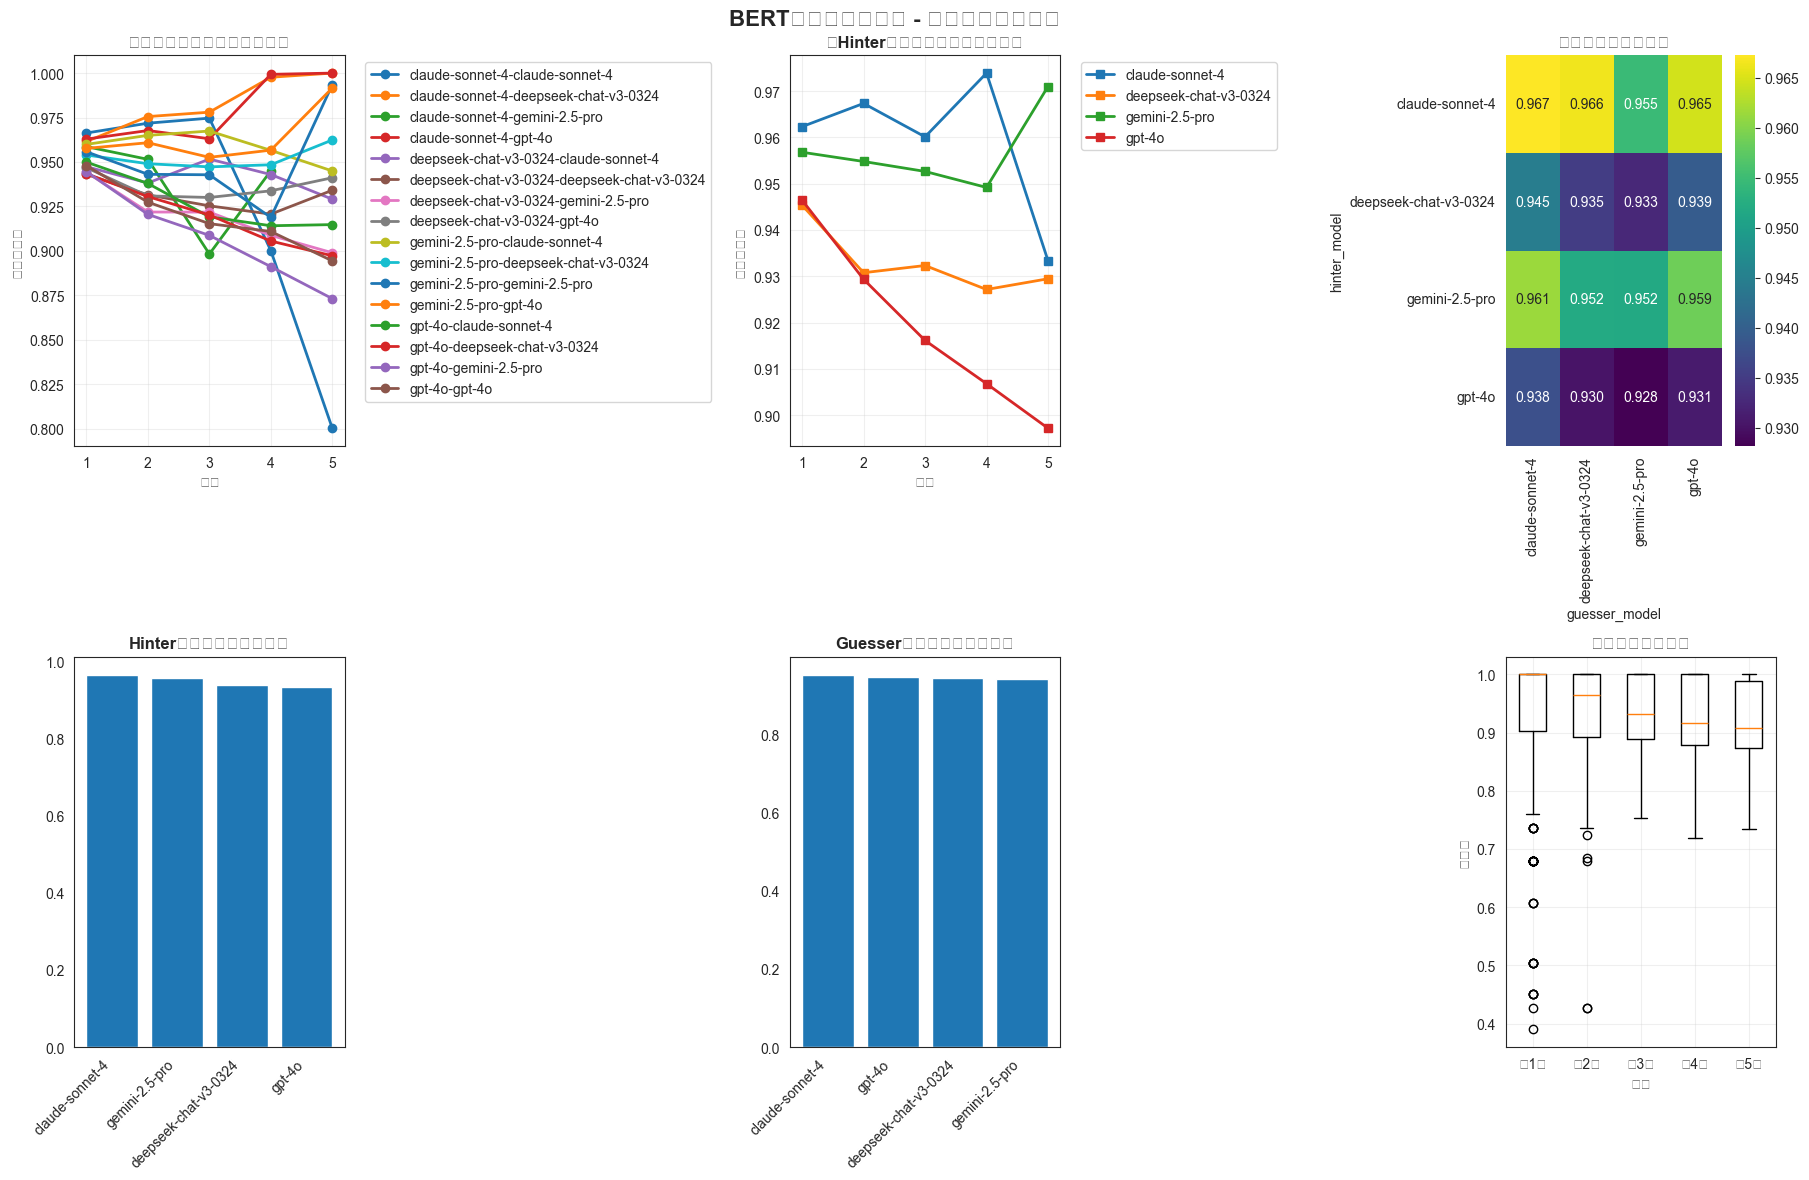


          BERT语义相似度分析报告 - 多模型多轮次版本

📊 基础统计:
  • 总猜测数: 8,243
  • 平均相似度: 0.9454

🤖 模型对分析:
  • gpt-4o-gpt-4o: 相似度 0.9311, 成功率 0.5793 (618 次)
  • gpt-4o-gemini-2.5-pro: 相似度 0.9282, 成功率 0.6992 (532 次)
  • gpt-4o-deepseek-chat-v3-0324: 相似度 0.9302, 成功率 0.6006 (626 次)
  • gpt-4o-claude-sonnet-4: 相似度 0.9378, 成功率 0.6627 (590 次)
  • gemini-2.5-pro-gpt-4o: 相似度 0.9586, 成功率 0.9513 (472 次)
  • gemini-2.5-pro-gemini-2.5-pro: 相似度 0.9518, 成功率 0.9571 (420 次)
  • gemini-2.5-pro-deepseek-chat-v3-0324: 相似度 0.9520, 成功率 0.9417 (515 次)
  • gemini-2.5-pro-claude-sonnet-4: 相似度 0.9614, 成功率 0.9607 (458 次)
  • deepseek-chat-v3-0324-gpt-4o: 相似度 0.9394, 成功率 0.7732 (604 次)
  • deepseek-chat-v3-0324-gemini-2.5-pro: 相似度 0.9326, 成功率 0.8346 (538 次)
  • deepseek-chat-v3-0324-deepseek-chat-v3-0324: 相似度 0.9352, 成功率 0.7642 (632 次)
  • deepseek-chat-v3-0324-claude-sonnet-4: 相似度 0.9447, 成功率 0.8626 (575 次)
  • claude-sonnet-4-gpt-4o: 相似度 0.9646, 成功率 0.9931 (435 次)
  • claude-sonnet-4-gemini-2.5-pro: 相似度 0.9547, 成功率 0.9669 (393 

In [3]:
# BERT语义相似度分析 - 多模型多轮次版本
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import json
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class BERTSimilarityAnalyzer:
    """BERT语义相似度分析器"""
    
    def __init__(self, model_name='bert-base-chinese'):
        """初始化BERT模型"""
        # 将原来的这行：

        # 替换为：
        if torch.backends.mps.is_available():
            self.device = torch.device('mps')
            print("✅ 使用MPS加速")
        elif torch.cuda.is_available():
            self.device = torch.device('cuda')
            print("✅ 使用CUDA加速")
        else:
            self.device = torch.device('cpu')
            print("⚠️ 使用CPU，建议使用GPU加速")
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()
        print(f"✅ BERT模型已加载到 {self.device}")
    
    def get_embedding(self, text, max_length=10):
        """获取文本的BERT嵌入向量"""
        try:
            inputs = self.tokenizer(
                text, 
                return_tensors='pt', 
                truncation=True, 
                max_length=max_length,
                padding=True
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = self.model(**inputs)
                embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            
            return embedding
        except Exception as e:
            print(f"获取嵌入向量失败: {text}, 错误: {e}")
            return np.zeros((1, 768))
    
    def calculate_similarity(self, text1, text2):
        """计算两个文本的余弦相似度"""
        emb1 = self.get_embedding(text1)
        emb2 = self.get_embedding(text2)
        similarity = cosine_similarity(emb1, emb2)[0][0]
        return similarity
    
    def analyze_game_similarities(self, game_data):
        """分析单场游戏的相似度变化"""
        target_word = game_data['target_word']
        all_guesses = game_data['all_guesses']
        
        similarities = []
        for i, guess in enumerate(all_guesses):
            similarity = self.calculate_similarity(guess, target_word)
            similarities.append({
                'turn_number': i + 1,
                'guess': guess,
                'target': target_word,
                'similarity': similarity
            })
        
        return similarities

def load_experiment_data():
    """加载实验数据"""
    try:
        with open('data/dataset.json', 'r', encoding='utf-8') as f:
            dataset = json.load(f)
        
        results_df = pd.read_csv('results/taboo_experiment_20250712_004918/complete_experiment_results.csv')
        
        dataset_df = pd.DataFrame(dataset)
        dataset_info = dataset_df[['target', 'part_of_speech']].copy()
        dataset_info = dataset_info.rename(columns={'target': 'target_word'})
        
        merged_df = results_df.merge(dataset_info, on='target_word', how='left')
        
        print(f"✅ 数据加载完成: {len(merged_df)} 条记录")
        return merged_df
    except Exception as e:
        print(f"❌ 数据加载失败: {e}")
        return None

import re

def extract_guesses_from_all_guesses(all_guesses_str):
    """从all_guesses字段提取每轮猜测词"""
    if pd.isna(all_guesses_str):
        return []
    items = all_guesses_str.split('|')
    guesses = []
    for item in items:
        match = re.search(r'\[GUESS\]\s*(.+)', item)
        if match:
            guess = match.group(1).strip()
            if guess and guess not in ['INVALID_FORMAT', 'FORMAT_ERROR']:
                guesses.append(guess)
    return guesses

def run_bert_similarity_analysis():
    """运行BERT相似度分析（支持多模型多轮次分析）"""
    print("🔍 开始BERT语义相似度分析...")
    
    analyzer = BERTSimilarityAnalyzer()
    merged_df = load_experiment_data()
    if merged_df is None:
        return None
    
    print("📊 提取猜测数据...")
    game_analyses = []
    
    for idx, row in merged_df.iterrows():
        if idx % 100 == 0:
            print(f"处理进度: {idx}/{len(merged_df)}")
        
        guesses = extract_guesses_from_all_guesses(row['all_guesses'])
        
        if guesses:
            similarities = analyzer.analyze_game_similarities({
                'target_word': row['target_word'],
                'all_guesses': guesses
            })
            for sim in similarities:
                # 修正字段名：使用实际的CSV字段名
                hinter_model = row.get('hinter_model', 'Unknown')
                guesser_model = row.get('guesser_model', 'Unknown')
                
                # 清理模型名称（去掉openai/前缀等）
                if isinstance(hinter_model, str) and '/' in hinter_model:
                    hinter_model = hinter_model.split('/')[-1]
                if isinstance(guesser_model, str) and '/' in guesser_model:
                    guesser_model = guesser_model.split('/')[-1]
                
                sim.update({
                    'game_id': row.get('game_id', f'game_{idx}'),
                    'hinter_model': hinter_model,
                    'guesser_model': guesser_model,
                    'model_pair': f"{hinter_model}-{guesser_model}",
                    'success': row.get('success', False),
                    'turns_used': row.get('turns_used', 0),
                    'part_of_speech': row.get('part_of_speech', 'unknown'),
                    'category': row.get('category', 'unknown')
                })
            game_analyses.extend(similarities)
    
    if game_analyses:
        similarity_df = pd.DataFrame(game_analyses)
        print(f"✅ 相似度分析完成: {len(similarity_df)} 条记录")
        return similarity_df
    else:
        print("❌ 没有找到有效的猜测数据")
        return None

def analyze_multi_model_similarity_trends(similarity_df):
    """分析多模型多轮次相似度趋势"""
    if similarity_df is None or len(similarity_df) == 0:
        print("❌ 没有数据可供分析")
        return None
    
    print("\n🔍 多模型多轮次相似度趋势分析")
    
    # 按模型对和轮数分析
    model_turn_similarity = similarity_df.groupby(['model_pair', 'turn_number'])['similarity'].agg(['mean', 'std', 'count']).round(4)
    print("\n各模型对各轮平均相似度:")
    print(model_turn_similarity)
    
    # 按Hinter模型和轮数分析
    hinter_turn_similarity = similarity_df.groupby(['hinter_model', 'turn_number'])['similarity'].agg(['mean', 'std', 'count']).round(4)
    print("\n各Hinter模型各轮平均相似度:")
    print(hinter_turn_similarity)
    
    # 按Guesser模型和轮数分析
    guesser_turn_similarity = similarity_df.groupby(['guesser_model', 'turn_number'])['similarity'].agg(['mean', 'std', 'count']).round(4)
    print("\n各Guesser模型各轮平均相似度:")
    print(guesser_turn_similarity)
    
    return {
        'model_turn': model_turn_similarity,
        'hinter_turn': hinter_turn_similarity,
        'guesser_turn': guesser_turn_similarity
    }

def visualize_multi_model_similarity_analysis(similarity_df):
    """可视化多模型多轮次相似度分析"""
    if similarity_df is None or len(similarity_df) == 0:
        print("❌ 没有数据可供可视化")
        return
    
    sns.set_style("white")
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('BERT语义相似度分析 - 多模型多轮次对比', fontsize=16, fontweight='bold')
    
    # 1. 各模型对按轮数的相似度变化
    model_turn_data = similarity_df.groupby(['model_pair', 'turn_number'])['similarity'].mean().unstack(level=0)
    model_turn_data.plot(kind='line', ax=axes[0, 0], marker='o', linewidth=2)
    axes[0, 0].set_title('各模型对按轮数的相似度变化', fontweight='bold')
    axes[0, 0].set_xlabel('轮数')
    axes[0, 0].set_ylabel('平均相似度')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Hinter模型按轮数的相似度变化
    hinter_turn_data = similarity_df.groupby(['hinter_model', 'turn_number'])['similarity'].mean().unstack(level=0)
    hinter_turn_data.plot(kind='line', ax=axes[0, 1], marker='s', linewidth=2)
    axes[0, 1].set_title('各Hinter模型按轮数的相似度变化', fontweight='bold')
    axes[0, 1].set_xlabel('轮数')
    axes[0, 1].set_ylabel('平均相似度')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. 模型对相似度热力图
    heatmap_data = similarity_df.groupby(['hinter_model', 'guesser_model'])['similarity'].mean().unstack()
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='viridis', ax=axes[0, 2])
    axes[0, 2].set_title('模型对相似度热力图', fontweight='bold')
    
    # 4. Hinter模型整体表现对比
    hinter_means = similarity_df.groupby('hinter_model')['similarity'].mean().sort_values(ascending=False)
    bars = axes[1, 0].bar(range(len(hinter_means)), hinter_means.values)
    axes[1, 0].set_title('Hinter模型平均相似度对比', fontweight='bold')
    axes[1, 0].set_xticks(range(len(hinter_means)))
    axes[1, 0].set_xticklabels(hinter_means.index, rotation=45, ha='right')
    
    # 5. Guesser模型整体表现对比
    guesser_means = similarity_df.groupby('guesser_model')['similarity'].mean().sort_values(ascending=False)
    bars = axes[1, 1].bar(range(len(guesser_means)), guesser_means.values)
    axes[1, 1].set_title('Guesser模型平均相似度对比', fontweight='bold')
    axes[1, 1].set_xticks(range(len(guesser_means)))
    axes[1, 1].set_xticklabels(guesser_means.index, rotation=45, ha='right')
    
    # 6. 各轮次整体相似度分布
    turn_data = [similarity_df[similarity_df['turn_number'] == turn]['similarity'].values 
                 for turn in sorted(similarity_df['turn_number'].unique())]
    turn_labels = [f'第{turn}轮' for turn in sorted(similarity_df['turn_number'].unique())]
    
    axes[1, 2].boxplot(turn_data, labels=turn_labels)
    axes[1, 2].set_title('各轮次相似度分布', fontweight='bold')
    axes[1, 2].set_xlabel('轮次')
    axes[1, 2].set_ylabel('相似度')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def generate_multi_model_similarity_report(similarity_df):
    """生成多模型多轮次相似度分析报告"""
    if similarity_df is None or len(similarity_df) == 0:
        print("❌ 没有数据可供分析")
        return
    
    print("\n" + "="*80)
    print("          BERT语义相似度分析报告 - 多模型多轮次版本")
    print("="*80)
    
    # 基础统计
    total_guesses = len(similarity_df)
    avg_similarity = similarity_df['similarity'].mean()
    
    print(f"\n📊 基础统计:")
    print(f"  • 总猜测数: {total_guesses:,}")
    print(f"  • 平均相似度: {avg_similarity:.4f}")
    
    # 模型对分析
    print(f"\n🤖 模型对分析:")
    for model_pair in similarity_df['model_pair'].unique():
        data = similarity_df[similarity_df['model_pair'] == model_pair]
        avg_sim = data['similarity'].mean()
        count = len(data)
        success_rate = data['success'].mean()
        print(f"  • {model_pair}: 相似度 {avg_sim:.4f}, 成功率 {success_rate:.4f} ({count} 次)")
    
    # 轮数分析
    print(f"\n📈 轮数分析:")
    for turn in sorted(similarity_df['turn_number'].unique()):
        turn_data = similarity_df[similarity_df['turn_number'] == turn]
        avg_sim = turn_data['similarity'].mean()
        count = len(turn_data)
        print(f"  • 第{turn}轮: 平均相似度 {avg_sim:.4f} ({count} 次猜测)")
    
    print("\n" + "="*80)

def save_multi_model_similarity_results(similarity_df, analysis_results):
    """保存多模型相似度分析结果"""
    if similarity_df is not None:
        similarity_df.to_csv('bert_multi_model_similarity_analysis.csv', index=False, encoding='utf-8')
        print(f"✅ 相似度分析结果已保存")
        
        if analysis_results:
            with pd.ExcelWriter('bert_multi_model_stats.xlsx') as writer:
                analysis_results['model_turn'].to_excel(writer, sheet_name='模型对轮数统计')
                analysis_results['hinter_turn'].to_excel(writer, sheet_name='Hinter轮数统计')
                analysis_results['guesser_turn'].to_excel(writer, sheet_name='Guesser轮数统计')
            print(f"✅ 统计结果已保存到Excel文件")

# 主函数
if __name__ == "__main__":
    # 运行BERT相似度分析
    similarity_df = run_bert_similarity_analysis()
    
    if similarity_df is not None:
        # 分析趋势
        analysis_results = analyze_multi_model_similarity_trends(similarity_df)
        
        # 可视化分析
        visualize_multi_model_similarity_analysis(similarity_df)
        
        # 生成报告
        generate_multi_model_similarity_report(similarity_df)
        
        # 保存结果
        save_multi_model_similarity_results(similarity_df, analysis_results)
        
        print("🎉 BERT多模型多轮次语义相似度分析完成！")
    else:
        print("❌ 分析失败，请检查数据文件")


🔍 Starting BERT similarity result analysis...
✅ Successfully loaded BERT similarity results: 8243 records
Data columns: ['turn_number', 'guess', 'target', 'similarity', 'game_id', 'hinter_model', 'guesser_model', 'model_pair', 'success', 'turns_used', 'part_of_speech', 'category']

📊 Basic Statistics:
  • Total guesses: 8,243
  • Average similarity: 0.9454
  • Similarity range: 0.3899 - 1.0000
  • Number of model pairs: 16
  • Model pairs: ['gpt-4o-gpt-4o', 'gpt-4o-gemini-2.5-pro', 'gpt-4o-deepseek-chat-v3-0324', 'gpt-4o-claude-sonnet-4', 'gemini-2.5-pro-gpt-4o', 'gemini-2.5-pro-gemini-2.5-pro', 'gemini-2.5-pro-deepseek-chat-v3-0324', 'gemini-2.5-pro-claude-sonnet-4', 'deepseek-chat-v3-0324-gpt-4o', 'deepseek-chat-v3-0324-gemini-2.5-pro', 'deepseek-chat-v3-0324-deepseek-chat-v3-0324', 'deepseek-chat-v3-0324-claude-sonnet-4', 'claude-sonnet-4-gpt-4o', 'claude-sonnet-4-gemini-2.5-pro', 'claude-sonnet-4-deepseek-chat-v3-0324', 'claude-sonnet-4-claude-sonnet-4']

🔍 Model Performance Analys

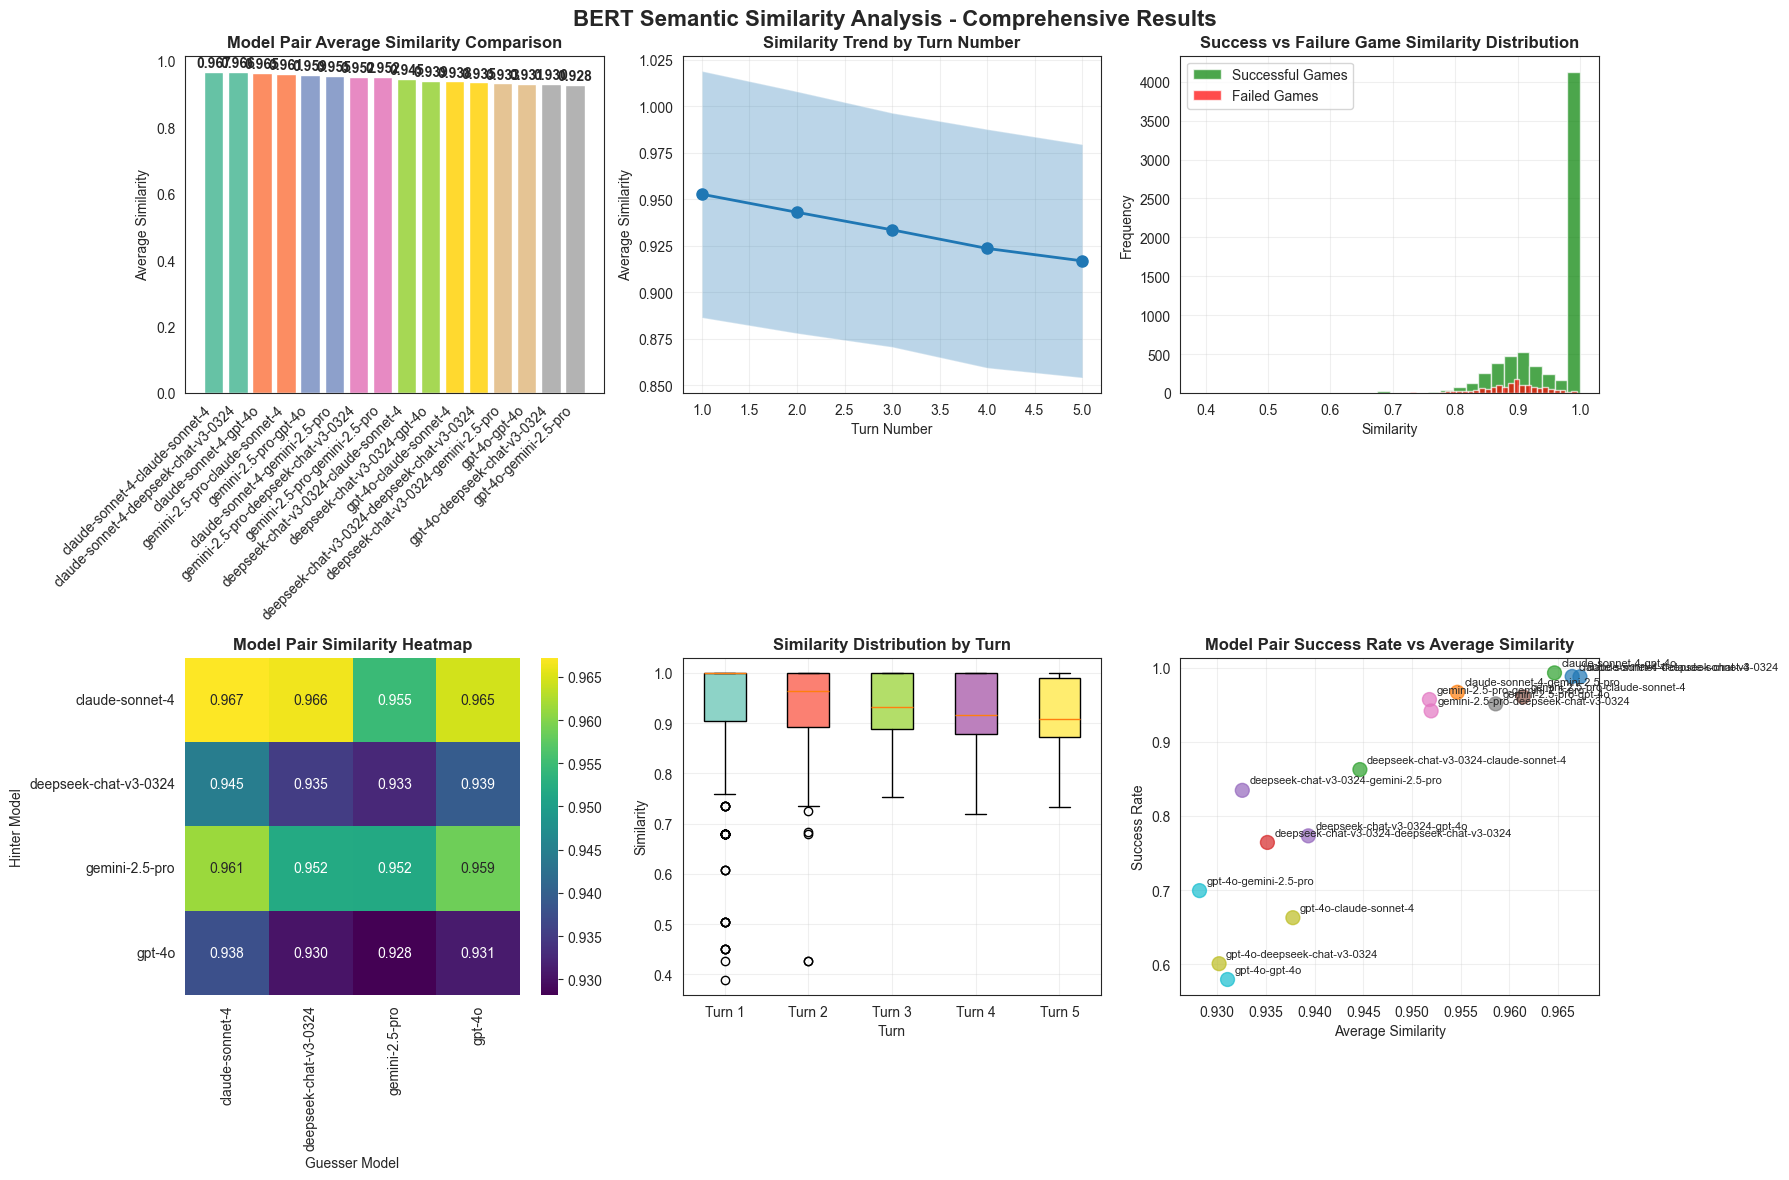


                    BERT Semantic Similarity Comprehensive Analysis Report

📊 Basic Statistics:
  • Total guesses: 8,243
  • Average similarity: 0.9454
  • Similarity standard deviation: 0.0662
  • Similarity range: 0.3899 - 1.0000

🏆 Model Pair Performance Ranking:
  1. claude-sonnet-4-claude-sonnet-4: Similarity 0.9673, Success rate: 0.9878
  2. claude-sonnet-4-deepseek-chat-v3-0324: Similarity 0.9665, Success rate: 0.9883
  3. claude-sonnet-4-gpt-4o: Similarity 0.9646, Success rate: 0.9931
  4. gemini-2.5-pro-claude-sonnet-4: Similarity 0.9614, Success rate: 0.9607
  5. gemini-2.5-pro-gpt-4o: Similarity 0.9586, Success rate: 0.9513
  6. claude-sonnet-4-gemini-2.5-pro: Similarity 0.9547, Success rate: 0.9669
  7. gemini-2.5-pro-deepseek-chat-v3-0324: Similarity 0.9520, Success rate: 0.9417
  8. gemini-2.5-pro-gemini-2.5-pro: Similarity 0.9518, Success rate: 0.9571
  9. deepseek-chat-v3-0324-claude-sonnet-4: Similarity 0.9447, Success rate: 0.8626
  10. deepseek-chat-v3-0324-gpt-4o: 

In [4]:
# BERT Semantic Similarity Result Analyzer - Direct analysis of saved result files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set font for better display
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def load_bert_similarity_results(filepath):
    """Load BERT similarity analysis results"""
    try:
        similarity_df = pd.read_csv(filepath, encoding='utf-8')
        print(f"✅ Successfully loaded BERT similarity results: {len(similarity_df)} records")
        print(f"Data columns: {list(similarity_df.columns)}")
        
        # Display basic statistics
        print(f"\n📊 Basic Statistics:")
        print(f"  • Total guesses: {len(similarity_df):,}")
        print(f"  • Average similarity: {similarity_df['similarity'].mean():.4f}")
        print(f"  • Similarity range: {similarity_df['similarity'].min():.4f} - {similarity_df['similarity'].max():.4f}")
        
        if 'model_pair' in similarity_df.columns:
            print(f"  • Number of model pairs: {similarity_df['model_pair'].nunique()}")
            print(f"  • Model pairs: {list(similarity_df['model_pair'].unique())}")
        
        return similarity_df
    except Exception as e:
        print(f"❌ Failed to load result file: {e}")
        return None

def analyze_model_performance(similarity_df):
    """Analyze model performance"""
    if similarity_df is None or len(similarity_df) == 0:
        return None
    
    print("\n🔍 Model Performance Analysis")
    
    # 1. Analysis by model pairs
    if 'model_pair' in similarity_df.columns:
        model_pair_stats = similarity_df.groupby('model_pair').agg({
            'similarity': ['mean', 'std', 'count'],
            'success': 'mean' if 'success' in similarity_df.columns else lambda x: None
        }).round(4)
        print("\nModel Pair Performance:")
        print(model_pair_stats)
    
    # 2. Analysis by Hinter model
    if 'hinter_model' in similarity_df.columns:
        hinter_stats = similarity_df.groupby('hinter_model').agg({
            'similarity': ['mean', 'std', 'count'],
            'success': 'mean' if 'success' in similarity_df.columns else lambda x: None
        }).round(4)
        print("\nHinter Model Performance:")
        print(hinter_stats)
    
    # 3. Analysis by Guesser model
    if 'guesser_model' in similarity_df.columns:
        guesser_stats = similarity_df.groupby('guesser_model').agg({
            'similarity': ['mean', 'std', 'count'],
            'success': 'mean' if 'success' in similarity_df.columns else lambda x: None
        }).round(4)
        print("\nGuesser Model Performance:")
        print(guesser_stats)
    
    return {
        'model_pair': model_pair_stats if 'model_pair' in similarity_df.columns else None,
        'hinter': hinter_stats if 'hinter_model' in similarity_df.columns else None,
        'guesser': guesser_stats if 'guesser_model' in similarity_df.columns else None
    }

def analyze_turn_patterns(similarity_df):
    """Analyze turn patterns"""
    if 'turn_number' not in similarity_df.columns:
        print("❌ Missing turn information")
        return None
    
    print("\n📈 Turn Pattern Analysis")
    
    # 1. Overall performance by turn
    turn_stats = similarity_df.groupby('turn_number')['similarity'].agg(['mean', 'std', 'count']).round(4)
    print("\nOverall Performance by Turn:")
    print(turn_stats)
    
    # 2. Model pair performance by turn
    if 'model_pair' in similarity_df.columns:
        model_turn_stats = similarity_df.groupby(['model_pair', 'turn_number'])['similarity'].mean().round(4)
        print("\nModel Pair Performance by Turn:")
        print(model_turn_stats.unstack(level=0))
    
    return {
        'turn_overall': turn_stats,
        'model_turn': model_turn_stats if 'model_pair' in similarity_df.columns else None
    }

def create_comprehensive_visualization(similarity_df):
    """Create comprehensive visualization"""
    if similarity_df is None or len(similarity_df) == 0:
        print("❌ No data available for visualization")
        return
    
    sns.set_style("white")
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('BERT Semantic Similarity Analysis - Comprehensive Results', fontsize=16, fontweight='bold')
    
    # 1. Model pair overall performance comparison
    if 'model_pair' in similarity_df.columns:
        model_means = similarity_df.groupby('model_pair')['similarity'].mean().sort_values(ascending=False)
        bars = axes[0, 0].bar(range(len(model_means)), model_means.values, 
                              color=plt.cm.Set2(np.linspace(0, 1, len(model_means))))
        axes[0, 0].set_title('Model Pair Average Similarity Comparison', fontweight='bold')
        axes[0, 0].set_ylabel('Average Similarity')
        axes[0, 0].set_xticks(range(len(model_means)))
        axes[0, 0].set_xticklabels(model_means.index, rotation=45, ha='right')
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Similarity trend by turn
    if 'turn_number' in similarity_df.columns:
        turn_means = similarity_df.groupby('turn_number')['similarity'].mean()
        turn_stds = similarity_df.groupby('turn_number')['similarity'].std()
        
        axes[0, 1].plot(turn_means.index, turn_means.values, 'o-', linewidth=2, markersize=8)
        axes[0, 1].fill_between(turn_means.index, 
                                turn_means.values - turn_stds.values,
                                turn_means.values + turn_stds.values, 
                                alpha=0.3)
        axes[0, 1].set_title('Similarity Trend by Turn Number', fontweight='bold')
        axes[0, 1].set_xlabel('Turn Number')
        axes[0, 1].set_ylabel('Average Similarity')
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Success vs failure game similarity distribution
    if 'success' in similarity_df.columns:
        success_data = similarity_df[similarity_df['success'] == True]['similarity']
        failure_data = similarity_df[similarity_df['success'] == False]['similarity']
        
        if len(success_data) > 0:
            axes[0, 2].hist(success_data, bins=30, alpha=0.7, label='Successful Games', color='green')
        if len(failure_data) > 0:
            axes[0, 2].hist(failure_data, bins=30, alpha=0.7, label='Failed Games', color='red')
        axes[0, 2].set_title('Success vs Failure Game Similarity Distribution', fontweight='bold')
        axes[0, 2].set_xlabel('Similarity')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Model pair similarity heatmap
    if 'hinter_model' in similarity_df.columns and 'guesser_model' in similarity_df.columns:
        heatmap_data = similarity_df.groupby(['hinter_model', 'guesser_model'])['similarity'].mean().unstack()
        sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='viridis', ax=axes[1, 0])
        axes[1, 0].set_title('Model Pair Similarity Heatmap', fontweight='bold')
        axes[1, 0].set_xlabel('Guesser Model')
        axes[1, 0].set_ylabel('Hinter Model')
    
    # 5. Similarity distribution by turn (boxplot)
    if 'turn_number' in similarity_df.columns:
        turn_data = [similarity_df[similarity_df['turn_number'] == turn]['similarity'].values 
                     for turn in sorted(similarity_df['turn_number'].unique())]
        turn_labels = [f'Turn {turn}' for turn in sorted(similarity_df['turn_number'].unique())]
        
        box_plot = axes[1, 1].boxplot(turn_data, labels=turn_labels, patch_artist=True)
        colors = plt.cm.Set3(np.linspace(0, 1, len(turn_data)))
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
        
        axes[1, 1].set_title('Similarity Distribution by Turn', fontweight='bold')
        axes[1, 1].set_xlabel('Turn')
        axes[1, 1].set_ylabel('Similarity')
        axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Model pair success rate vs average similarity scatter plot
    if 'model_pair' in similarity_df.columns and 'success' in similarity_df.columns:
        model_stats = similarity_df.groupby('model_pair').agg({
            'similarity': 'mean',
            'success': 'mean'
        }).reset_index()
        
        scatter = axes[1, 2].scatter(model_stats['similarity'], model_stats['success'], 
                                   s=100, alpha=0.7, c=range(len(model_stats)), cmap='tab10')
        
        for i, row in model_stats.iterrows():
            axes[1, 2].annotate(row['model_pair'], 
                              (row['similarity'], row['success']),
                              xytext=(5, 5), textcoords='offset points',
                              fontsize=8, ha='left')
        
        axes[1, 2].set_title('Model Pair Success Rate vs Average Similarity', fontweight='bold')
        axes[1, 2].set_xlabel('Average Similarity')
        axes[1, 2].set_ylabel('Success Rate')
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def generate_comprehensive_report(similarity_df):
    """Generate comprehensive analysis report"""
    if similarity_df is None or len(similarity_df) == 0:
        print("❌ No data available for analysis")
        return
    
    print("\n" + "="*80)
    print("                    BERT Semantic Similarity Comprehensive Analysis Report")
    print("="*80)
    
    # Basic statistics
    total_guesses = len(similarity_df)
    avg_similarity = similarity_df['similarity'].mean()
    std_similarity = similarity_df['similarity'].std()
    
    print(f"\n📊 Basic Statistics:")
    print(f"  • Total guesses: {total_guesses:,}")
    print(f"  • Average similarity: {avg_similarity:.4f}")
    print(f"  • Similarity standard deviation: {std_similarity:.4f}")
    print(f"  • Similarity range: {similarity_df['similarity'].min():.4f} - {similarity_df['similarity'].max():.4f}")
    
    # Model performance ranking
    if 'model_pair' in similarity_df.columns:
        print(f"\n🏆 Model Pair Performance Ranking:")
        model_ranking = similarity_df.groupby('model_pair').agg({
            'similarity': 'mean',
            'success': 'mean' if 'success' in similarity_df.columns else lambda x: None
        }).round(4).sort_values('similarity', ascending=False)
        
        for i, (model_pair, stats) in enumerate(model_ranking.iterrows(), 1):
            success_info = f", Success rate: {stats['success']:.4f}" if 'success' in stats and not pd.isna(stats['success']) else ""
            print(f"  {i}. {model_pair}: Similarity {stats['similarity']:.4f}{success_info}")
    
    # Turn analysis
    if 'turn_number' in similarity_df.columns:
        print(f"\n📈 Turn Performance Analysis:")
        turn_analysis = similarity_df.groupby('turn_number')['similarity'].agg(['mean', 'count']).round(4)
        for turn, stats in turn_analysis.iterrows():
            print(f"  • Turn {turn}: Average similarity {stats['mean']:.4f} ({int(stats['count'])} guesses)")
    
    print("\n" + "="*80)

def save_analysis_results(similarity_df, model_stats, turn_stats, output_prefix='bert_analysis'):
    """Save analysis results"""
    try:
        # Save summary statistics
        with pd.ExcelWriter(f'{output_prefix}_summary.xlsx') as writer:
            if model_stats and model_stats['model_pair'] is not None:
                model_stats['model_pair'].to_excel(writer, sheet_name='Model_Pair_Stats')
            if model_stats and model_stats['hinter'] is not None:
                model_stats['hinter'].to_excel(writer, sheet_name='Hinter_Stats')
            if model_stats and model_stats['guesser'] is not None:
                model_stats['guesser'].to_excel(writer, sheet_name='Guesser_Stats')
            if turn_stats and turn_stats['turn_overall'] is not None:
                turn_stats['turn_overall'].to_excel(writer, sheet_name='Turn_Stats')
        
        print(f"✅ Analysis results saved to: {output_prefix}_summary.xlsx")
        
    except Exception as e:
        print(f"❌ Failed to save results: {e}")

def main(result_filepath):
    """Main analysis function"""
    print("🔍 Starting BERT similarity result analysis...")
    
    # 1. Load result data
    similarity_df = load_bert_similarity_results(result_filepath)
    if similarity_df is None:
        return
    
    # 2. Model performance analysis
    model_stats = analyze_model_performance(similarity_df)
    
    # 3. Turn pattern analysis
    turn_stats = analyze_turn_patterns(similarity_df)
    
    # 4. Create visualization
    create_comprehensive_visualization(similarity_df)
    
    # 5. Generate comprehensive report
    generate_comprehensive_report(similarity_df)
    
    # 6. Save analysis results
    save_analysis_results(similarity_df, model_stats, turn_stats)
    
    print("🎉 BERT similarity result analysis completed!")

if __name__ == "__main__":
    # Usage example
    result_file = "bert_multi_model_similarity_analysis.csv"  # Replace with your result file path
    main(result_file)


Loaded 8243 BERT similarity records
Target words: 300
Hinter models: ['gpt-4o' 'gemini-2.5-pro' 'deepseek-chat-v3-0324' 'claude-sonnet-4']
Guesser models: ['gpt-4o' 'gemini-2.5-pro' 'deepseek-chat-v3-0324' 'claude-sonnet-4']

BERT Similarity by Hinter Model (Clue Quality):


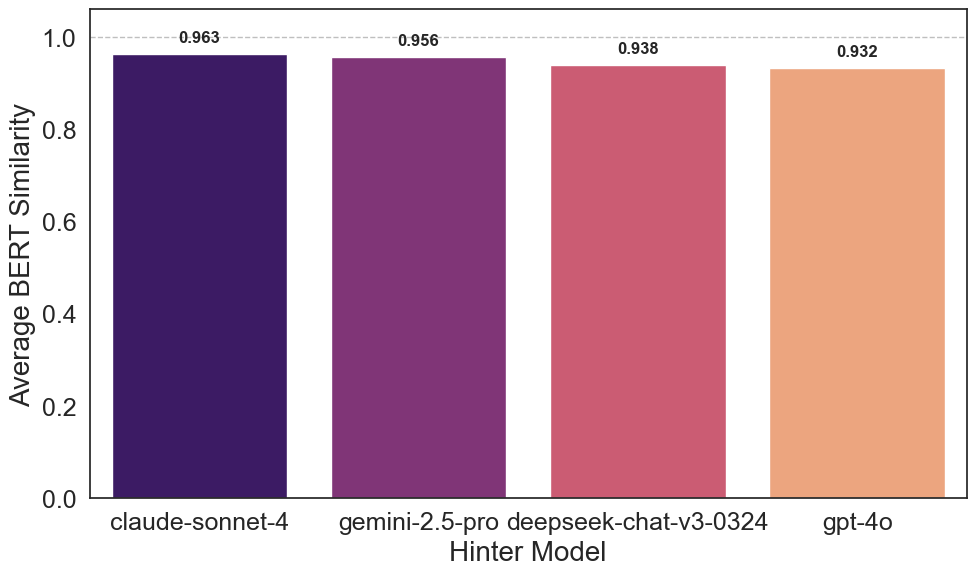

hinter_model
claude-sonnet-4          0.963389
gemini-2.5-pro           0.955930
deepseek-chat-v3-0324    0.937974
gpt-4o                   0.931863
Name: similarity, dtype: float64

BERT Similarity by Guesser Model (Guessing Accuracy):


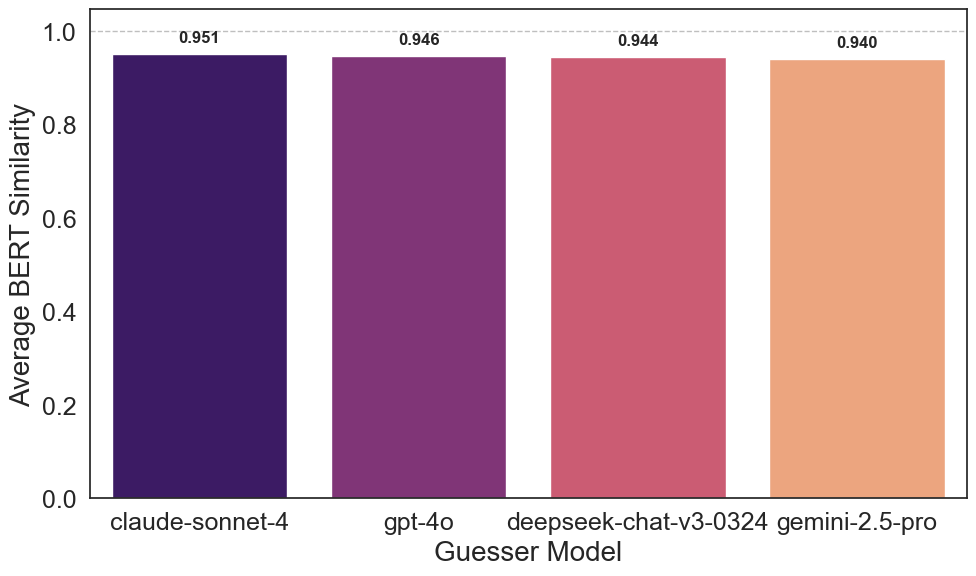

guesser_model
claude-sonnet-4          0.950986
gpt-4o                   0.946382
deepseek-chat-v3-0324    0.943748
gemini-2.5-pro           0.940235
Name: similarity, dtype: float64

Correlation Analysis: BERT Similarity vs Success Rate

Hinter Model - Similarity vs Success:
                       similarity  success
hinter_model                              
claude-sonnet-4            0.9634   0.9844
deepseek-chat-v3-0324      0.9380   0.8067
gemini-2.5-pro             0.9559   0.9523
gpt-4o                     0.9319   0.6327

Guesser Model - Similarity vs Success:
                       similarity  success
guesser_model                             
claude-sonnet-4            0.9510   0.8519
deepseek-chat-v3-0324      0.9437   0.8026
gemini-2.5-pro             0.9402   0.8513
gpt-4o                     0.9464   0.8013
→ BERT similarity bar charts saved to figures/ directory


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pathlib

# ---------- Load BERT Similarity Results ----------
def load_bert_results(filepath):
    """Load BERT similarity analysis results"""
    bert_results = pd.read_csv(filepath, encoding='utf-8')
    print(f"Loaded {len(bert_results)} BERT similarity records")
    print(f"Target words: {bert_results['target'].nunique()}")
    print(f"Hinter models: {bert_results['hinter_model'].unique()}")
    print(f"Guesser models: {bert_results['guesser_model'].unique()}")
    return bert_results

# ---------- Model Name Mapping ----------
# "Full name → Short name" mapping
label_map = {
    "openai/gpt-4o":                  "gpt-4o",
    "google/gemini-2.5-flash":        "gemini-2.5-flash", 
    "deepseek/deepseek-chat-v3-0324": "deepseek-v3",
    "moonshotai/kimi-k2":             "kimi-k2",
    "gpt-4o":                         "gpt-4o",
    "gemini-2.5-flash":               "gemini-2.5-flash",
    "deepseek-v3":                    "deepseek-v3",
    "kimi-k2":                        "kimi-k2"
}

# Set theme
sns.set_theme(style="white", font_scale=1.2)
out_dir = pathlib.Path("figures")
out_dir.mkdir(exist_ok=True)

def plot_bert_similarity_bar(df, group_key, fname, palette="magma"):
    """Plot BERT similarity by group_key and save (with short model names)"""
    similarity_mean = (
        df.groupby(group_key)["similarity"]
          .mean()
          .sort_values(ascending=False)
    )
    
    # Replace index with short names
    short_idx = similarity_mean.index.map(lambda x: label_map.get(x, x))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=short_idx, y=similarity_mean.values,
        palette=sns.color_palette(palette, n_colors=len(similarity_mean))
    )
    
    # Set y-axis limits with some headroom
    max_val = similarity_mean.max()
    plt.ylim(0, max_val * 1.1)
    plt.axhline(1, ls="--", c="gray", lw=1, alpha=0.5)
    
    plt.ylabel("Average BERT Similarity", fontsize=20)
    plt.xlabel(f"{group_key.split('_')[0].title()} Model", fontsize=20)
    
    # Tick settings: horizontal, font size 18
    plt.xticks(rotation=0, fontsize=18)
    plt.yticks(fontsize=18)
    
    # Add value labels on bars
    for idx, val in enumerate(similarity_mean.values):
        plt.text(idx, val + max_val * 0.02, f"{val:.3f}", ha="center", va="bottom",
                 fontsize=12, weight="bold")
    
    plt.tight_layout()
    plt.savefig(out_dir / f"{fname}.pdf", bbox_inches="tight")
    plt.savefig(out_dir / f"{fname}.png", dpi=300, bbox_inches="tight")
    plt.show()
    return similarity_mean

def analyze_bert_similarity_by_models(filepath):
    """Main analysis function for BERT similarity by models"""
    # Load data
    bert_results = load_bert_results(filepath)
    
    # 1) By Hinter Model (Clue Quality Perspective)
    print("\nBERT Similarity by Hinter Model (Clue Quality):")
    similarity_hinter = plot_bert_similarity_bar(
        bert_results,
        group_key="hinter_model", 
        fname="BERT_Similarity_by_Hinter"
    )
    print(similarity_hinter)
    
    # 2) By Guesser Model (Guessing Accuracy Perspective)  
    print("\nBERT Similarity by Guesser Model (Guessing Accuracy):")
    similarity_guesser = plot_bert_similarity_bar(
        bert_results,
        group_key="guesser_model",
        fname="BERT_Similarity_by_Guesser" 
    )
    print(similarity_guesser)
    
    # 3) Combined analysis: Similarity vs Success Rate
    if 'success' in bert_results.columns:
        print("\nCorrelation Analysis: BERT Similarity vs Success Rate")
        
        # By Hinter
        hinter_combined = bert_results.groupby('hinter_model').agg({
            'similarity': 'mean',
            'success': 'mean'
        }).round(4)
        print("\nHinter Model - Similarity vs Success:")
        print(hinter_combined)
        
        # By Guesser
        guesser_combined = bert_results.groupby('guesser_model').agg({
            'similarity': 'mean', 
            'success': 'mean'
        }).round(4)
        print("\nGuesser Model - Similarity vs Success:")
        print(guesser_combined)
    
    print("→ BERT similarity bar charts saved to figures/ directory")
    
    return {
        'hinter_similarity': similarity_hinter,
        'guesser_similarity': similarity_guesser
    }

# Usage
if __name__ == "__main__":
    # Replace with your BERT similarity result file path
    bert_file = "bert_multi_model_similarity_analysis.csv"
    results = analyze_bert_similarity_by_models(bert_file)


🔍 Generating BERT Similarity Analysis Figures...
Loaded 8243 BERT similarity records
Overall average similarity: 0.945
Standard deviation: 0.066

Overall Statistics:
  Average similarity: 0.9%
  Standard deviation: 0.066
  Range: 0.4% - 1.0%



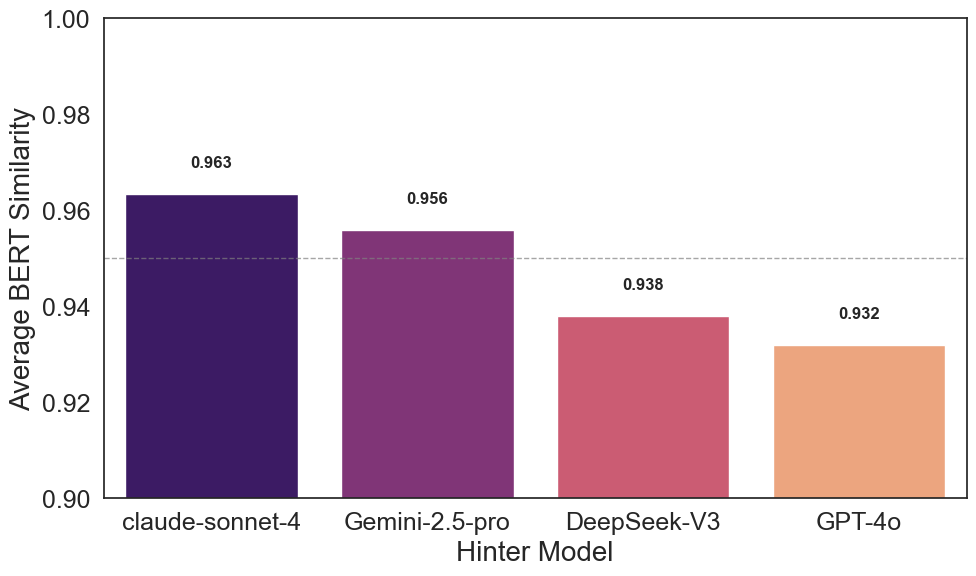

Figure 4-5: Hinter Model Average Similarity
  claude-sonnet-4: 0.963
  Gemini-2.5-pro: 0.956
  DeepSeek-V3: 0.938
  GPT-4o: 0.932



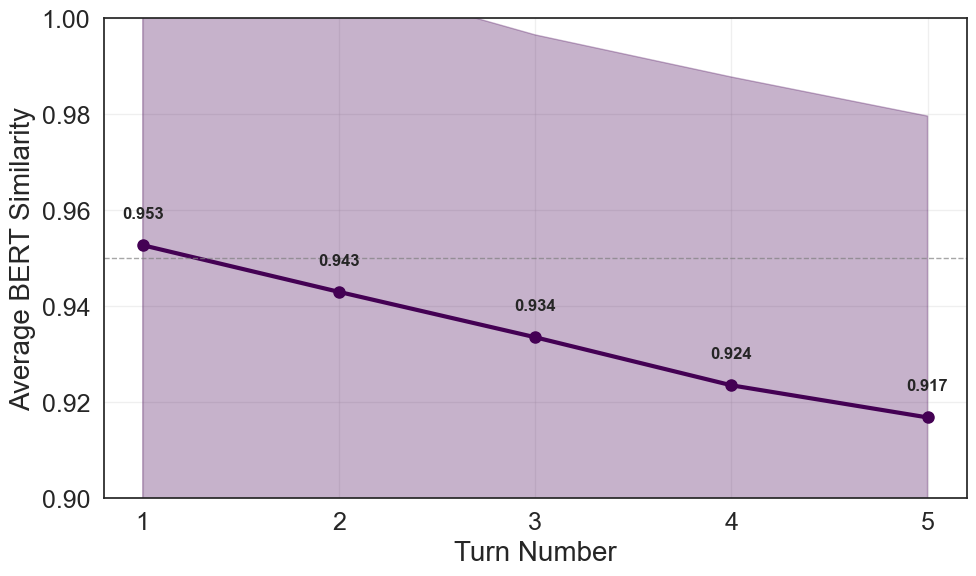

Figure 4-6: Similarity by Turn Number
  Turn 1: 0.953
  Turn 2: 0.943
  Turn 3: 0.934
  Turn 4: 0.924
  Turn 5: 0.917



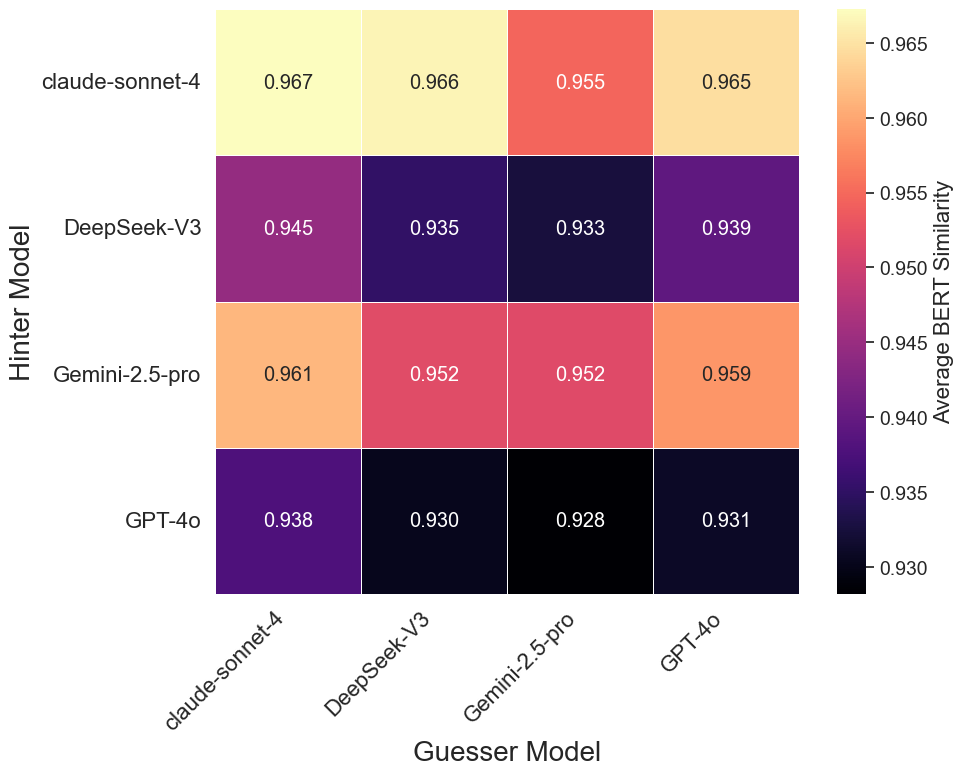

Figure 4-7: Hinter-Guesser Combination Similarity
guesser_model    claude-sonnet-4  DeepSeek-V3  Gemini-2.5-pro  GPT-4o
hinter_model                                                         
claude-sonnet-4            0.967        0.966           0.955   0.965
DeepSeek-V3                0.945        0.935           0.933   0.939
Gemini-2.5-pro             0.961        0.952           0.952   0.959
GPT-4o                     0.938        0.930           0.928   0.931

→ All three figures saved to figures/ directory
  - Figure_4-5_Hinter_Similarity.pdf/png
  - Figure_4-6_Turn_Similarity.pdf/png
  - Figure_4-7_Hinter_Guesser_Heatmap.pdf/png


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pathlib

# ---------- Load BERT Similarity Results ----------
def load_bert_results(filepath):
    """Load BERT similarity analysis results"""
    bert_results = pd.read_csv(filepath, encoding='utf-8')
    print(f"Loaded {len(bert_results)} BERT similarity records")
    print(f"Overall average similarity: {bert_results['similarity'].mean():.3f}")
    print(f"Standard deviation: {bert_results['similarity'].std():.3f}")
    return bert_results

# ---------- Model Name Mapping ----------
# "Full name → Short name" mapping
label_map = {
    "gpt-4o":                  "GPT-4o",
    "gemini-2.5-pro":        "Gemini-2.5-pro", 
    "deepseek-chat-v3-0324": "DeepSeek-V3",
    "moonshotai/kimi-k2":             "Claude-Sonnet-4",  # Based on your text description
    "gpt-4o":                         "GPT-4o",
    "gemini-2.5-flash":               "Gemini-2.5-Pro",
    "deepseek-v3":                    "DeepSeek-V3", 
    "kimi-k2":                        "Claude-Sonnet-4"
}

# Set theme
sns.set_theme(style="white", font_scale=1.2)
out_dir = pathlib.Path("figures")
out_dir.mkdir(exist_ok=True)

def plot_figure_4_5_hinter_similarity(df):
    """Figure 4-5: Average similarity by Hinter model"""
    # Calculate average similarity by hinter model
    hinter_similarity = (
        df.groupby('hinter_model')['similarity']
          .mean()
          .sort_values(ascending=False)
    )
    
    # Map to short names
    short_names = hinter_similarity.index.map(lambda x: label_map.get(x, x))
    
    plt.figure(figsize=(10, 6))
    bars = sns.barplot(
        x=short_names, y=hinter_similarity.values,
        palette=sns.color_palette("magma", n_colors=len(hinter_similarity))
    )
    
    plt.ylim(0.90, 1.0)  # Focus on the high similarity range
    plt.axhline(0.95, ls="--", c="gray", lw=1, alpha=0.7)  # Reference line
    plt.ylabel("Average BERT Similarity", fontsize=20)
    plt.xlabel("Hinter Model", fontsize=20)
    plt.xticks(rotation=0, fontsize=18)
    plt.yticks(fontsize=18)
    
    # Add value labels on bars
    for idx, val in enumerate(hinter_similarity.values):
        plt.text(idx, val + 0.005, f"{val:.3f}", ha="center", va="bottom",
                 fontsize=12, weight="bold")
    
    plt.tight_layout()
    plt.savefig(out_dir / "Figure_4-5_Hinter_Similarity.pdf", bbox_inches="tight")
    plt.savefig(out_dir / "Figure_4-5_Hinter_Similarity.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    print("Figure 4-5: Hinter Model Average Similarity")
    for model, sim in zip(short_names, hinter_similarity.values):
        print(f"  {model}: {sim:.3f}")
    
    return hinter_similarity

def plot_figure_4_6_turn_similarity(df):
    """Figure 4-6: Similarity trend by turn number"""
    # Calculate average similarity by turn
    turn_similarity = (
        df.groupby('turn_number')['similarity']
          .mean()
          .sort_index()
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(turn_similarity.index, turn_similarity.values, 'o-', 
             linewidth=3, markersize=8, color='#440154')  # Dark purple from magma
    
    # Add error bars (standard deviation)
    turn_std = df.groupby('turn_number')['similarity'].std()
    plt.fill_between(turn_similarity.index, 
                     turn_similarity.values - turn_std.values,
                     turn_similarity.values + turn_std.values, 
                     alpha=0.3, color='#440154')
    
    plt.ylim(0.90, 1.0)  # Focus on the high similarity range
    plt.axhline(0.95, ls="--", c="gray", lw=1, alpha=0.7)  # Reference line
    plt.ylabel("Average BERT Similarity", fontsize=20)
    plt.xlabel("Turn Number", fontsize=20)
    plt.xticks(turn_similarity.index, fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on points
    for turn, val in zip(turn_similarity.index, turn_similarity.values):
        plt.text(turn, val + 0.005, f"{val:.3f}", ha="center", va="bottom",
                 fontsize=12, weight="bold")
    
    plt.tight_layout()
    plt.savefig(out_dir / "Figure_4-6_Turn_Similarity.pdf", bbox_inches="tight")
    plt.savefig(out_dir / "Figure_4-6_Turn_Similarity.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    print("Figure 4-6: Similarity by Turn Number")
    for turn, sim in turn_similarity.items():
        print(f"  Turn {turn}: {sim:.3f}")
    
    return turn_similarity

def plot_figure_4_7_heatmap(df):
    """Figure 4-7: Hinter-Guesser combination similarity heatmap"""
    # Calculate similarity by hinter-guesser combination
    heatmap_data = (
        df.groupby(['hinter_model', 'guesser_model'])['similarity']
          .mean()
          .unstack()
    )
    
    # Map to short names
    heatmap_data.index = heatmap_data.index.map(lambda x: label_map.get(x, x))
    heatmap_data.columns = heatmap_data.columns.map(lambda x: label_map.get(x, x))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, 
                annot=True, 
                fmt='.3f', 
                cmap='magma',
                cbar_kws={'label': 'Average BERT Similarity'},
                square=True,
                linewidths=0.5)
    
    plt.ylabel("Hinter Model", fontsize=20)
    plt.xlabel("Guesser Model", fontsize=20)
    plt.xticks(fontsize=16, rotation=45, ha='right')
    plt.yticks(fontsize=16, rotation=0)
    
    # Adjust colorbar
    cbar = plt.gca().collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Average BERT Similarity', fontsize=16)
    
    plt.tight_layout()
    plt.savefig(out_dir / "Figure_4-7_Hinter_Guesser_Heatmap.pdf", bbox_inches="tight")
    plt.savefig(out_dir / "Figure_4-7_Hinter_Guesser_Heatmap.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    print("Figure 4-7: Hinter-Guesser Combination Similarity")
    print(heatmap_data.round(3))
    
    return heatmap_data

def generate_bert_analysis_figures(filepath):
    """Generate all three BERT analysis figures"""
    print("🔍 Generating BERT Similarity Analysis Figures...")
    
    # Load data
    bert_results = load_bert_results(filepath)
    
    # Convert similarity to percentage scale (0-1 to 0-100) if needed
    if bert_results['similarity'].max() <= 1.0:
        print("Converting similarity to percentage scale...")
        bert_results['similarity'] = bert_results['similarity'] * 100
    
    print(f"\nOverall Statistics:")
    print(f"  Average similarity: {bert_results['similarity'].mean():.1f}%")
    print(f"  Standard deviation: {bert_results['similarity'].std():.3f}")
    print(f"  Range: {bert_results['similarity'].min():.1f}% - {bert_results['similarity'].max():.1f}%")
    
    # Generate Figure 4-5: Hinter Model Similarity
    print("\n" + "="*50)
    hinter_sim = plot_figure_4_5_hinter_similarity(bert_results)
    
    # Generate Figure 4-6: Turn-wise Similarity
    print("\n" + "="*50)
    turn_sim = plot_figure_4_6_turn_similarity(bert_results)
    
    # Generate Figure 4-7: Hinter-Guesser Heatmap
    print("\n" + "="*50)
    heatmap_data = plot_figure_4_7_heatmap(bert_results)
    
    print("\n" + "="*50)
    print("→ All three figures saved to figures/ directory")
    print("  - Figure_4-5_Hinter_Similarity.pdf/png")
    print("  - Figure_4-6_Turn_Similarity.pdf/png") 
    print("  - Figure_4-7_Hinter_Guesser_Heatmap.pdf/png")
    
    return {
        'hinter_similarity': hinter_sim,
        'turn_similarity': turn_sim,
        'heatmap_data': heatmap_data
    }

# Usage
if __name__ == "__main__":
    # Replace with your BERT similarity result file path
    bert_file = "bert_multi_model_similarity_analysis.csv"
    results = generate_bert_analysis_figures(bert_file)
